# Interpretando los modelos, conectando con humanos

## SHAP Values

### Librerías

In [1]:
# Importo Librerías útiles
import pandas as pd
import numpy as np

import lightgbm as lgb
import shap
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer
from matplotlib.colors import  ListedColormap
import random



IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Defino semilla

In [2]:
# Configura la semilla
seed_value = 8  # Puedes usar cualquier número entero como semilla
random.seed(seed_value)

### Carga de Datos

Cargamos el dataset de la competencia 02, seleccionamos meses de entrenamiento y mapeamos la clase_ternaria a 0 y 1

In [3]:
# Levanto el archivo
ds = pd.read_csv("C:/Users/vanes/Documents/UBA/2do_cuatrimestre/DMEyF/datasets/competencia_02.csv.gz", compression="gzip")

# Selecciono los meses en los que quiero buscar patrones (últimos 8 meses, obviando pandemia)
meses = [202010, 202011, 202012, 202101, 202102, 202103, 202104, 202105]
ds_train = ds[ds.foto_mes.isin(meses)]

# La clase será 0 si es CONTINUA 1 si es BAJA+1 o BAJA+2
clase_train = ds_train["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

# Eliminamos dataset original para liberar espacio
del ds

print("Dimensiones del set de training:", ds_train.shape)

Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.


Dimensiones del set de training: (1296241, 155)


Armamos un **dataset** con solo los casos de **BAJAS+1** y **BAJAS+2**. Sacamos de los **datasets** los targets.

In [4]:
# Dataset con sólo bajas
ds_bajas = ds_train.query("clase_ternaria != 'CONTINUA'")

# Dropeo columnas del target y cliente
ds_train = ds_train.drop(["clase_ternaria", "numero_de_cliente"], axis=1)
ds_bajas = ds_bajas.drop(["clase_ternaria", "numero_de_cliente"], axis=1)

print("Dimensiones del set de bajas:", ds_bajas.shape)

Dimensiones del set de bajas: (12987, 153)


### Modelo LGBM

Entrenamos un modelo **LGBM** con los mejores parámetros encontrados:

In [5]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(ds_train, clase_train)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.0133326486877864,
    'verbose': 1,
    'max_bin': 31,
    'min_data_in_leaf': 516,
    'verbose': 0,
}

gbm = lgb.train(params, lgb_train, num_boost_round=100)
# calculamos las p para los clientes bajas (no me estoy preocupando del overfitting ni nada, algo quizás usted debiera)
p_bajas = gbm.predict(ds_bajas)


### Feature importances del modelo (global)

In [6]:
# Obtengo las features importances del modelo entregado
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


Features  Importances
32        mprestamos_personales          201
0                      foto_mes          187
50                 cpayroll_trx          184
7          mrentabilidad_annual          158
9               mactivos_margen          151
..                          ...          ...
66     ctarjeta_visa_descuentos            0
65  mcajeros_propios_descuentos            0
64  ccajeros_propios_descuentos            0
62              cpagomiscuentas            0
76                   mforex_buy            0

[153 rows x 2 columns]

Sin embargo podemos intuir que si un modelo detecta múltiples patrones, no todos los casos van a ser afectados por el mismo. Tiene sentido que dos clientes se den de baja por motivos distintos y que un modelo pondere para cada caso, un peso distinto a los **features**. O sea, necesitamos una forma de explicar de forma local (caso a caso) en vez de una global (para todos los casos). Para esto utilizaremos los modelos [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html)  

### Modelo de interpretabilidad SHAP

Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [7]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(ds_bajas)
shap_bajas = pd.DataFrame(shap_values[0], columns = ds_bajas.columns)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


En la variable `shap_bajas` contaríamos para cada caso, el peso de la influencia de esa **feature** de acuerdo al modelo. Veamos un caso, tomemos un cliente:

In [8]:
# busco un caso en p_bajas, con un p alta, y tomo su indice
cliente_idx = 7
print(p_bajas[cliente_idx])
df = pd.concat([ds_bajas.iloc[cliente_idx], shap_bajas.iloc[cliente_idx]], axis=1)
df.sort_values(by=[cliente_idx], ascending=False)

0.06324126581547411


2938284   7      
foto_mes                   202010.0  0.145737
thomebanking                    0.0  0.055644
ccomisiones_mantenimiento       0.0  0.046874
mcomisiones_mantenimiento       0.0  0.022921
cdescubierto_preacordado        1.0  0.021796
...                             ...       ...
mcaja_ahorro                    0.0 -0.139900
mprestamos_personales           0.0 -0.170675
mtarjeta_visa_consumo           0.0 -0.197035
cpayroll_trx                    0.0 -0.388175
ctrx_quarter                    0.0 -1.254052

[153 rows x 2 columns]

En la tabla anterior, los **features** con números positivos "adicionan(*)" a la probabilidad y los negativos. 

(*) Aquí estamos usando TreeSHAP, que no es tan directa como Kernel SHAP para la interpretación directa. 

También podemos combinar todos los valores de SHAP y recrear una nueva importancia de variables:

In [9]:
shap_bajas.abs().mean().sort_values(ascending=False)


ctrx_quarter                   0.977989
cpayroll_trx                   0.404436
mprestamos_personales          0.175494
mtarjeta_visa_consumo          0.164174
mcuentas_saldo                 0.150969
                                 ...   
mtarjeta_visa_descuentos       0.000000
ctarjeta_visa_descuentos       0.000000
mcajeros_propios_descuentos    0.000000
ccajeros_propios_descuentos    0.000000
mforex_buy                     0.000000
Length: 153, dtype: float64

La librería contiene útiles herramientas para vizualizar la info anterior

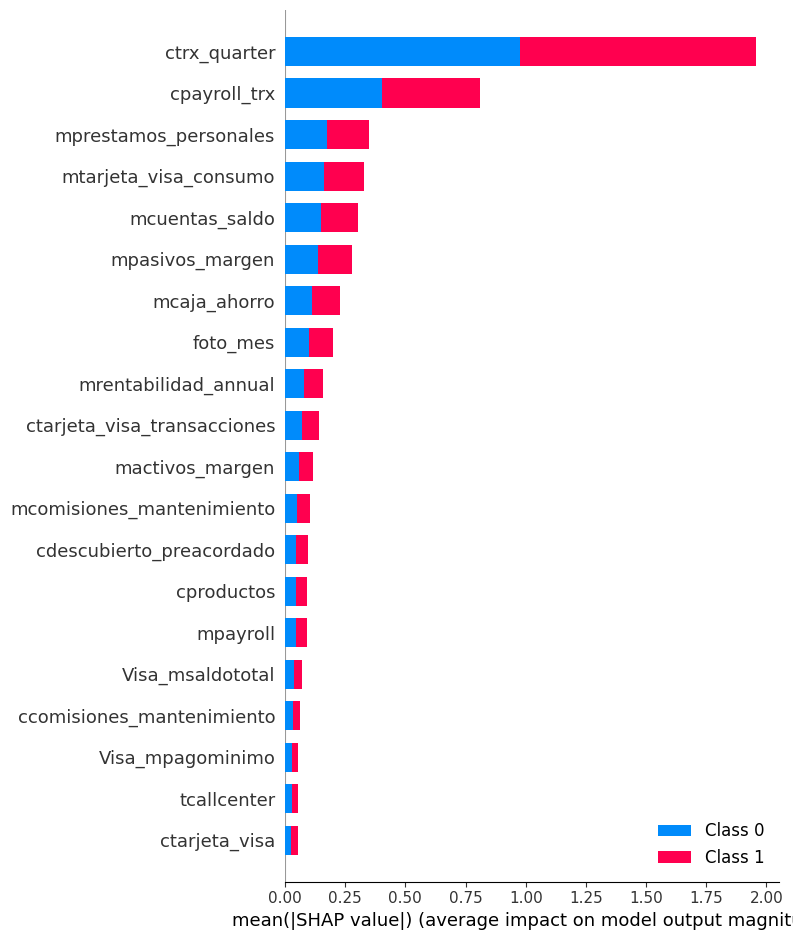

In [10]:
shap.summary_plot(shap_values, ds_bajas)


Para ver más opciones de visualización
https://www.youtube.com/watch?v=L8_sVRhBDLU&t=3s

¿Se podrá hacer una clusterización sobre los valores de shap?

Lo que estaríamos buscando es: "Juntar a todos los clientes que son afectamos por los mismos patrones del modelo, entendiendo que si les afecto el mismo patrón, sus SHAP van a ser similares." Presunción fuerte.
 
Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Por como es la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento. Usamos UMAP para estos embedding, https://www.youtube.com/watch?v=eN0wFzBA4Sc (triple BAM (?))

### Reducción de la dimensionalidad UMAP

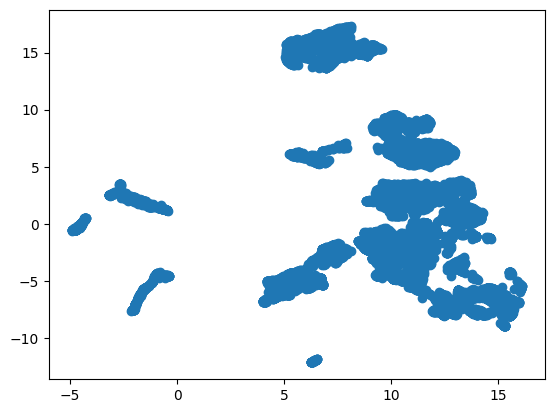

In [11]:
embedding_2d = UMAP(
  n_components=2, n_neighbors=40
).fit_transform(shap_values[0])
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

Vemos manchas separadas entre ellas, admiramos a UMAP. Hizo el trabajo sucio.

Algo importante cuando trabaja con modelos, es recordar que no siempre detectan con la misma "fuerza" todos los casos. Incluso nosotros solo terminamos mandando a Kaggle un subconjunto de casos. Si vemos el histograma de las probabilidades de salida

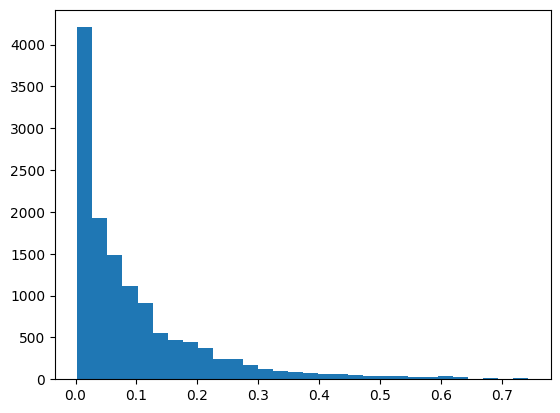

In [12]:
plt.hist(p_bajas,bins=30)
plt.show()

Vemos que hay en los 2000 y algo de casos, 500 que no estaríamos mandando. Veamos si hay alguna relación si cruzamos el embedding y su probabilidad

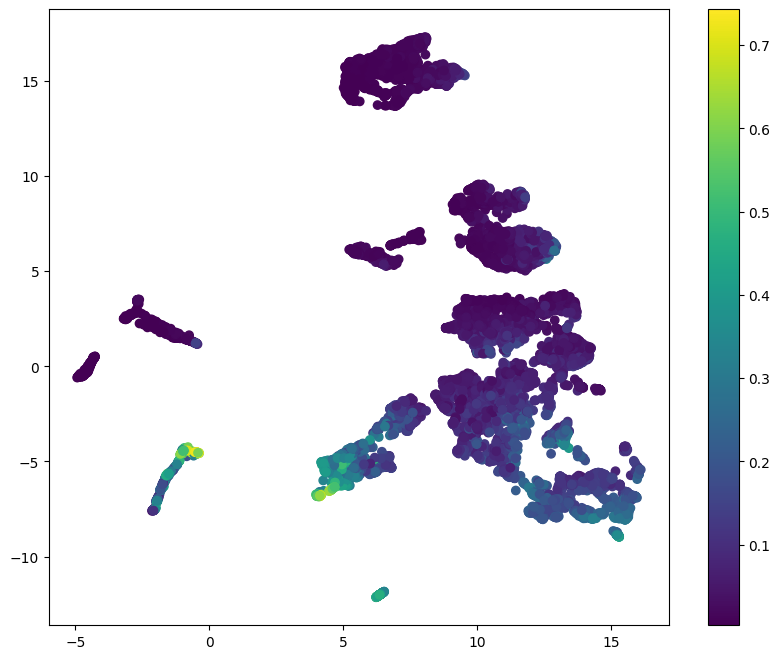

In [13]:
plt.figure(figsize=(10, 8))
sc = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=p_bajas)
plt.colorbar(sc)
plt.show()


### Clusterización con DBSCAN

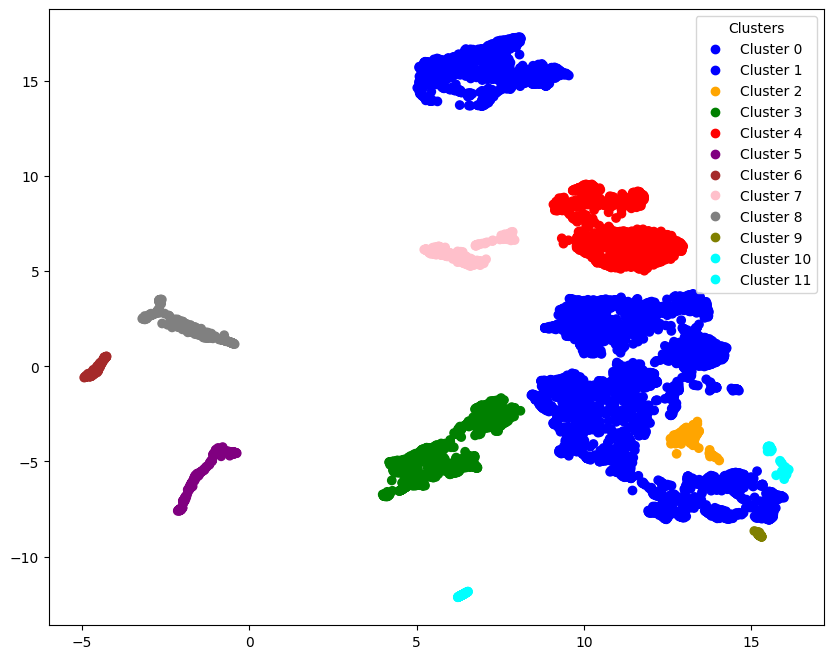

In [14]:
# Modelo de clusterización
hdb = DBSCAN(eps=0.6) # juegue con los parámetros 
y = hdb.fit(embedding_2d)

plt.figure(figsize=(10, 8))
cmap = ListedColormap(['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
sc = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=y.labels_, cmap=cmap)
unique_labels = set(y.labels_)
cluster_labels = [f'Cluster {label}' for label in unique_labels]
plt.legend(handles=sc.legend_elements()[0], labels=cluster_labels, title='Clusters')

plt.show()

In [28]:
# Guardo las variables importantes en un csv para cada cluster
variables_por_cluster = {0:[],
                         1:[],
                         2:[],
                         3:[],
                         4:[],
                         5:[],
                         6:[],
                         7:[],
                         8:[],
                         9:[],
                         10:[],
                         11:[]
                         }

cluster_labels = y.labels_

for i in range(12):
    shap_result = shap_bajas[cluster_labels == i].mean().sort_values(ascending=False)

    # Convierte el resultado en un DataFrame
    shap_result_df = pd.DataFrame(shap_result, columns=['shap_value'])
    
    variables_positivas = list(shap_result_df[shap_result_df.shap_value > 0].index)
    variables_por_cluster[i] = variables_positivas
    # Guarda el DataFrame en un archivo CSV
    shap_result_df.to_csv(f'C:/Users/vanes/Documents/UBA/2do_cuatrimestre/DMEyF/shap_bajas_cluster_{i}.csv', sep=';', decimal=',')

In [29]:
variables_por_cluster

{0: ['ctarjeta_master',
  'cdescubierto_preacordado',
  'tcallcenter',
  'Master_status',
  'chomebanking_transacciones',
  'ccajas_transacciones',
  'ccaja_ahorro',
  'ccallcenter_transacciones',
  'Visa_status',
  'ctarjeta_visa_debitos_automaticos',
  'Visa_mconsumospesos',
  'ctransferencias_emitidas',
  'cmobile_app_trx',
  'ctransferencias_recibidas',
  'Visa_mconsumosdolares',
  'ccajas_otras',
  'Visa_cconsumos',
  'active_quarter',
  'mttarjeta_visa_debitos_automaticos',
  'mcaja_ahorro_adicional'],
 1: ['ctrx_quarter',
  'mcaja_ahorro',
  'Visa_status',
  'ctarjeta_master',
  'Master_mpagospesos',
  'Master_mpagosdolares',
  'mtransferencias_recibidas',
  'cplazo_fijo'],
 2: ['ctarjeta_master',
  'ccaja_ahorro',
  'mcuenta_corriente',
  'Visa_status',
  'ctarjeta_visa_debitos_automaticos',
  'Visa_mconsumospesos',
  'Master_status',
  'chomebanking_transacciones',
  'tmobile_app',
  'mttarjeta_visa_debitos_automaticos',
  'Visa_mconsumosdolares',
  'mcaja_ahorro_adicional'],


### Comparación de distribuciones

Y comparamos las distribuciones de las variables importantes con la de la población general, para entender que distingue a nuestro cluster.

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


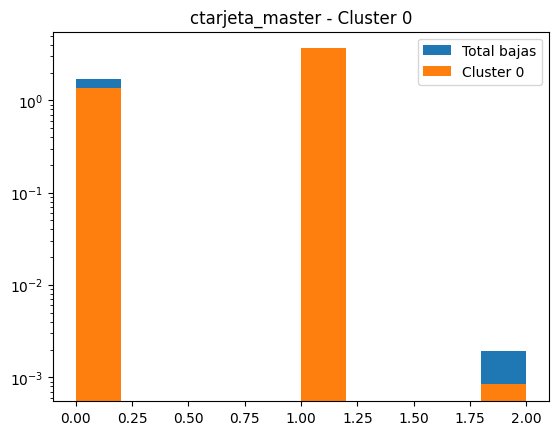

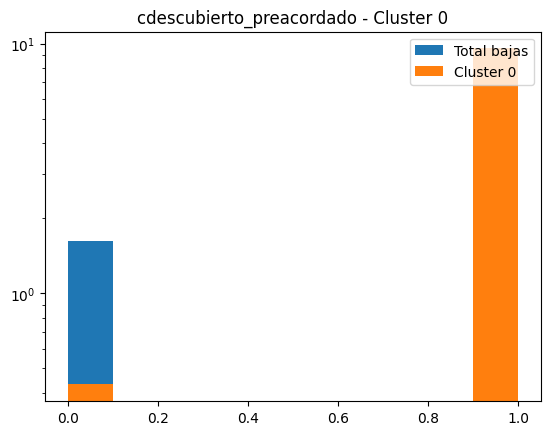

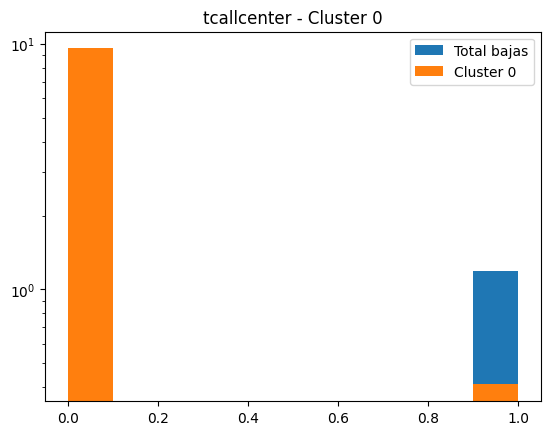

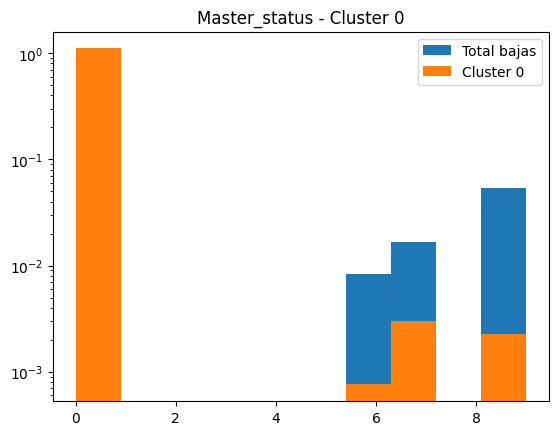

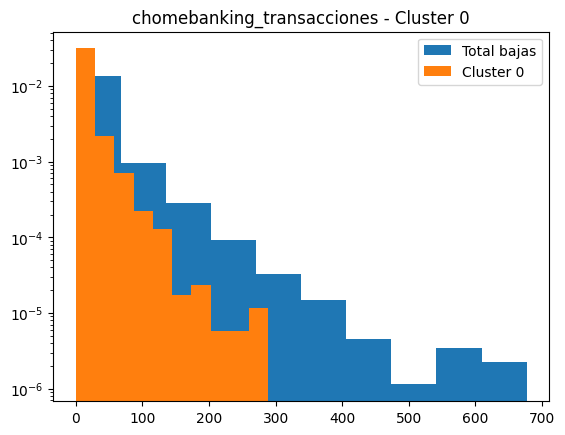

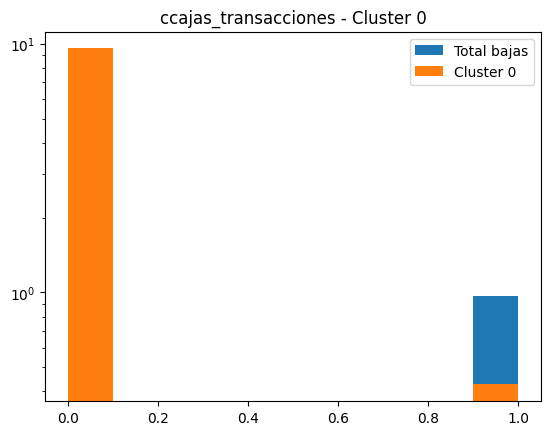

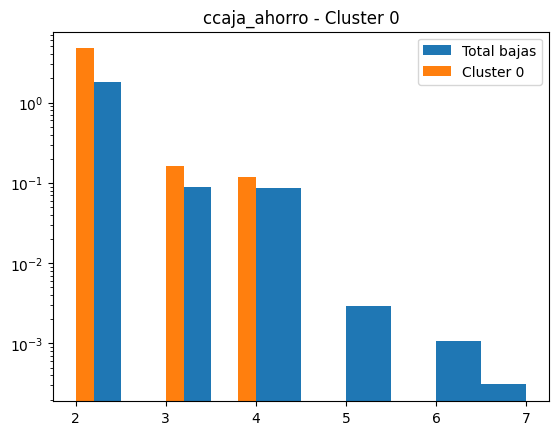

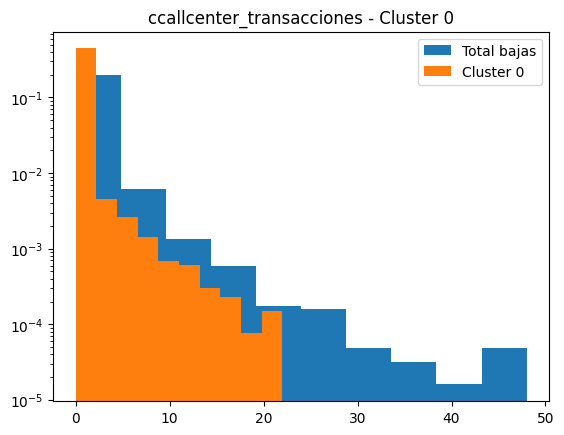

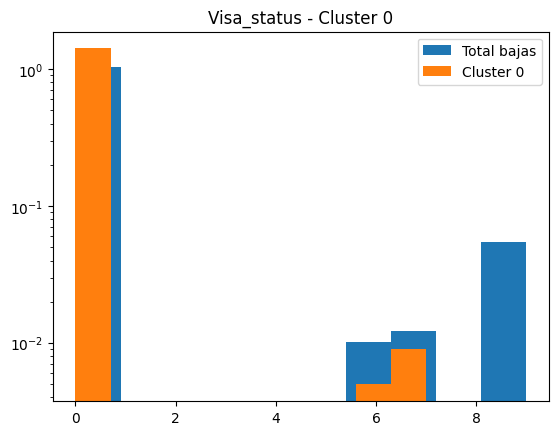

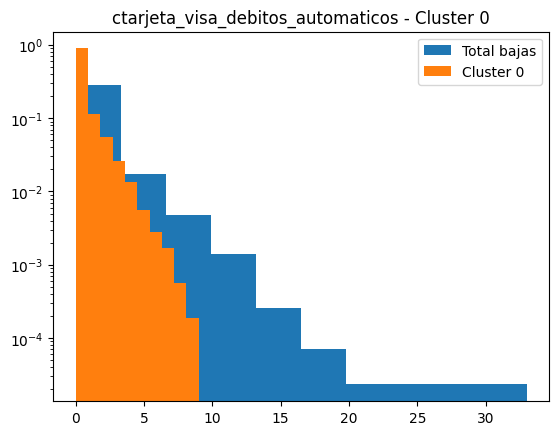

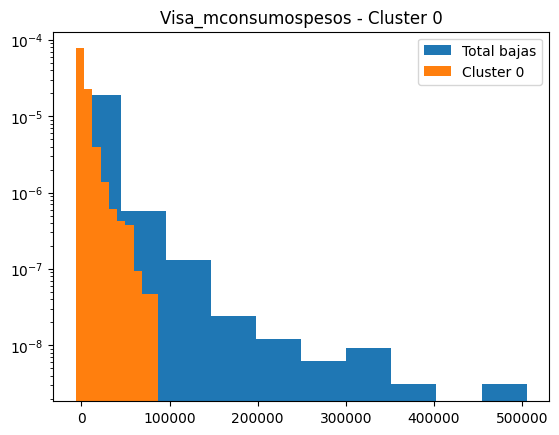

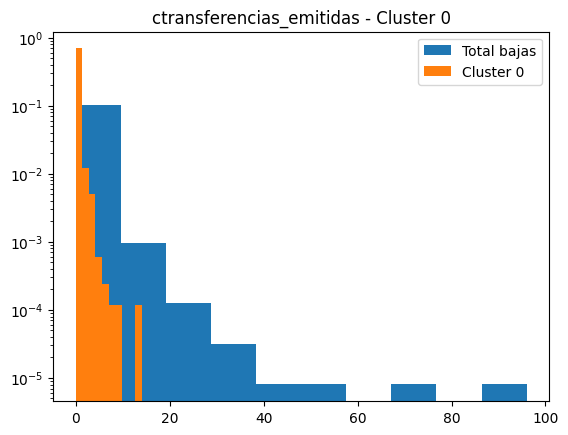

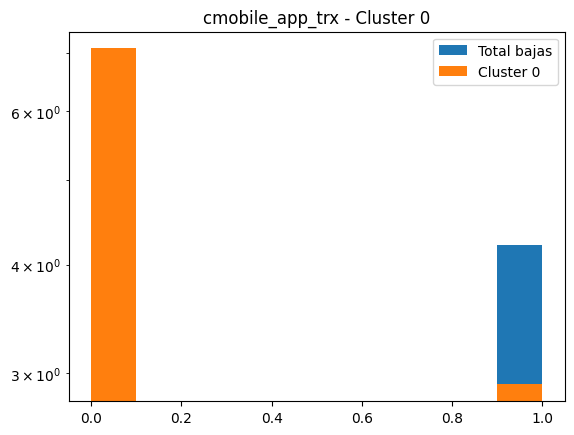

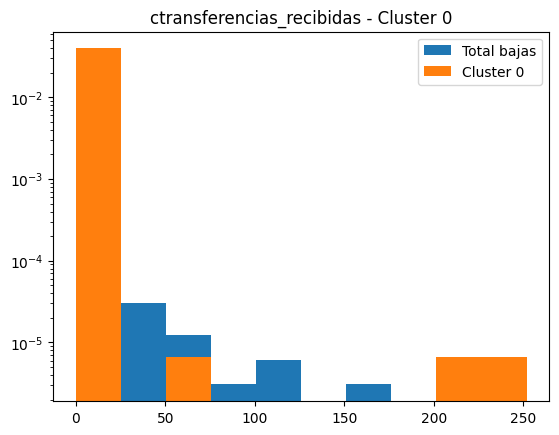

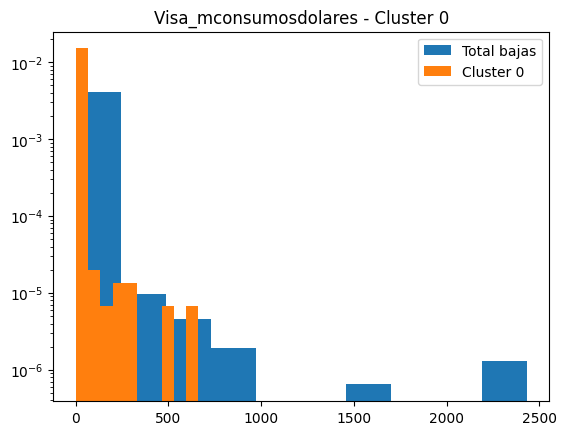

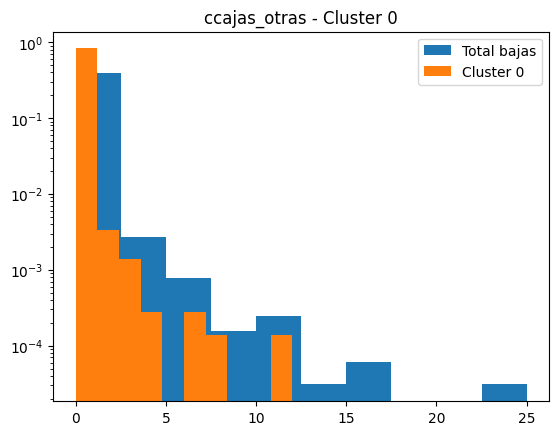

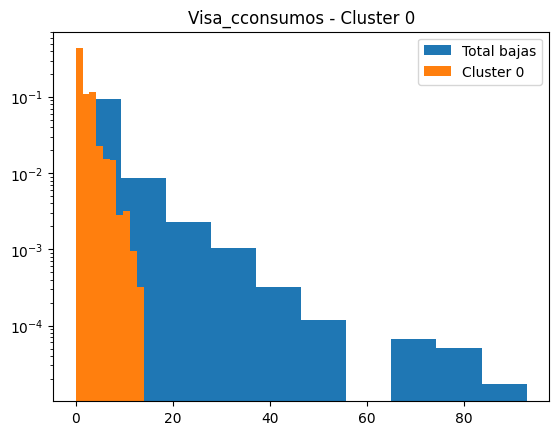

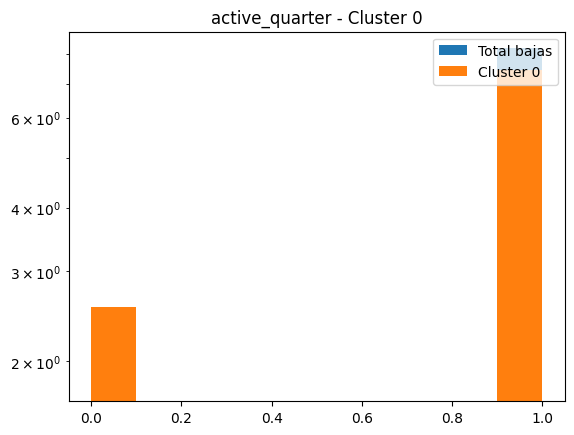

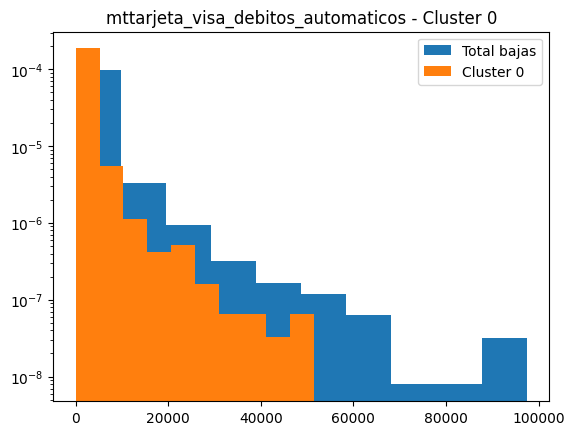

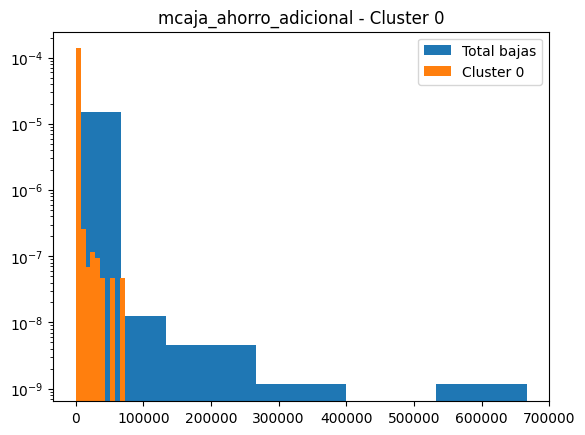

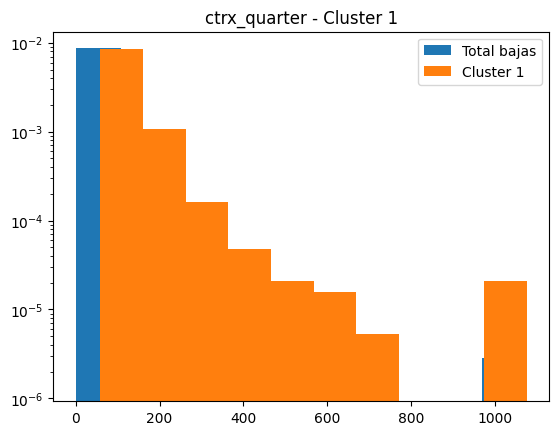

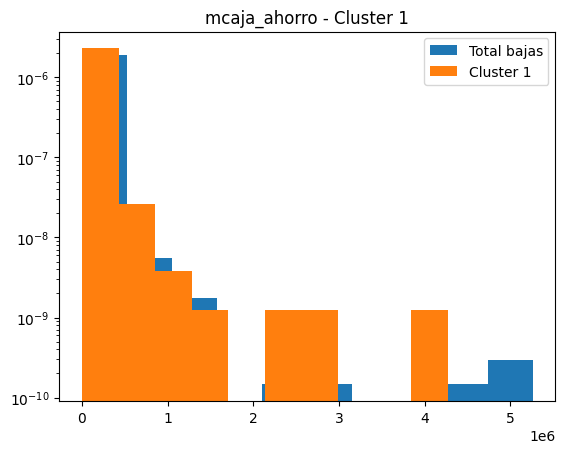

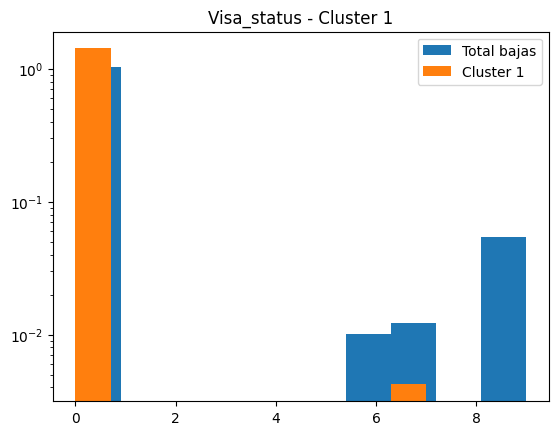

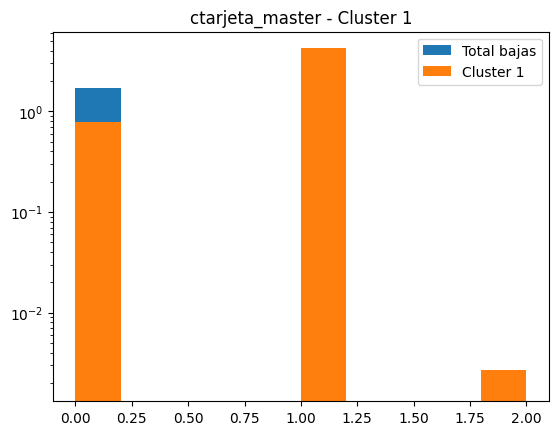

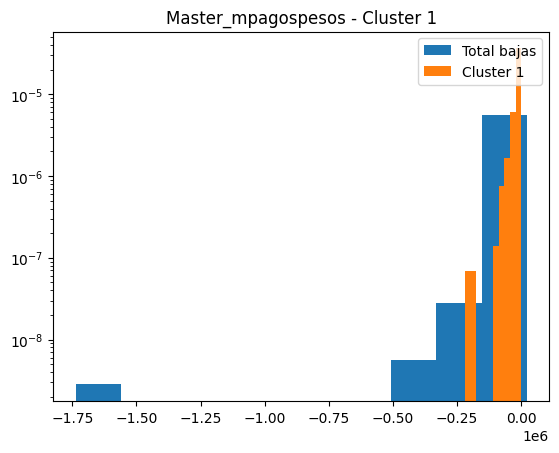

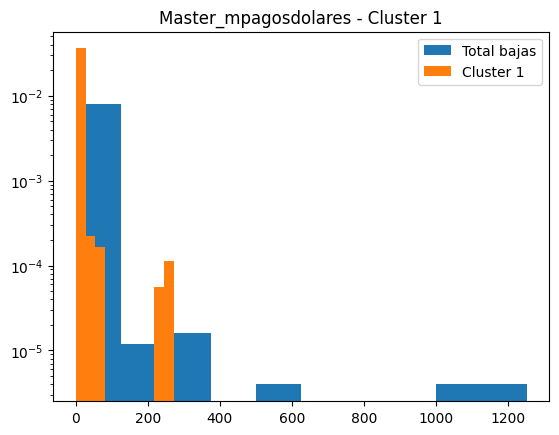

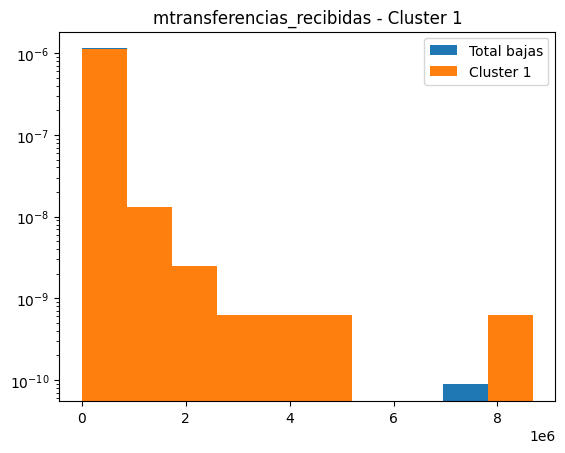

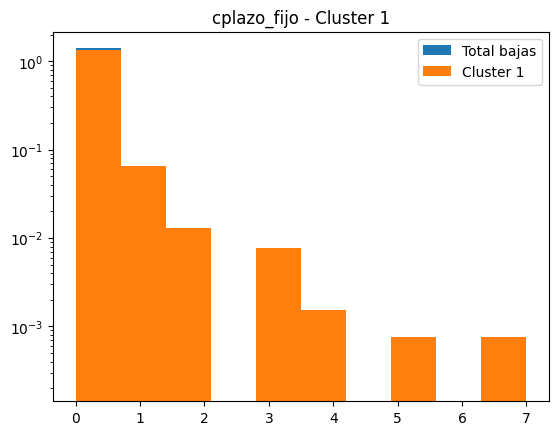

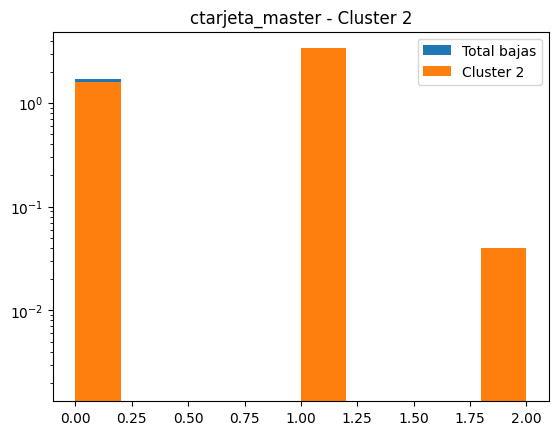

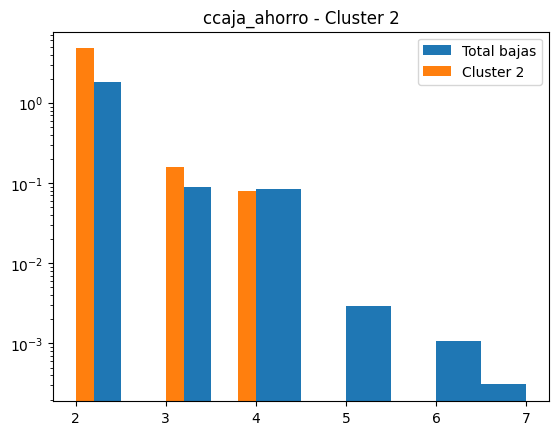

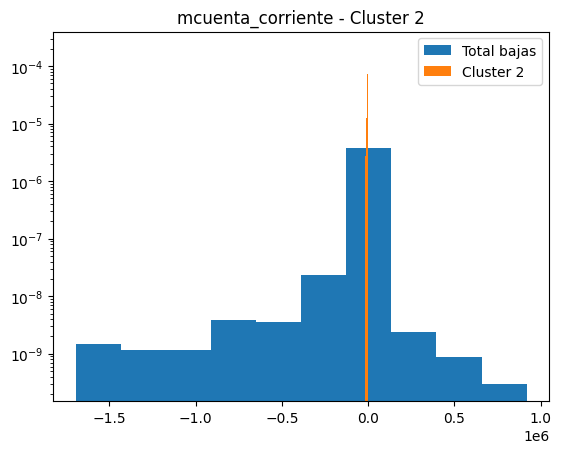

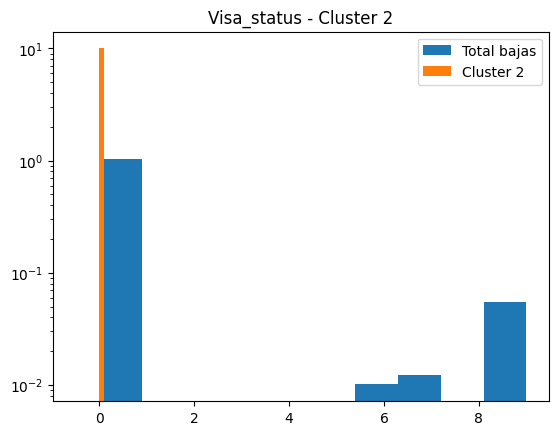

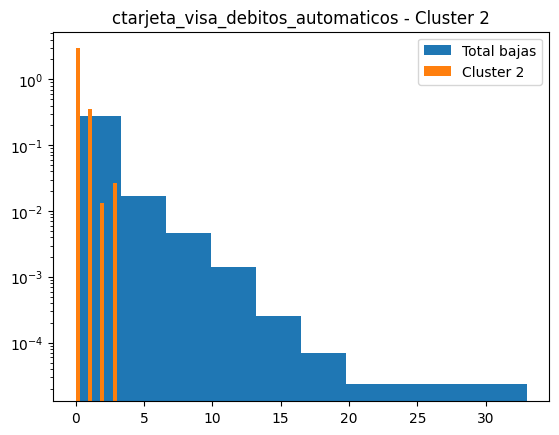

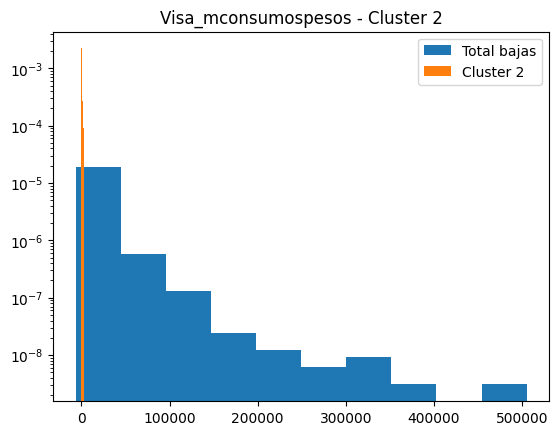

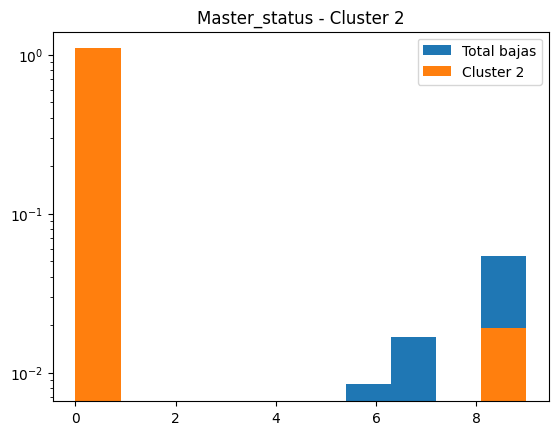

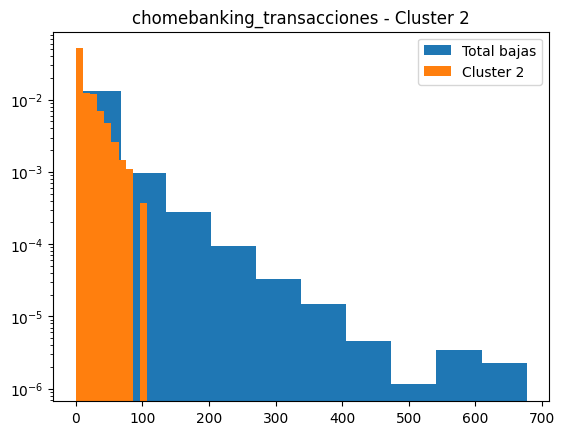

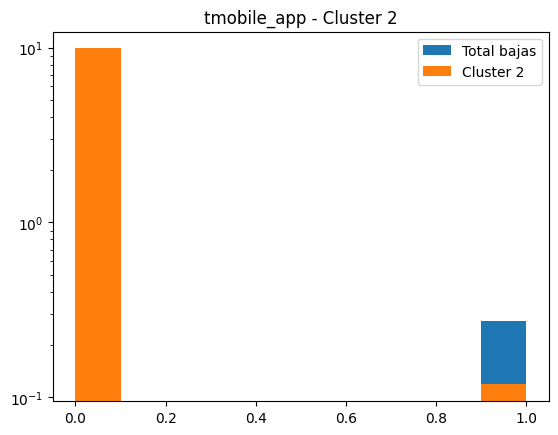

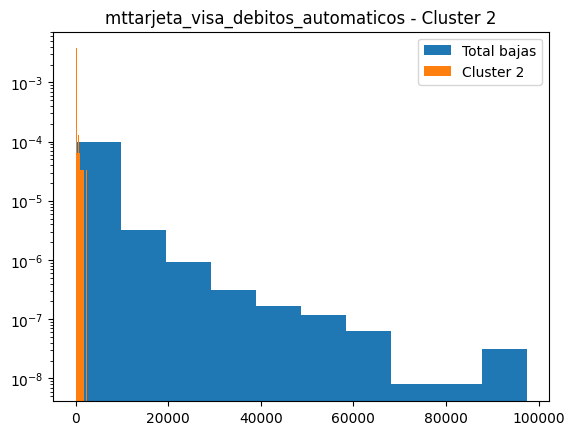

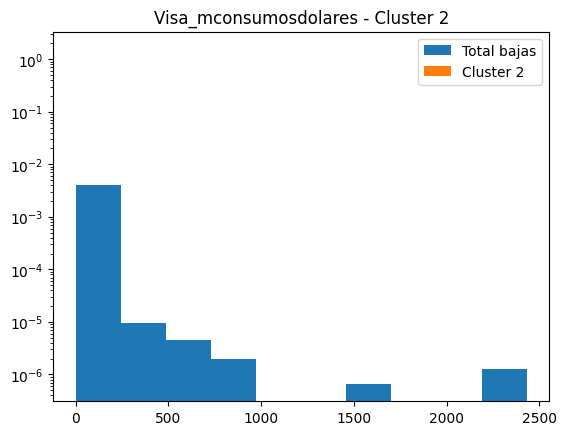

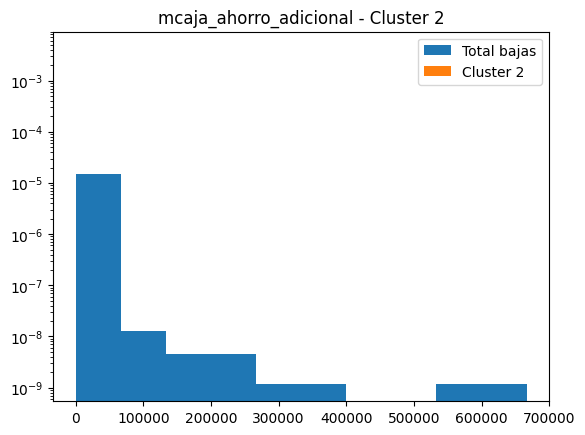

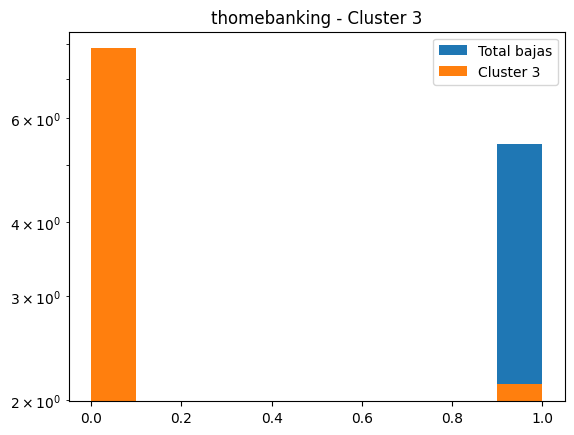

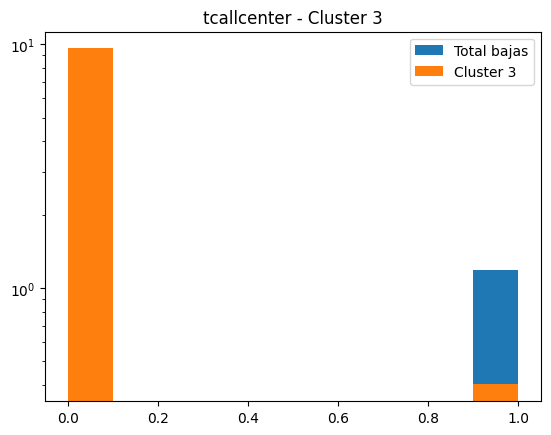

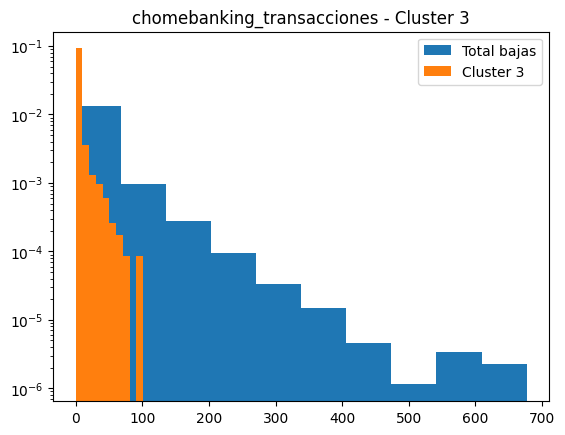

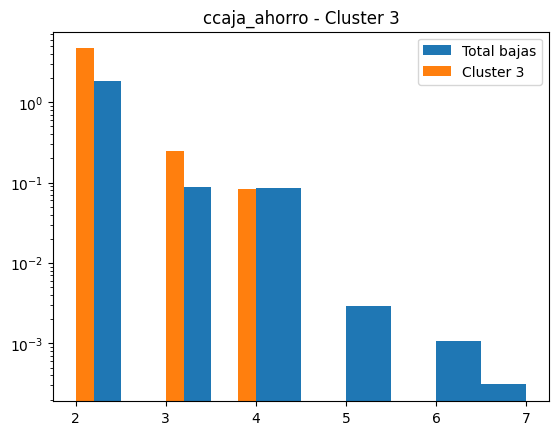

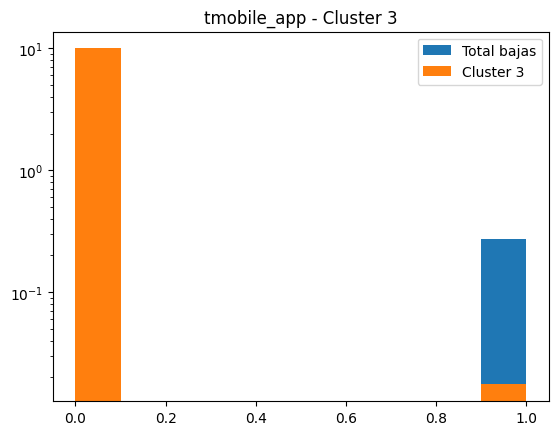

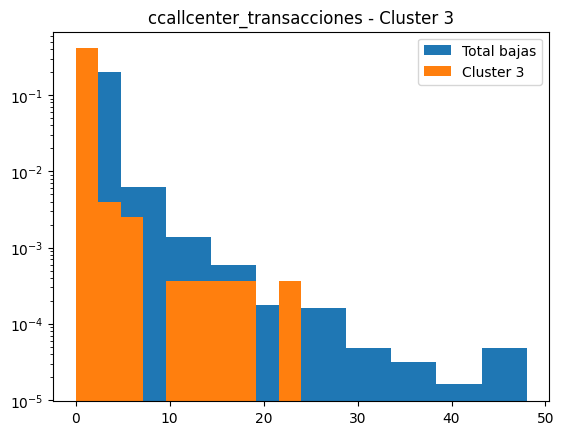

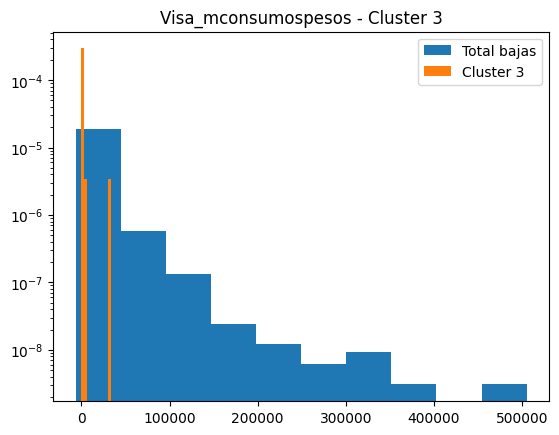

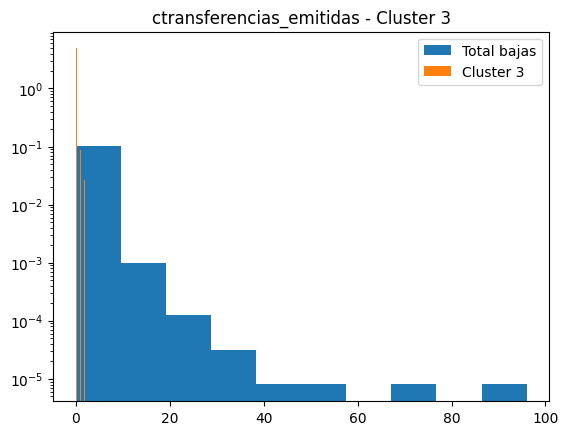

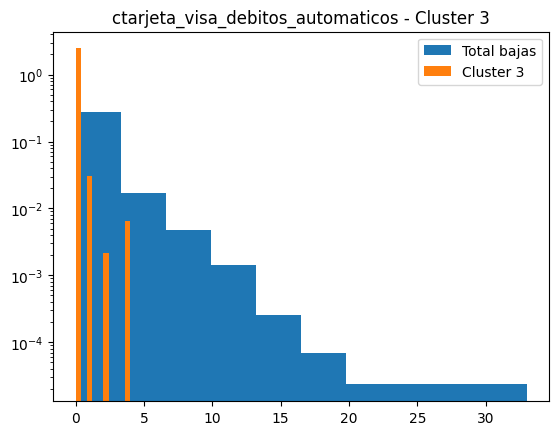

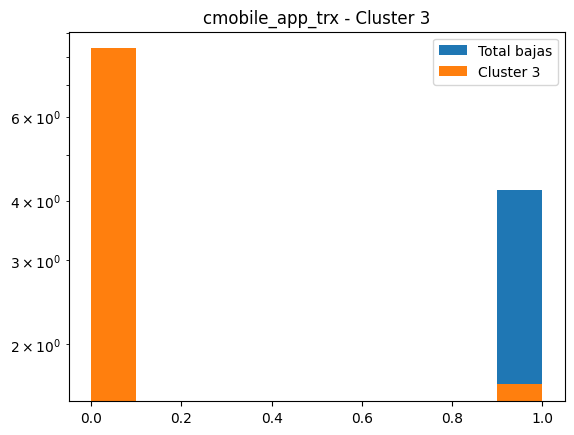

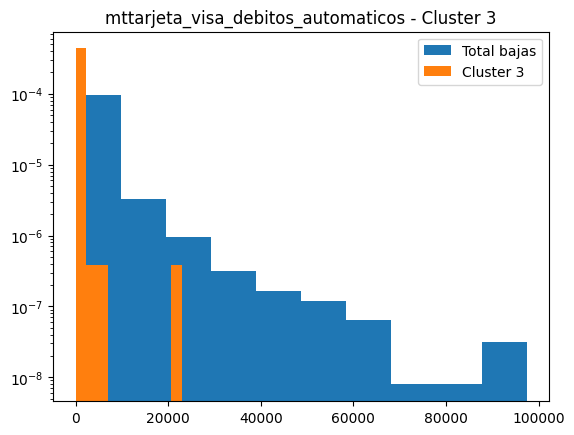

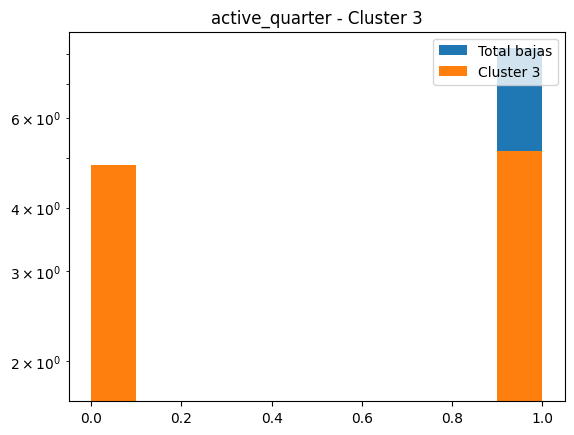

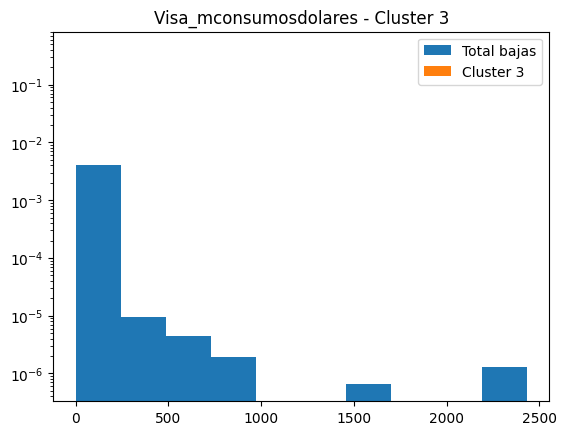

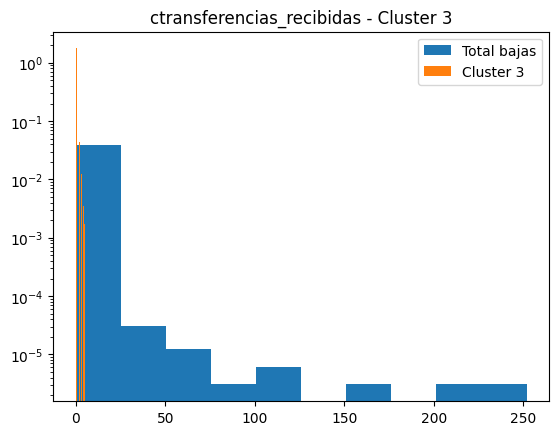

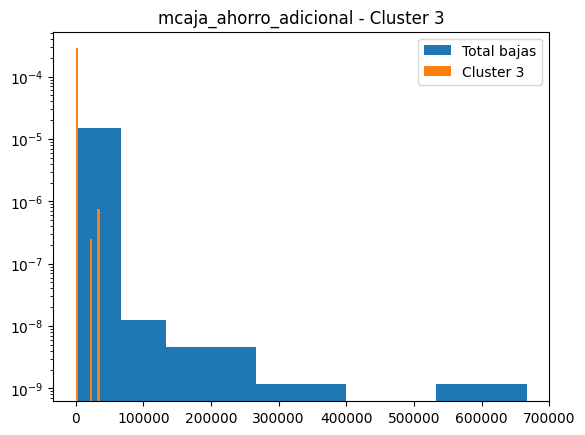

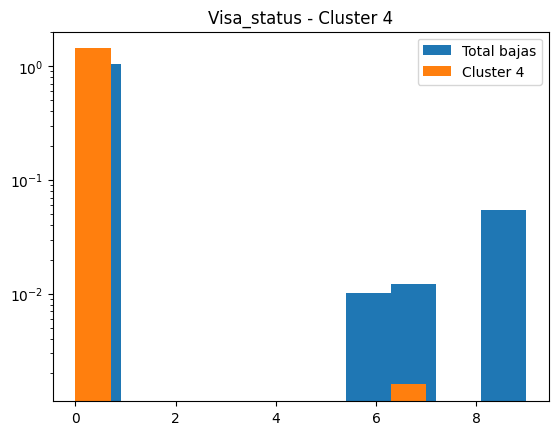

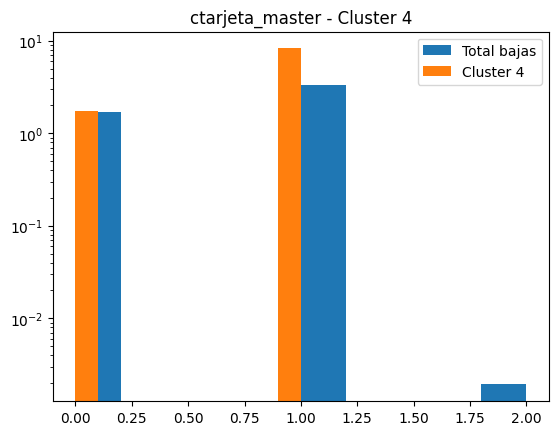

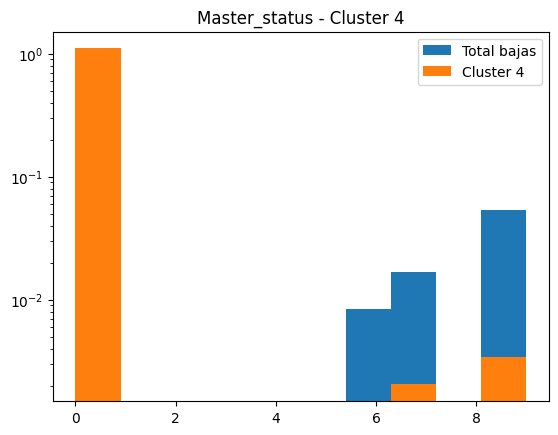

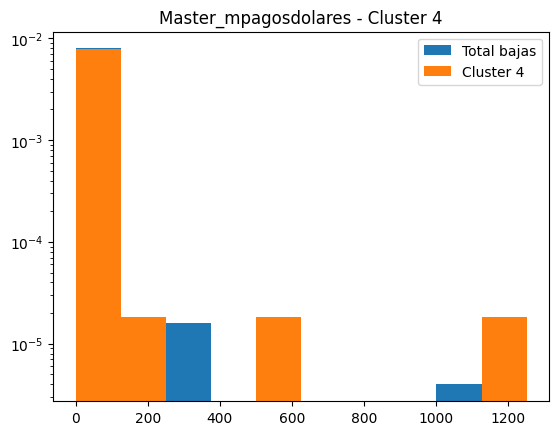

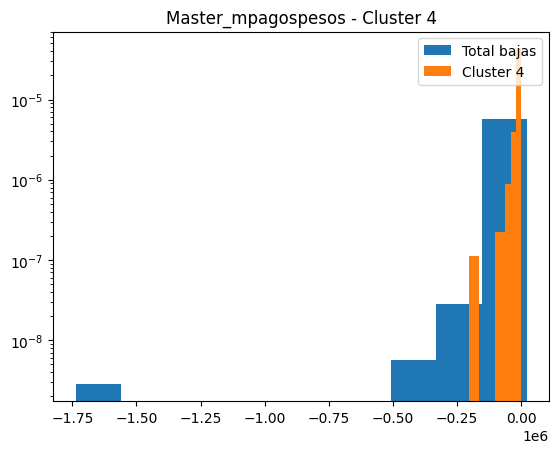

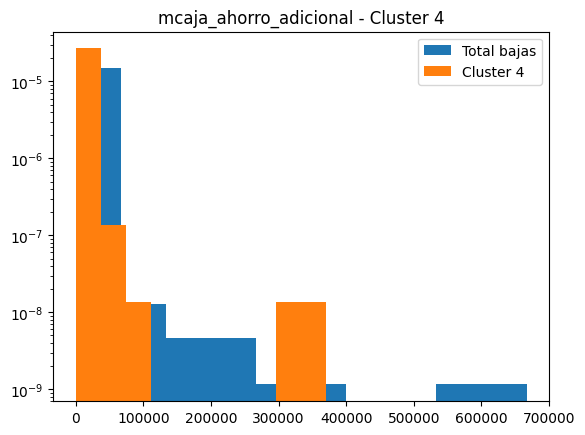

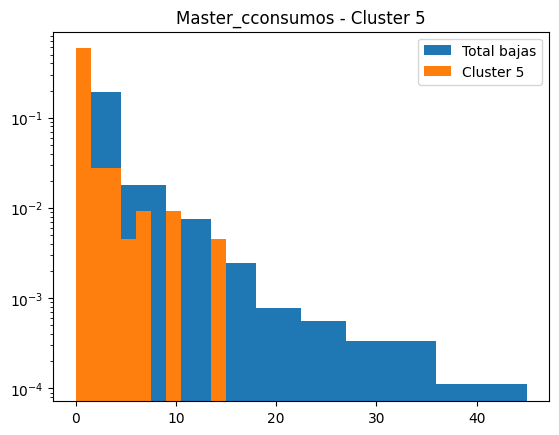

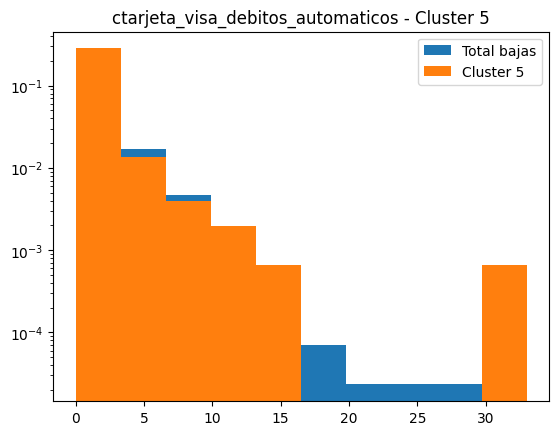

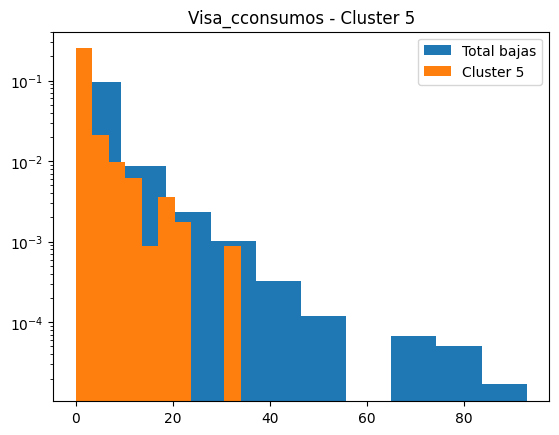

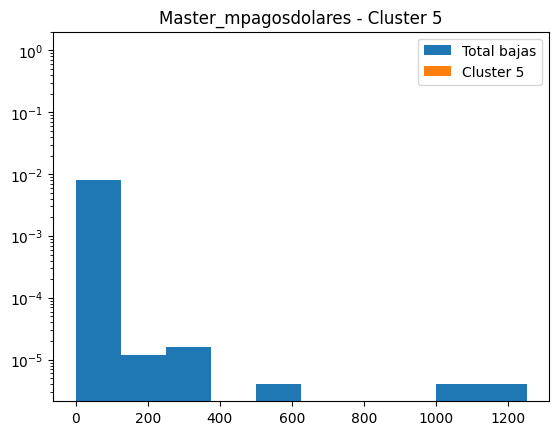

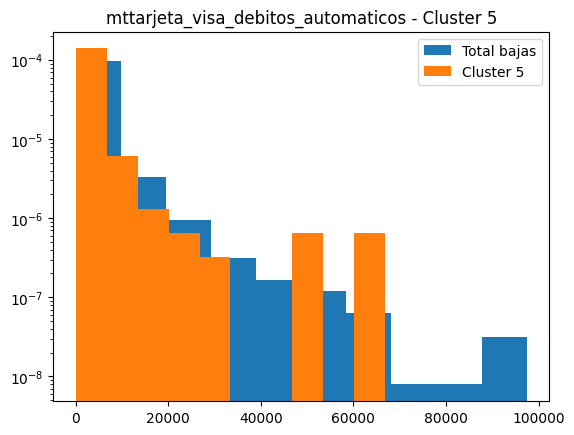

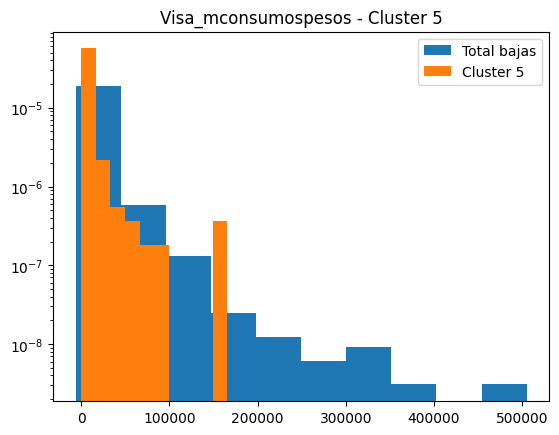

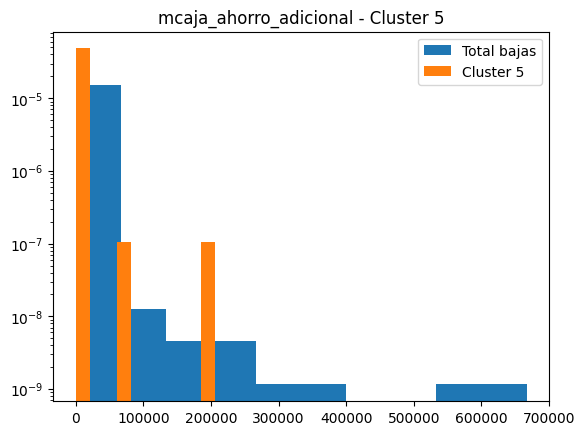

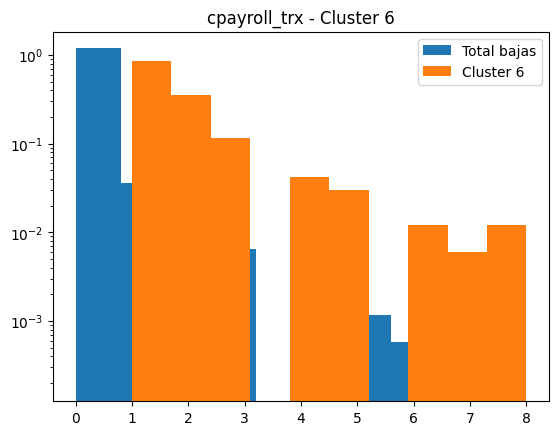

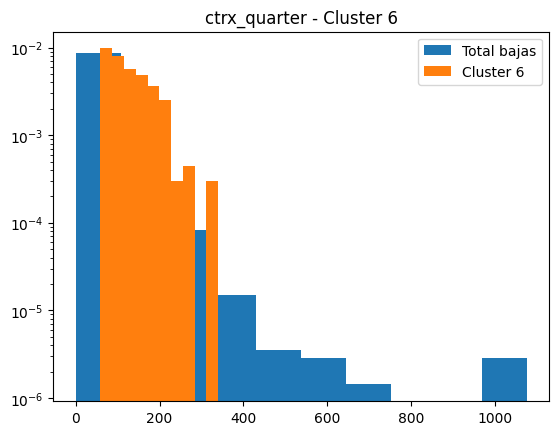

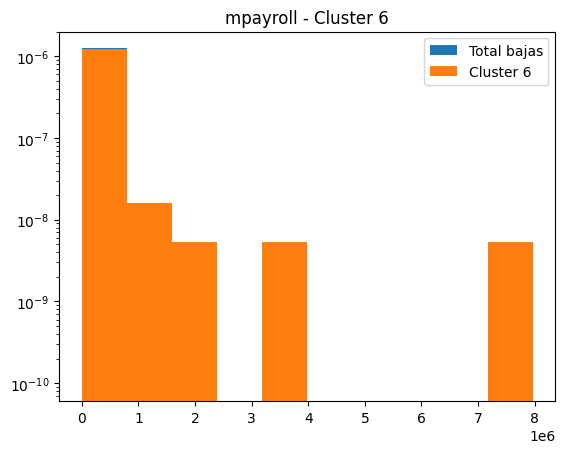

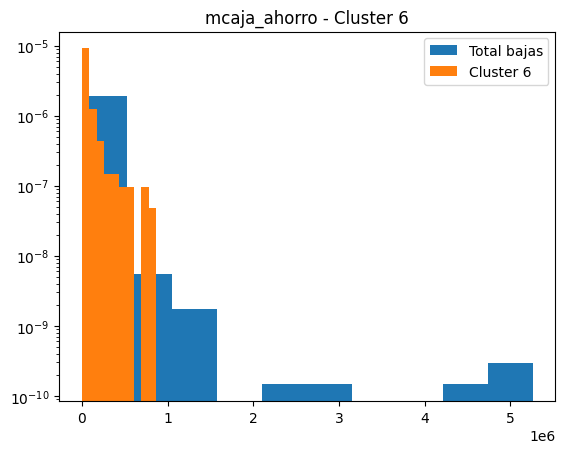

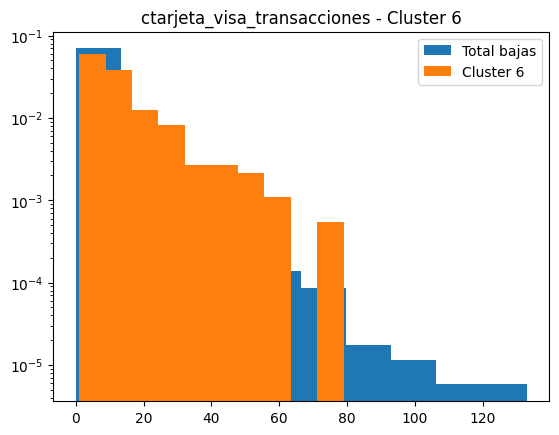

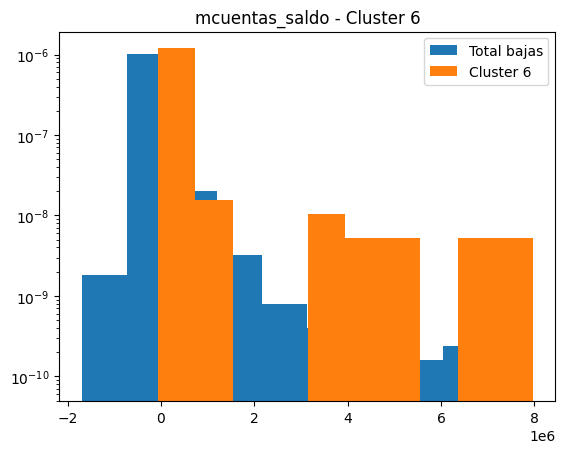

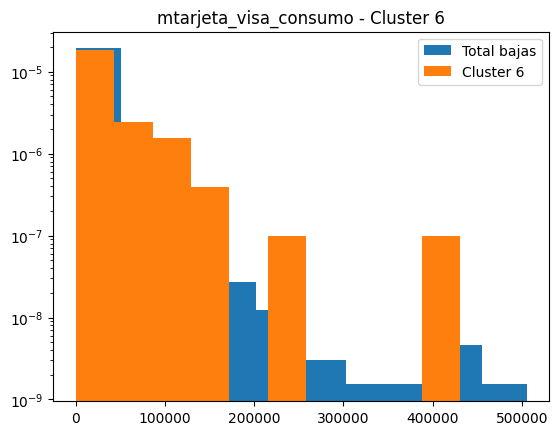

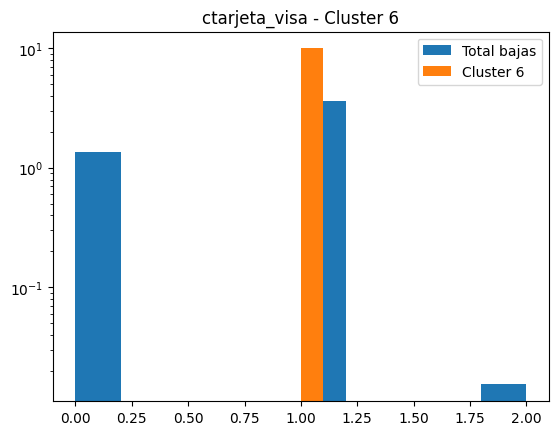

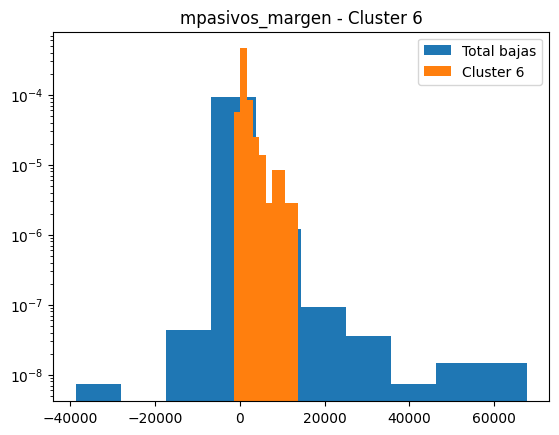

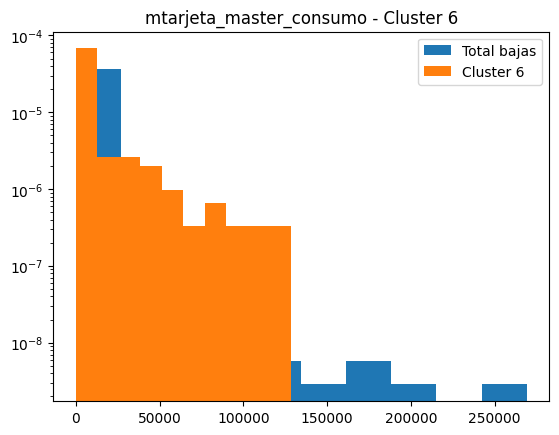

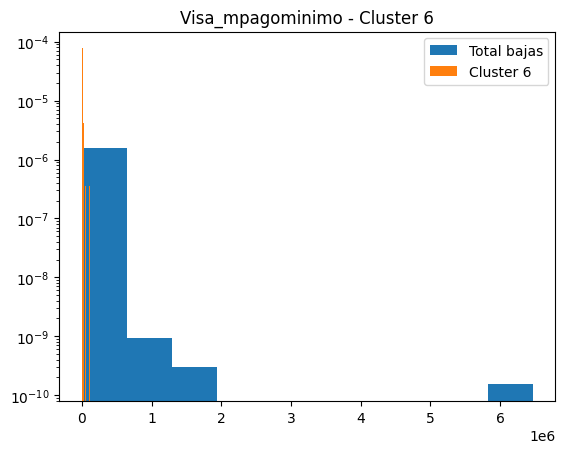

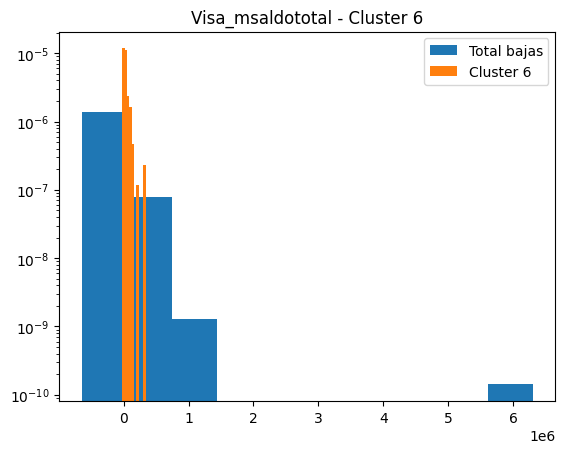

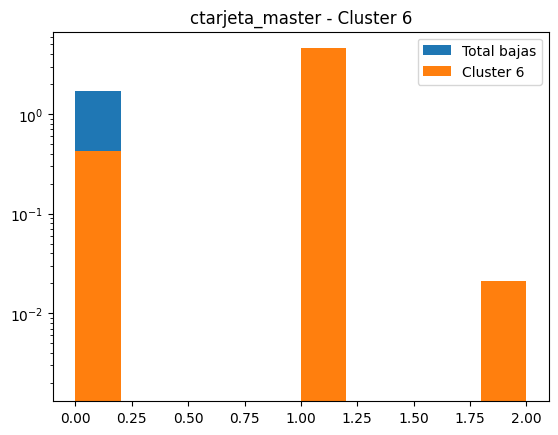

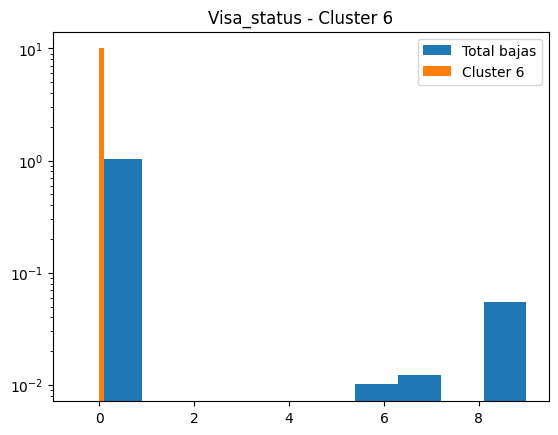

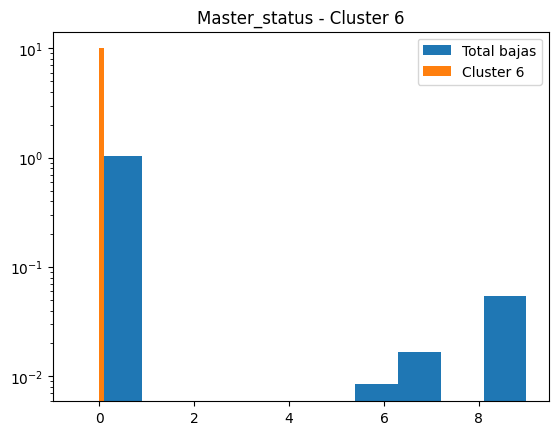

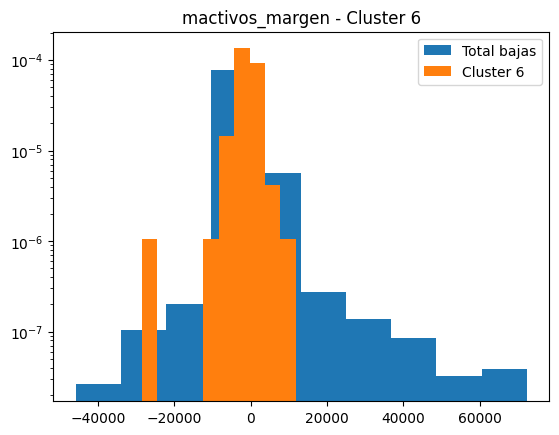

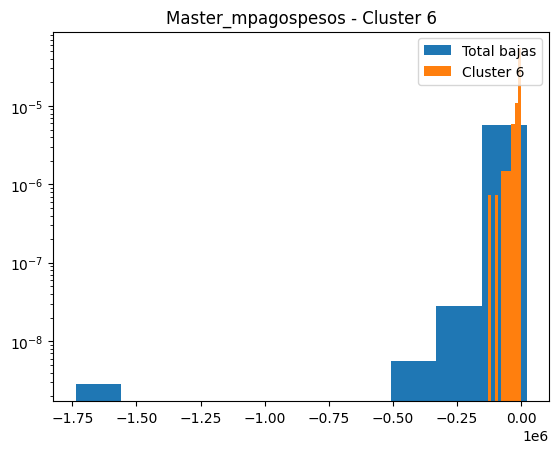

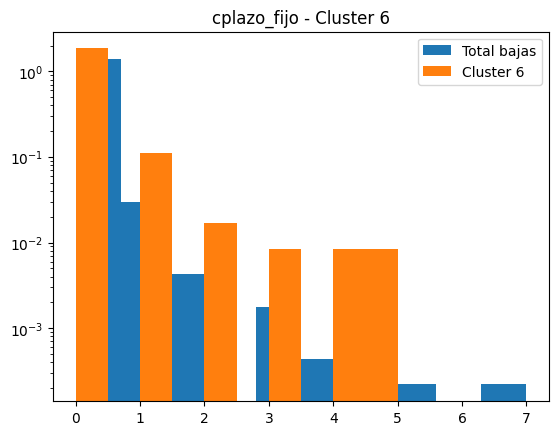

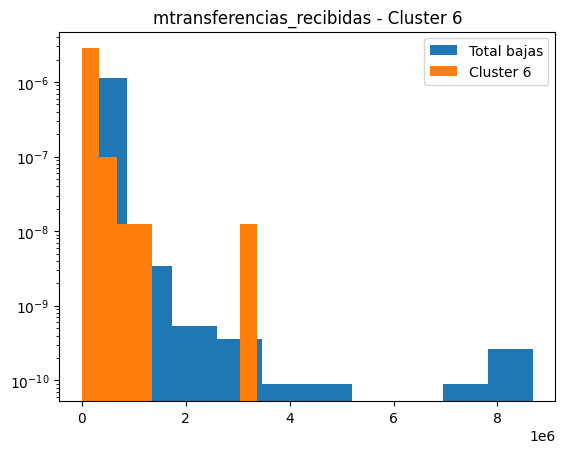

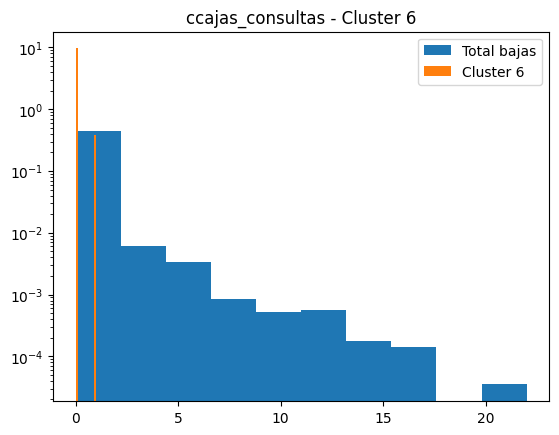

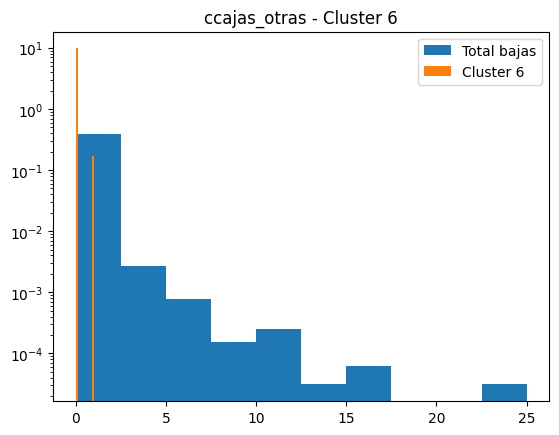

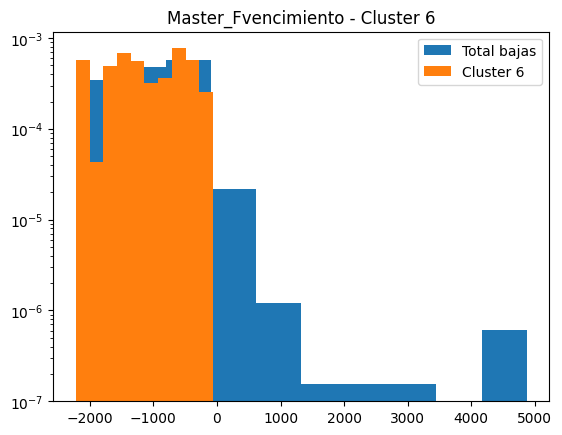

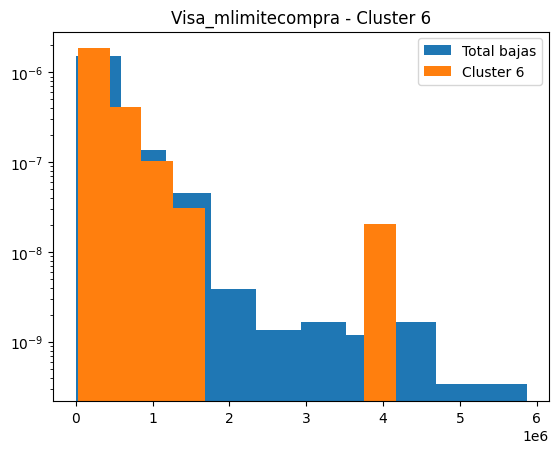

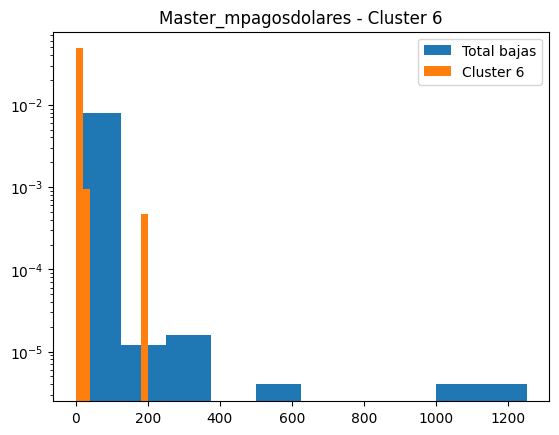

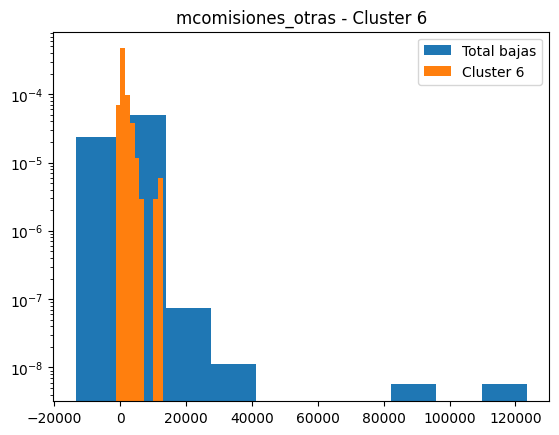

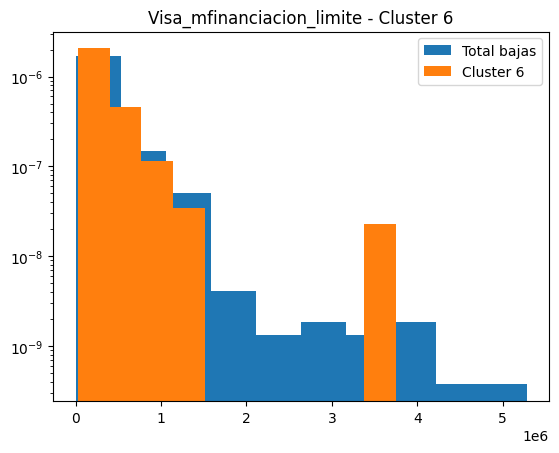

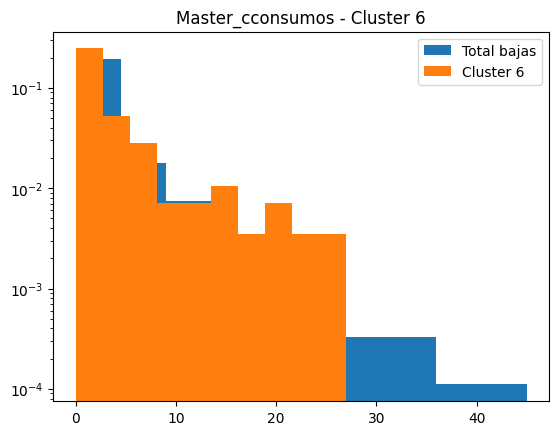

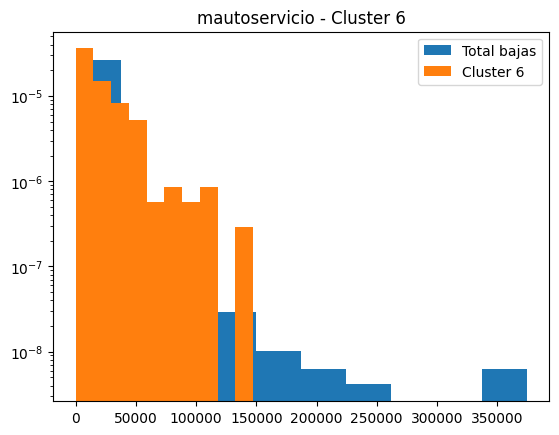

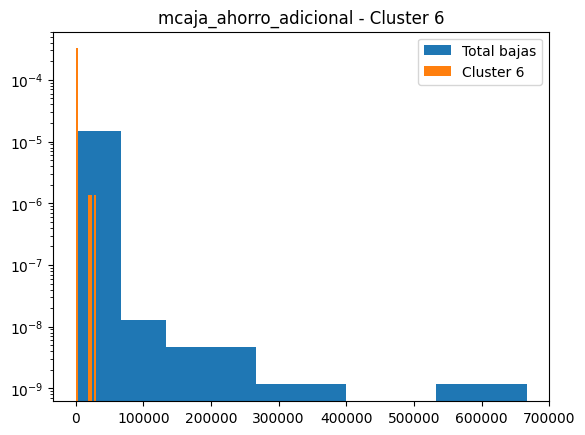

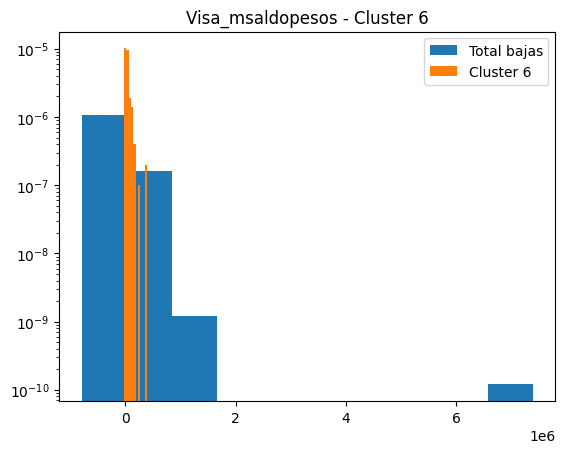

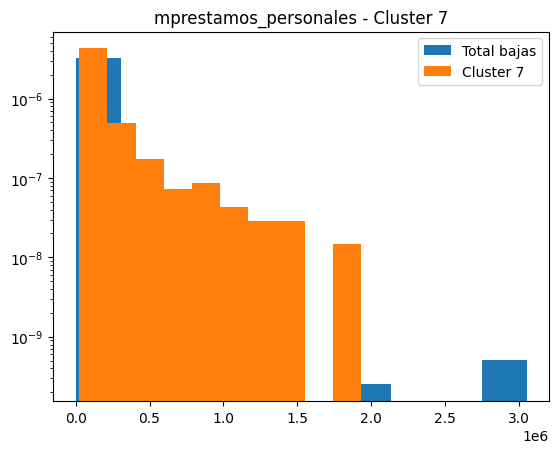

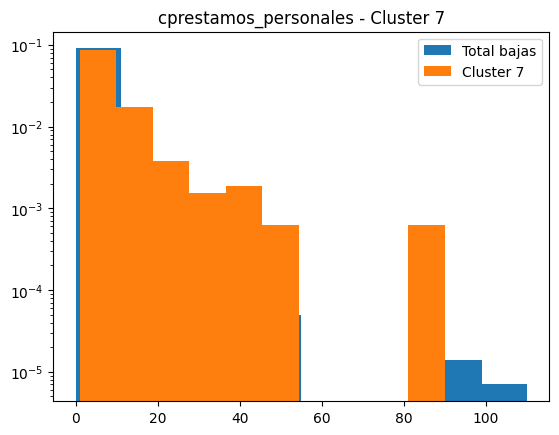

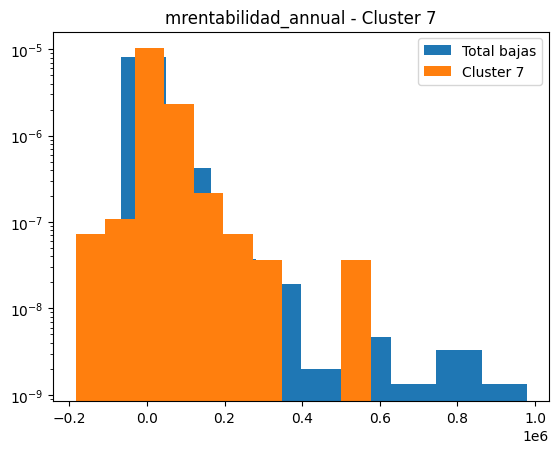

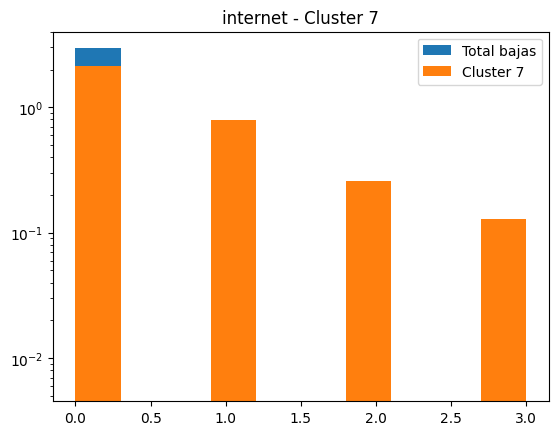

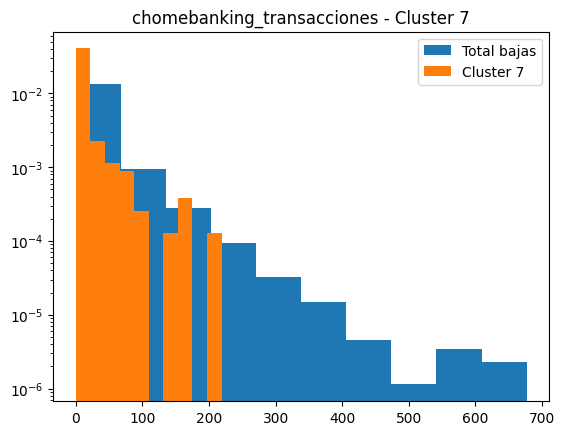

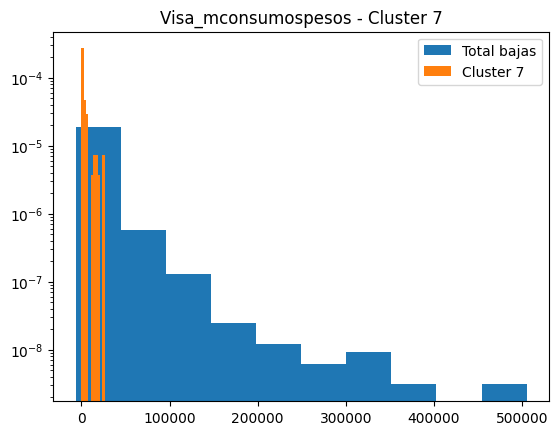

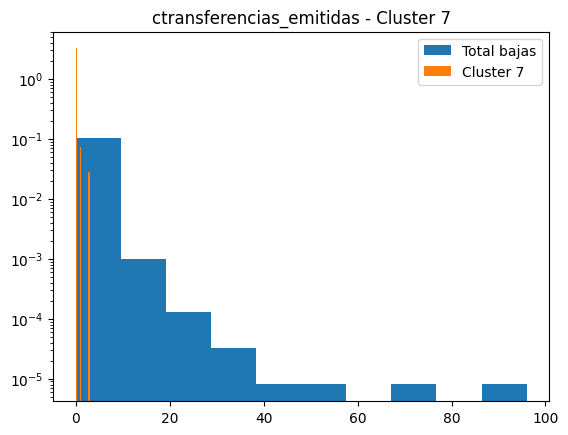

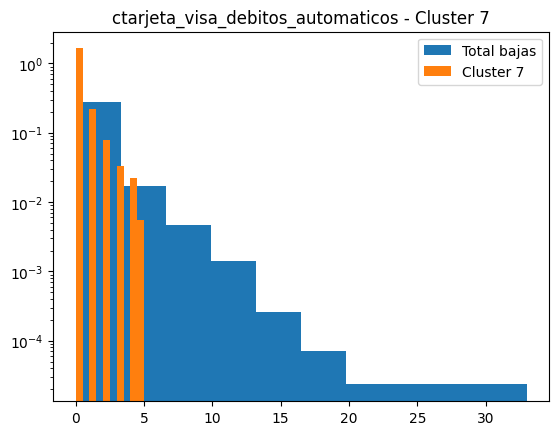

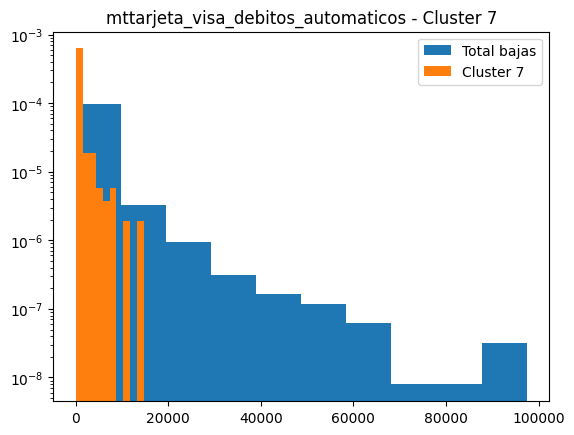

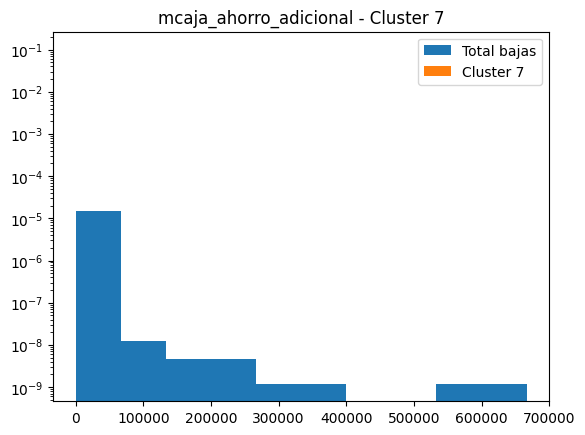

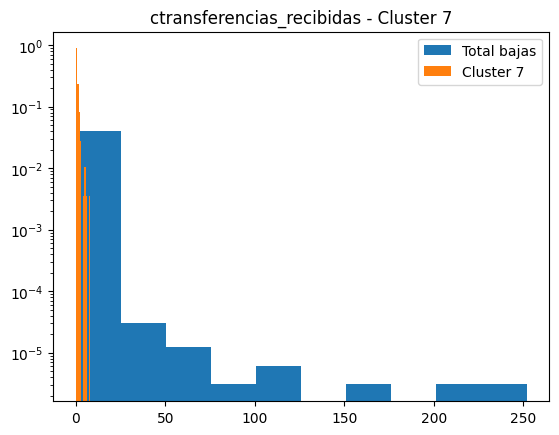

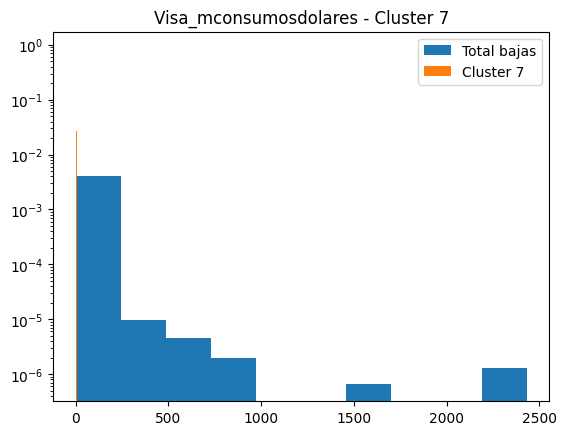

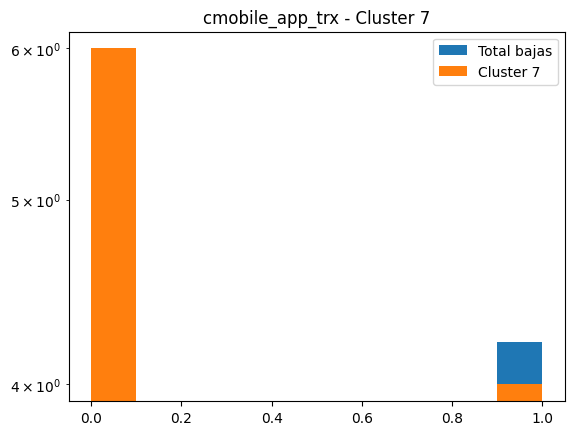

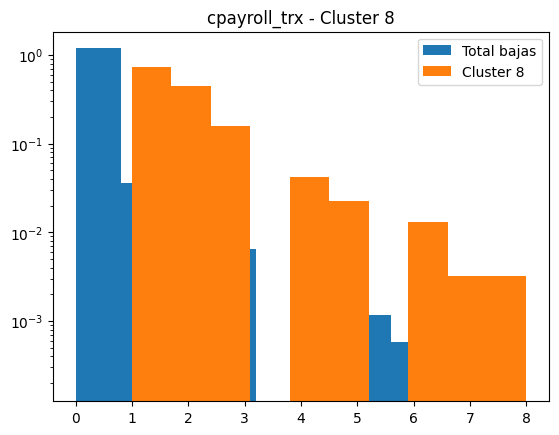

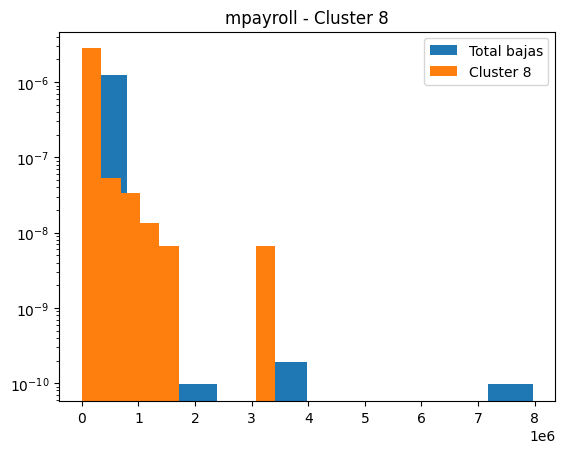

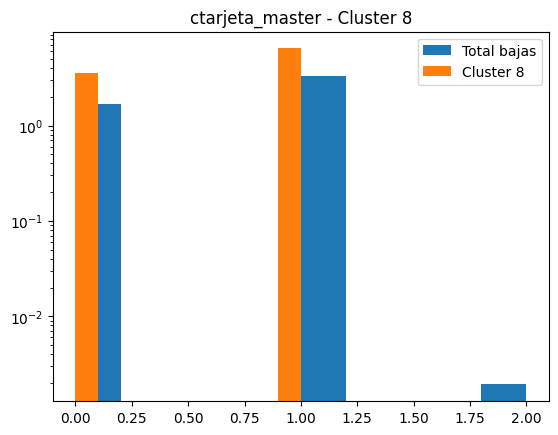

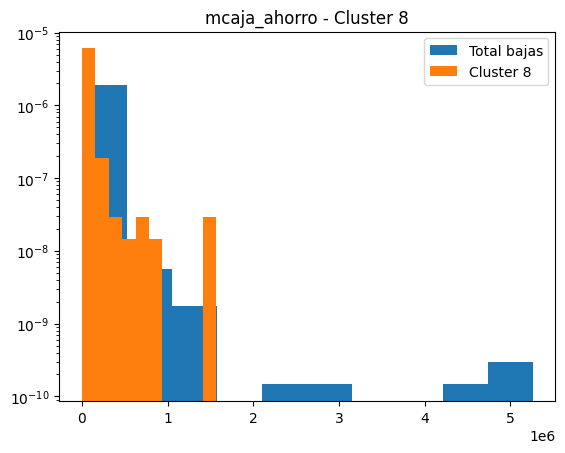

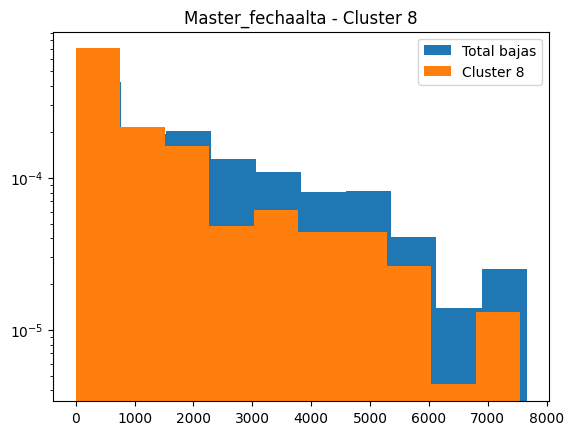

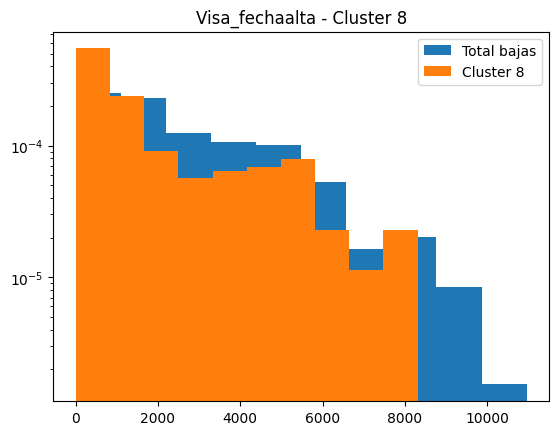

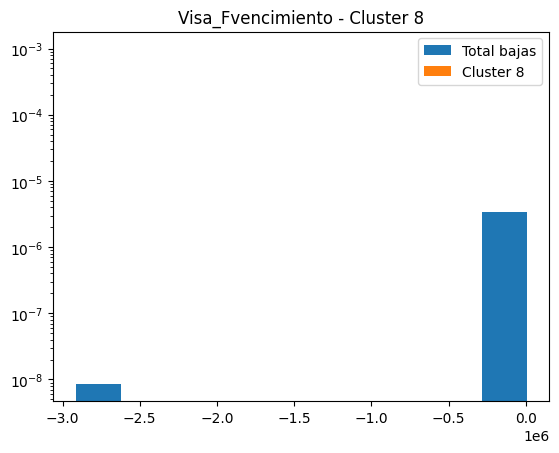

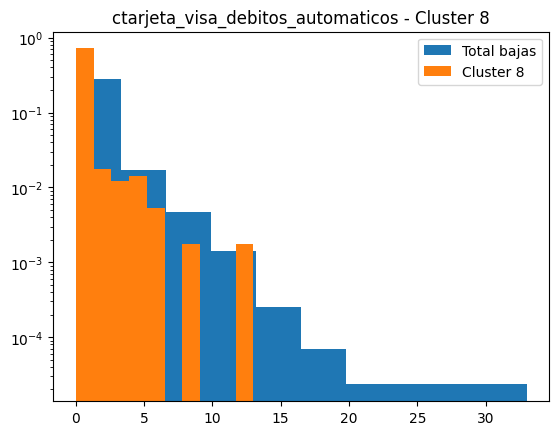

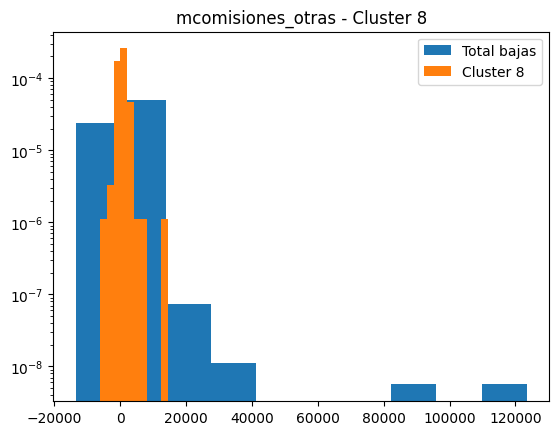

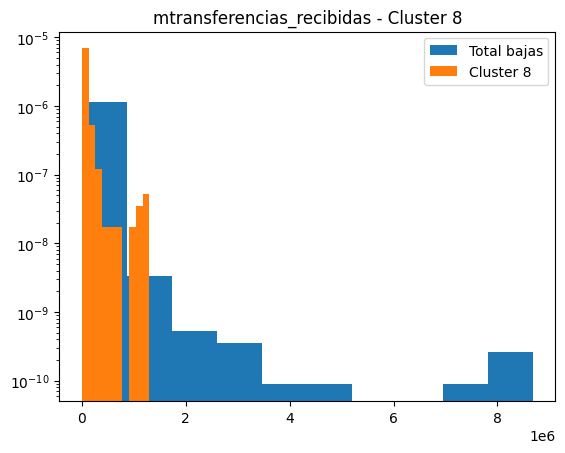

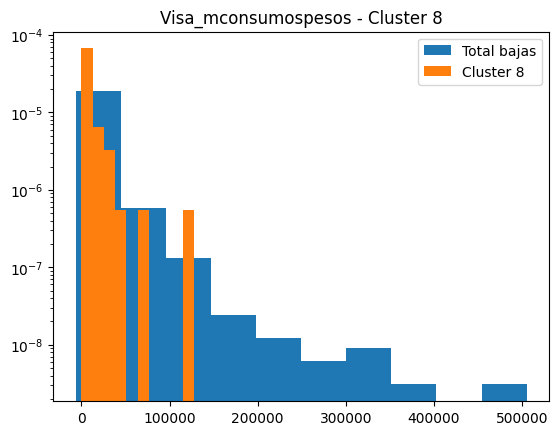

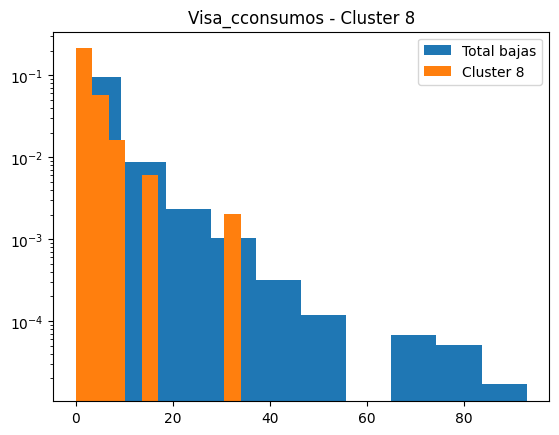

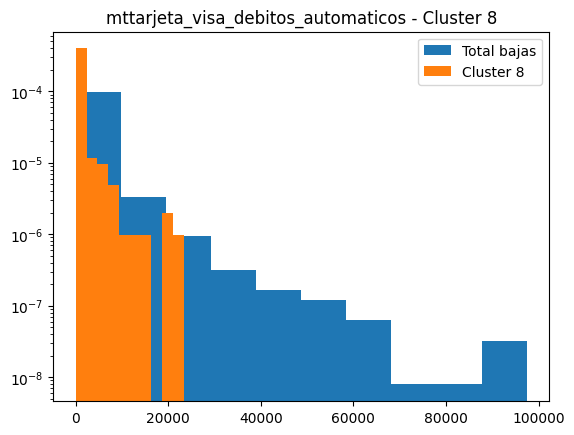

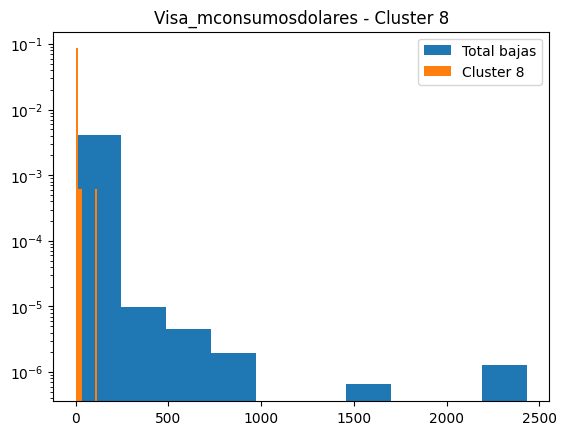

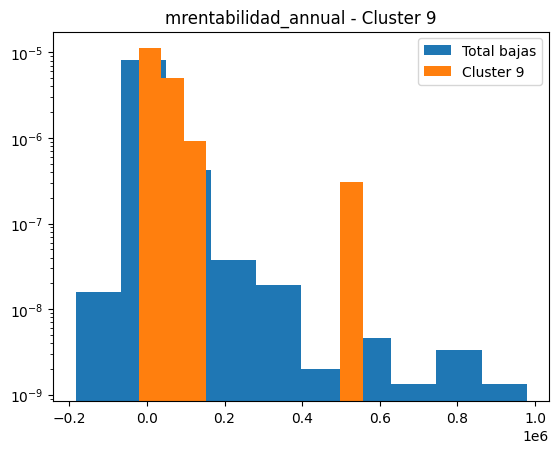

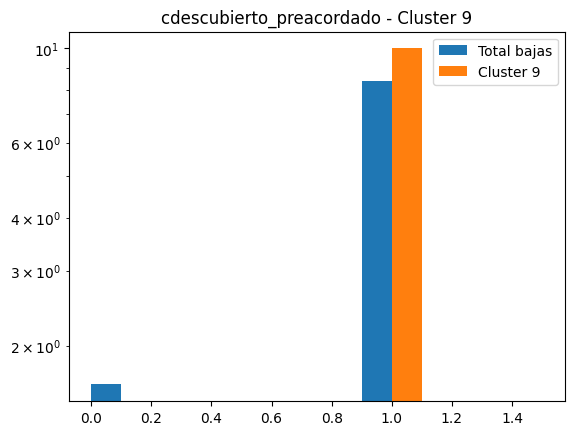

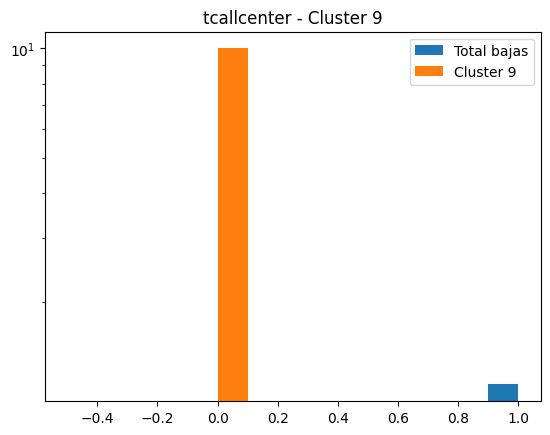

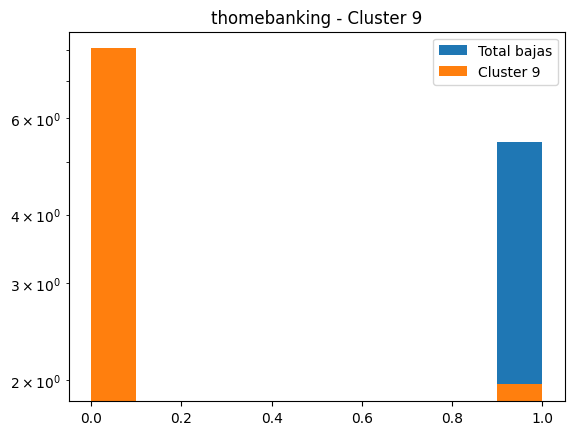

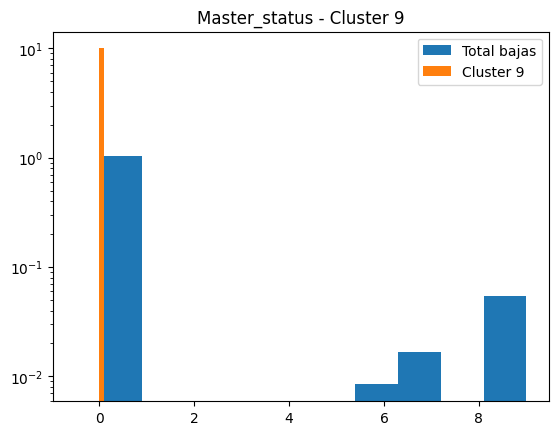

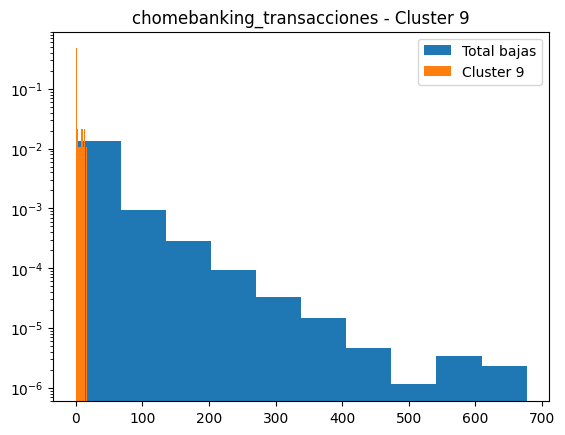

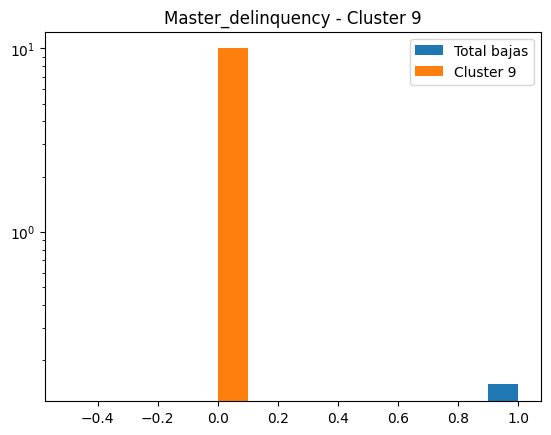

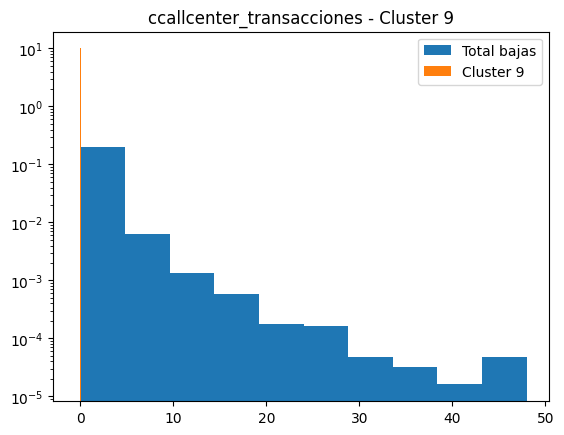

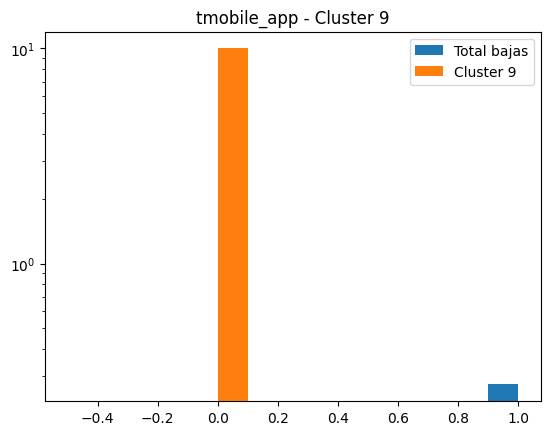

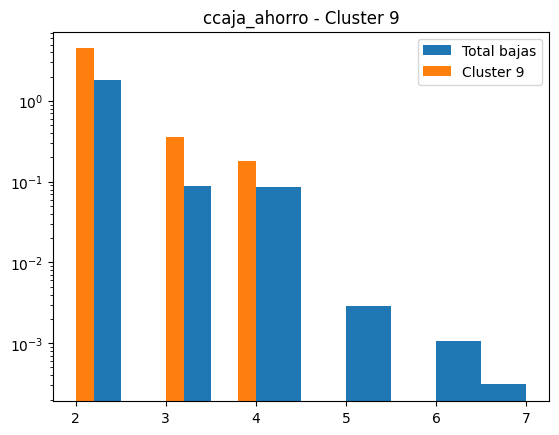

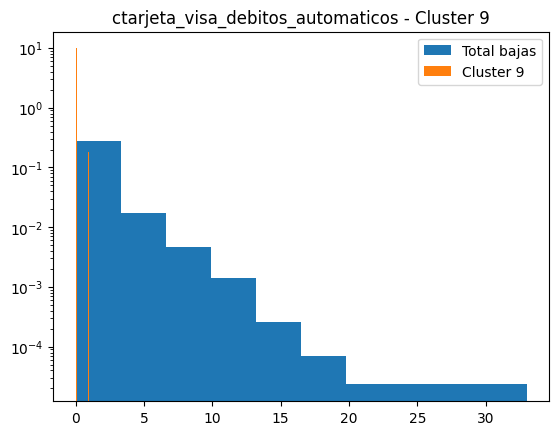

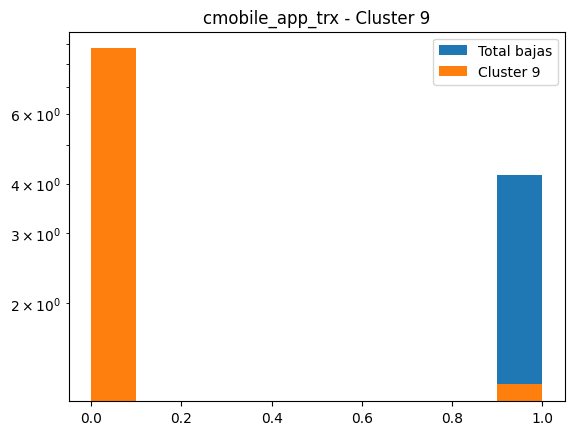

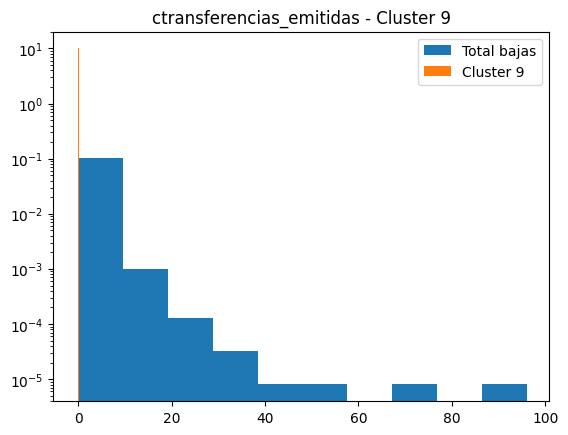

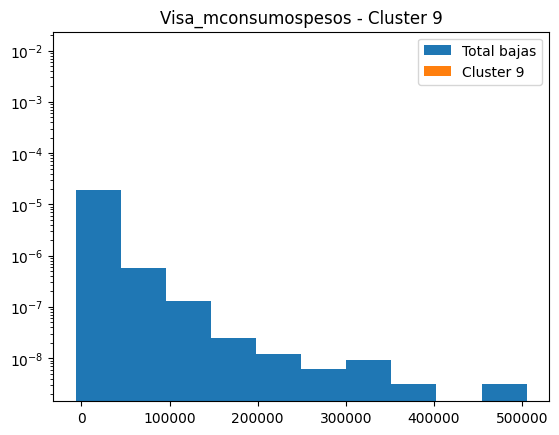

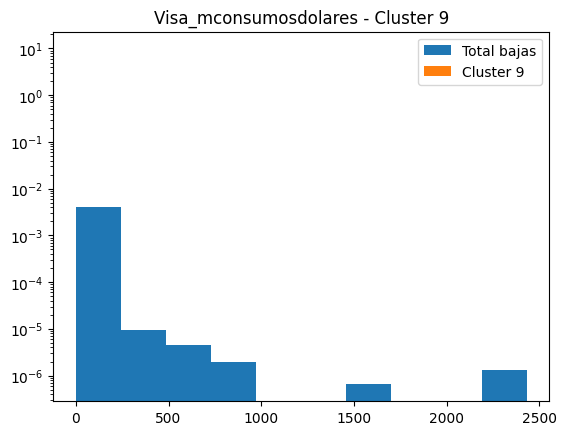

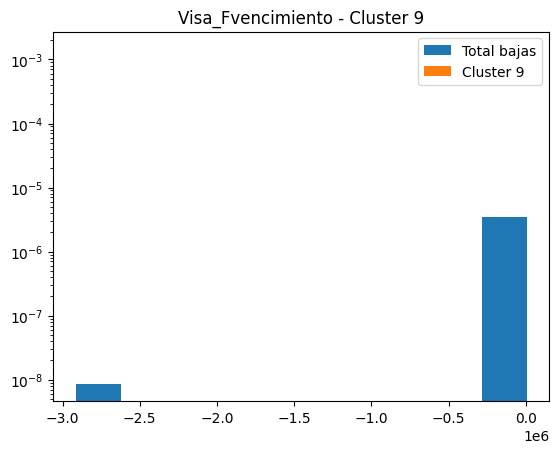

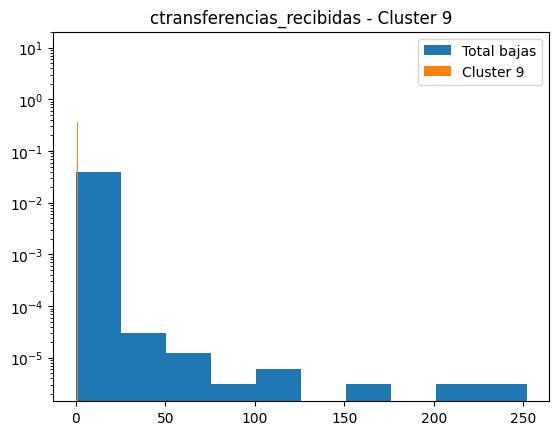

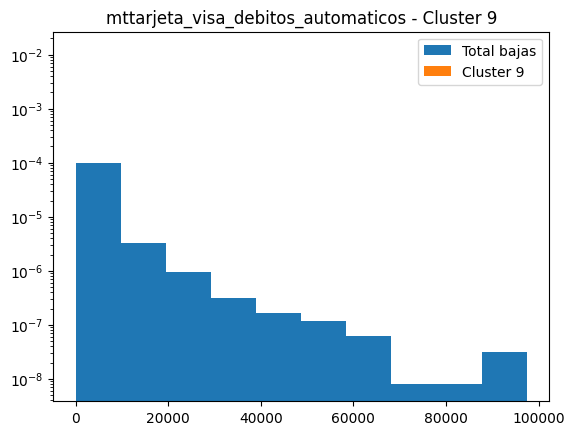

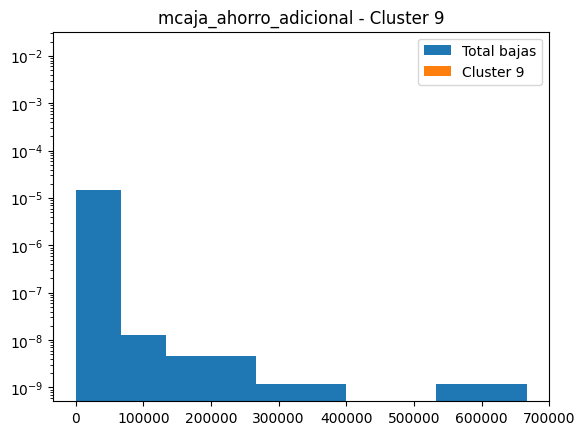

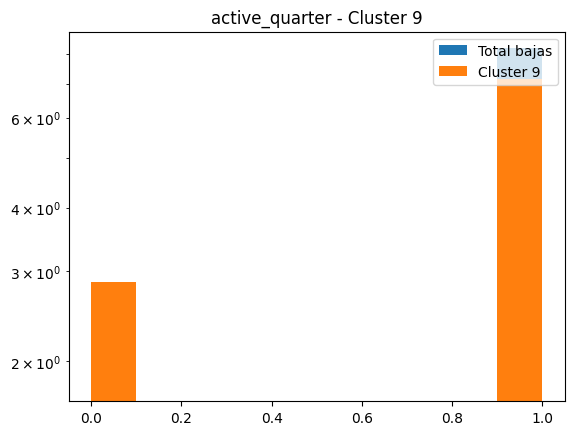

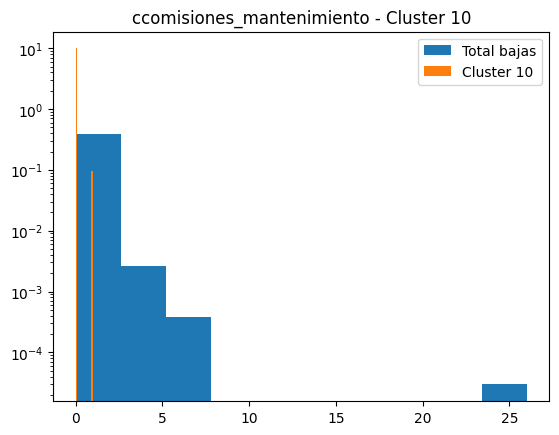

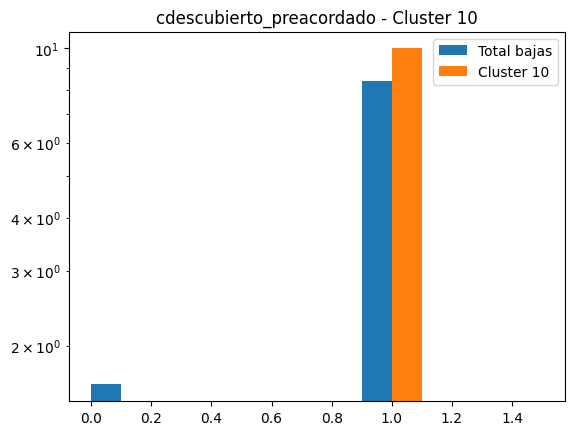

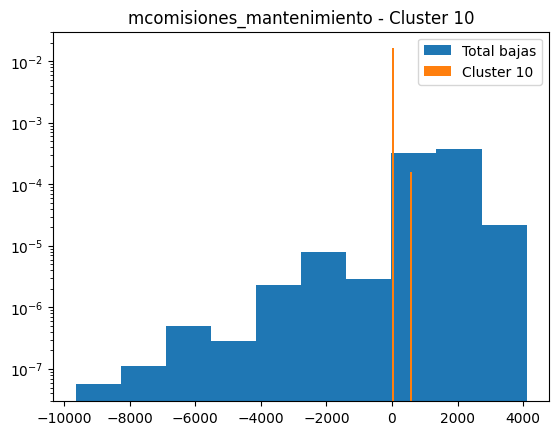

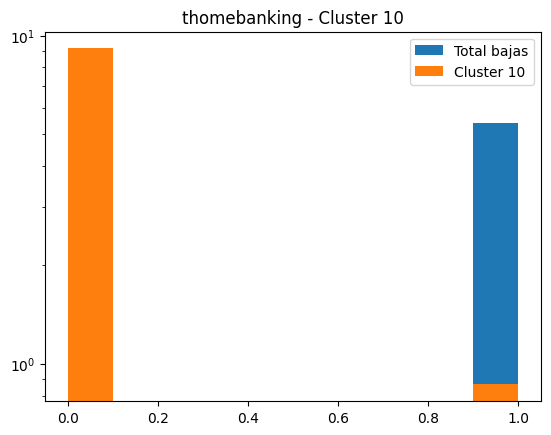

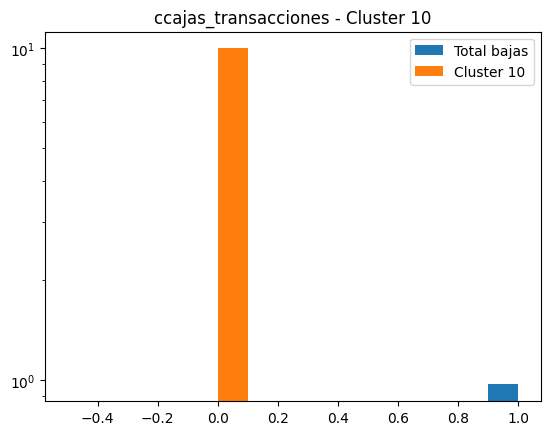

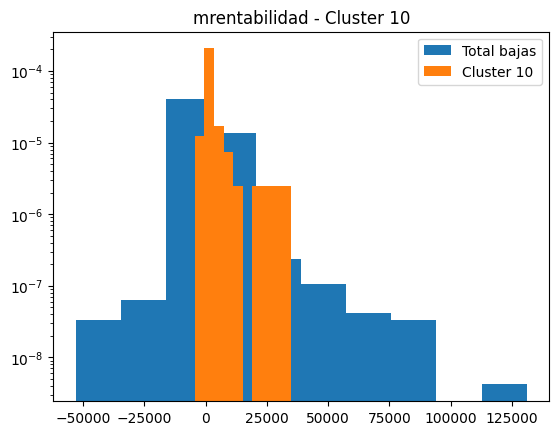

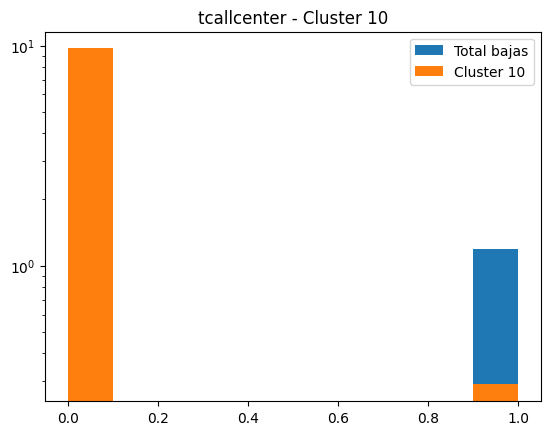

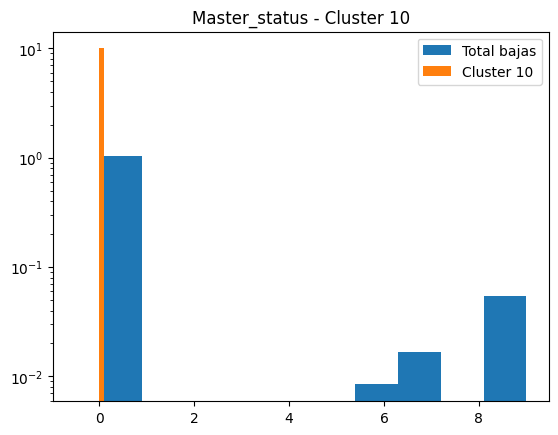

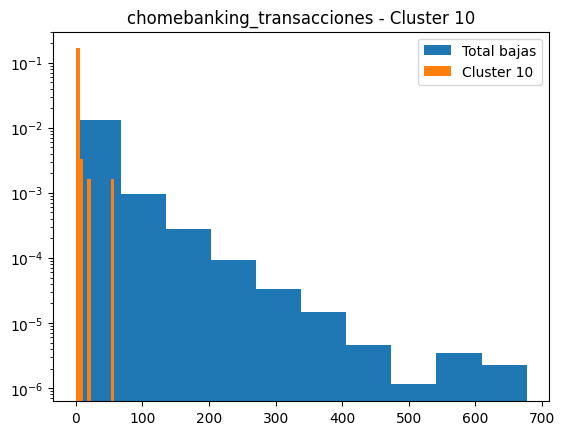

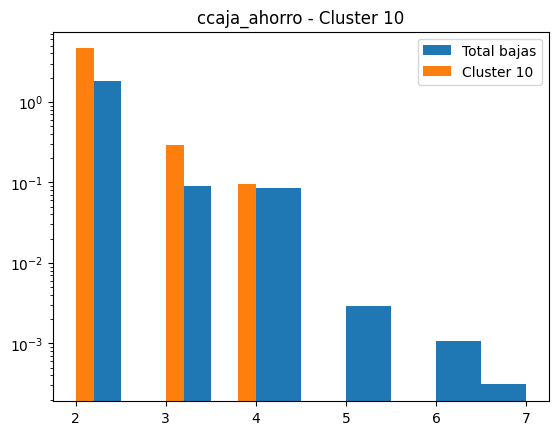

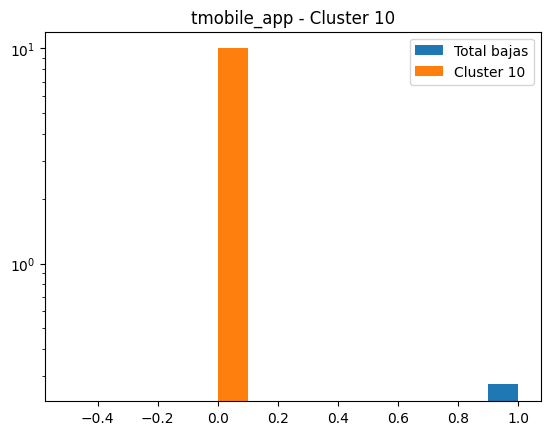

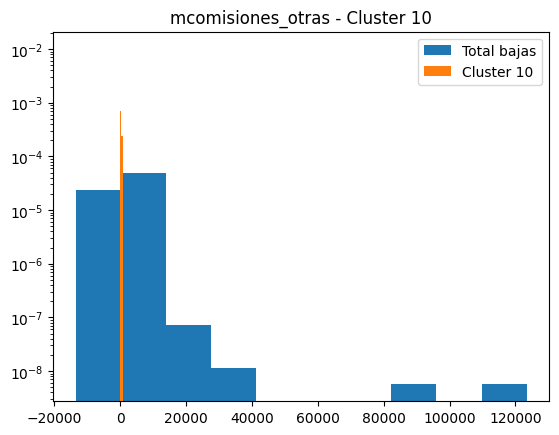

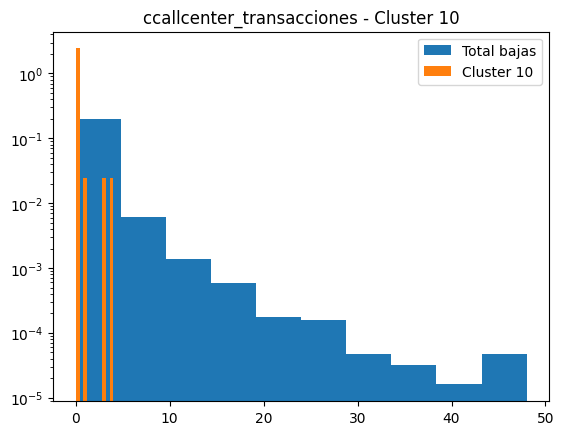

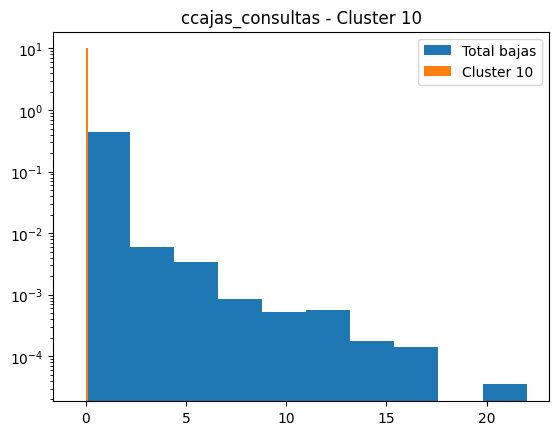

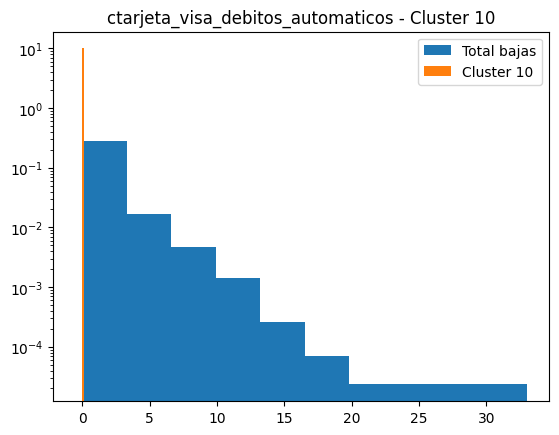

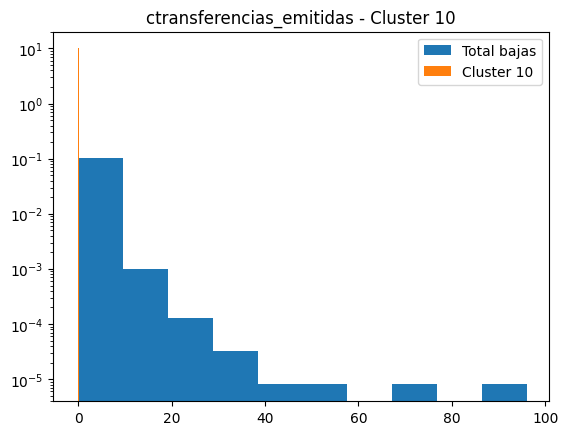

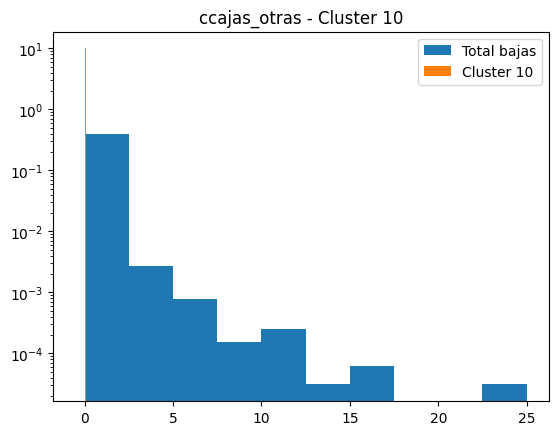

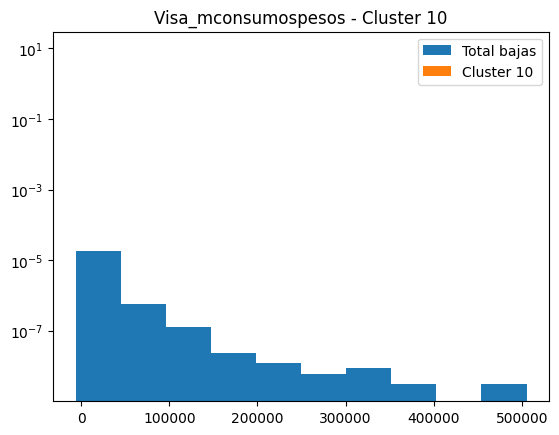

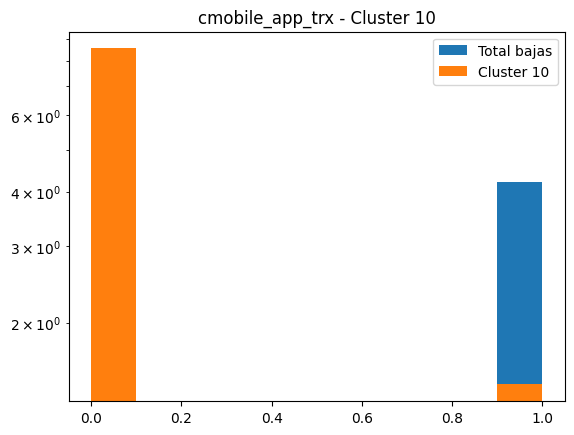

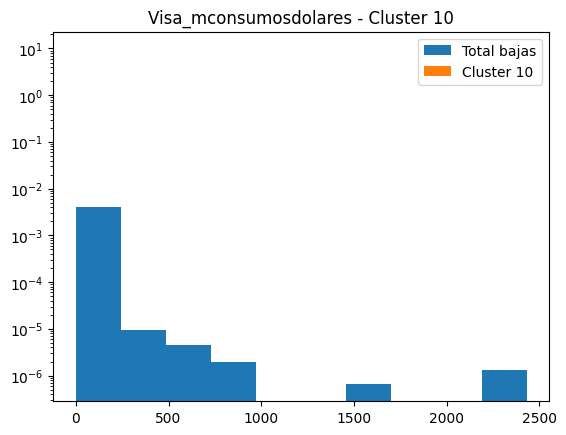

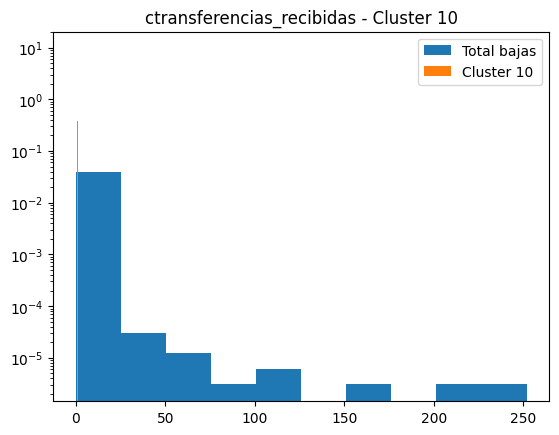

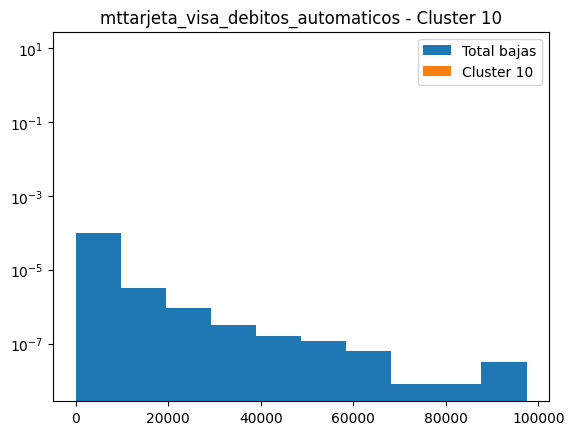

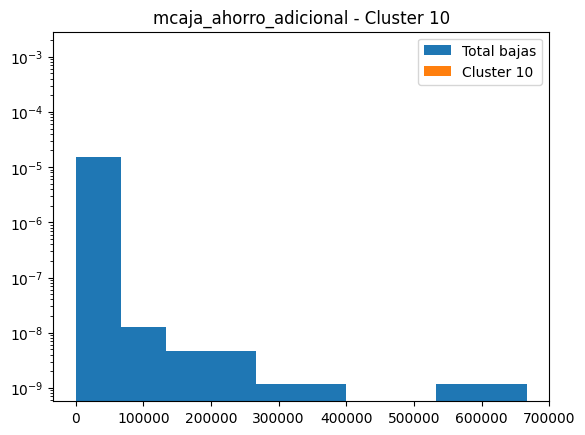

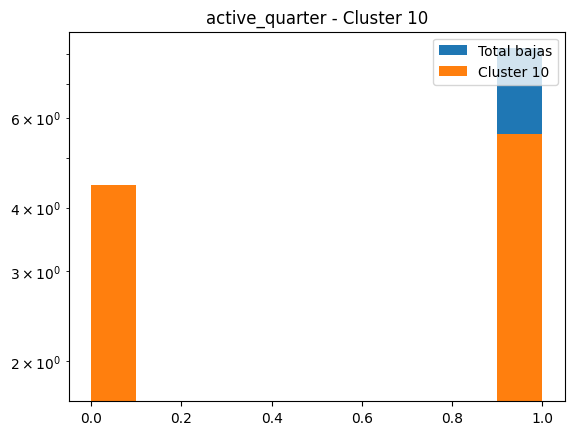

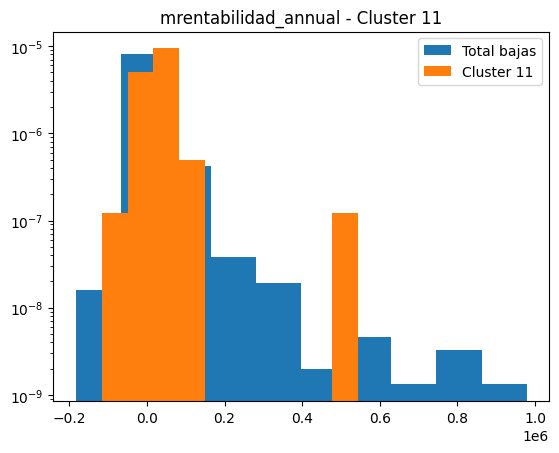

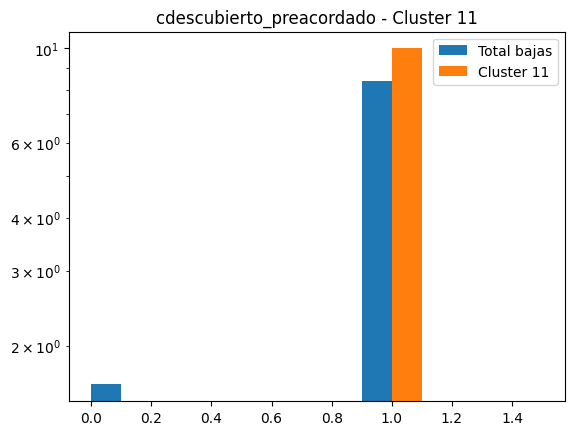

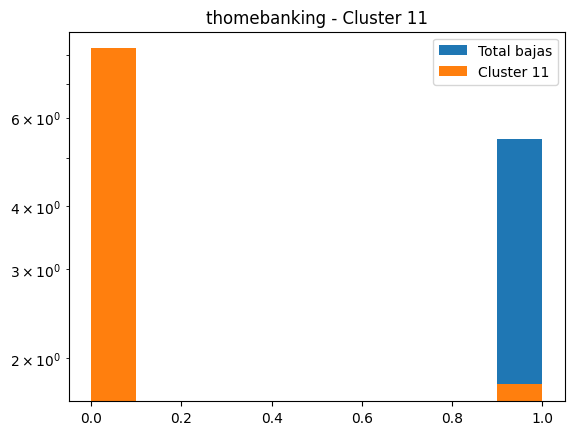

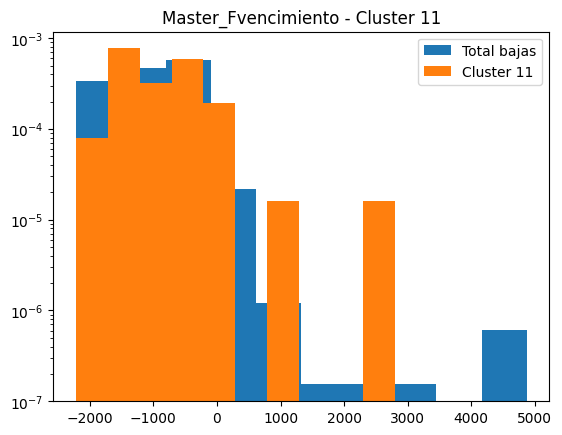

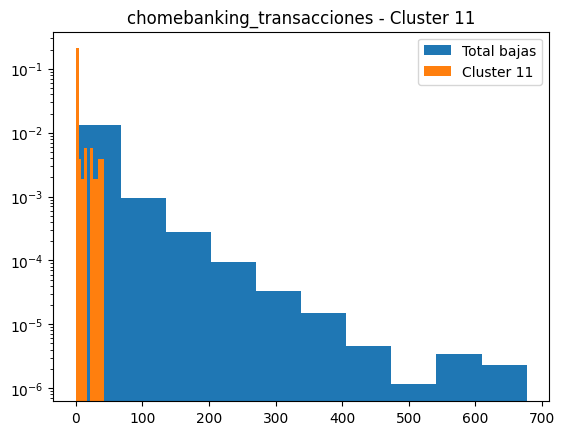

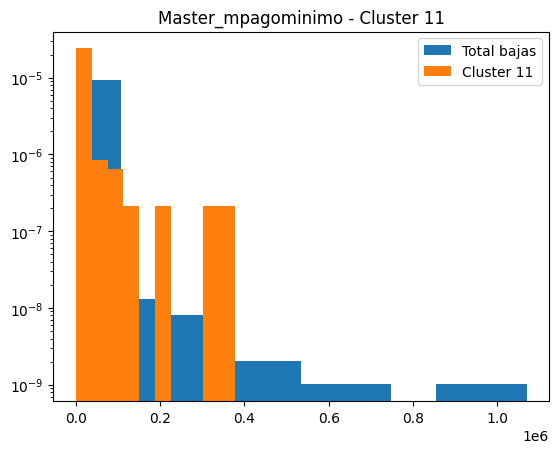

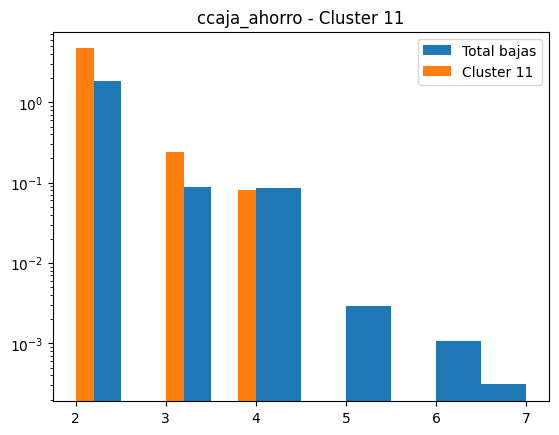

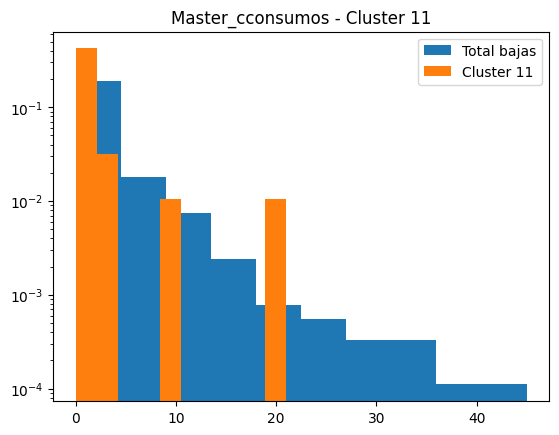

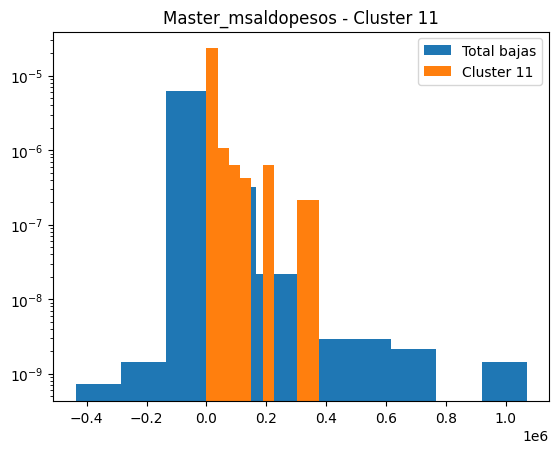

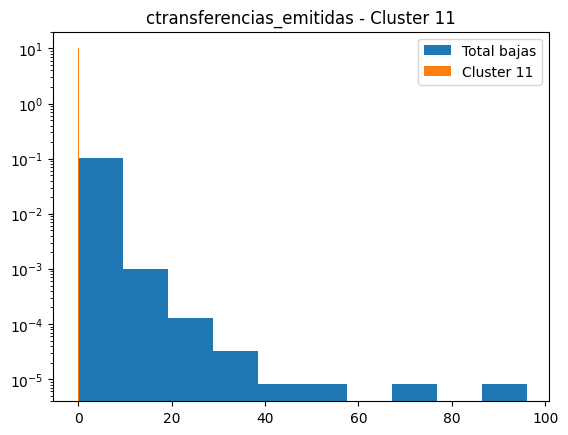

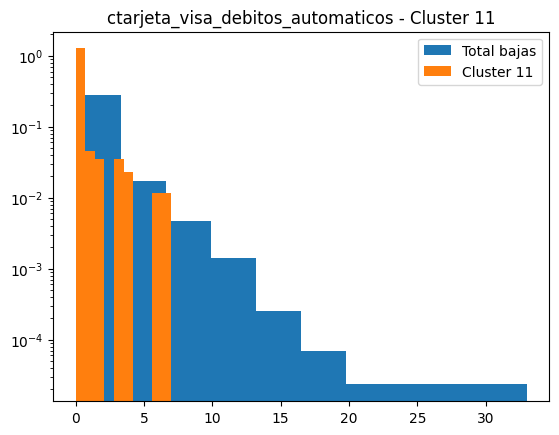

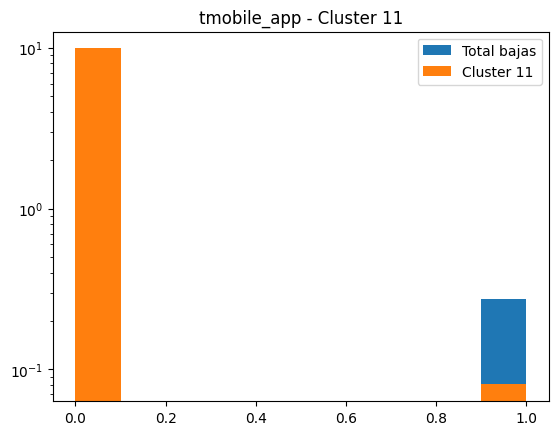

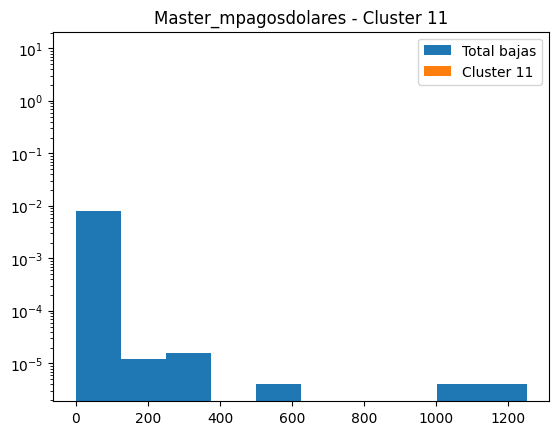

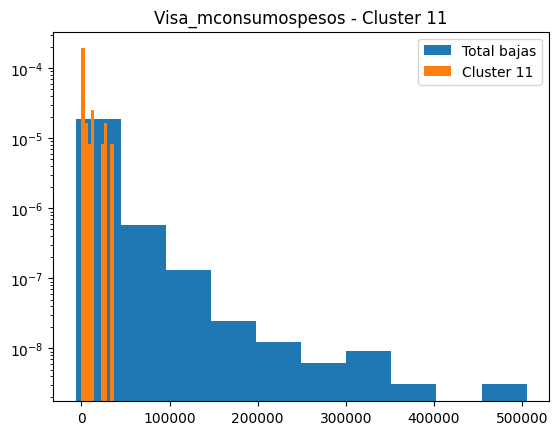

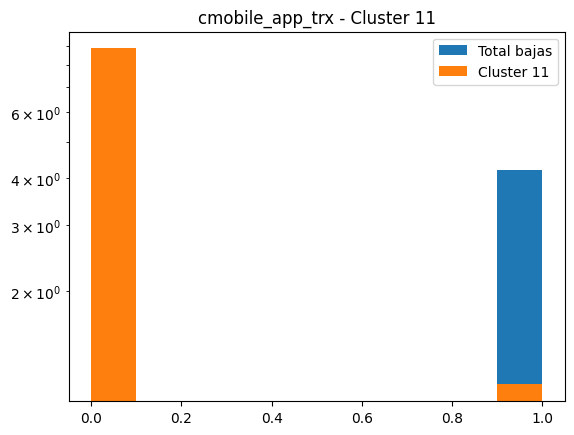

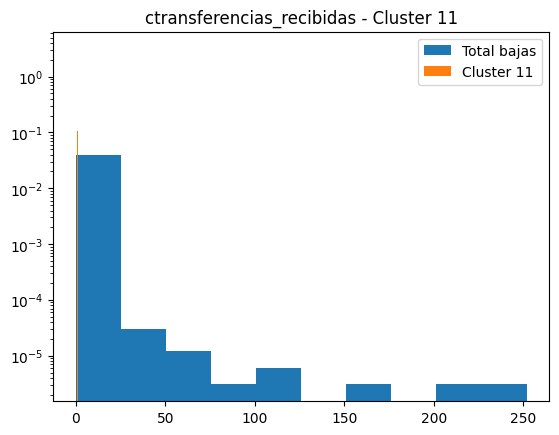

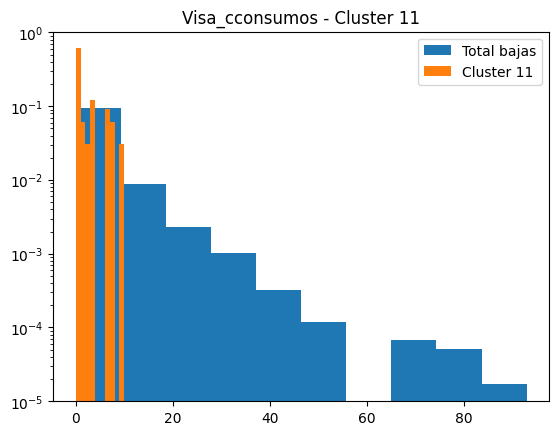

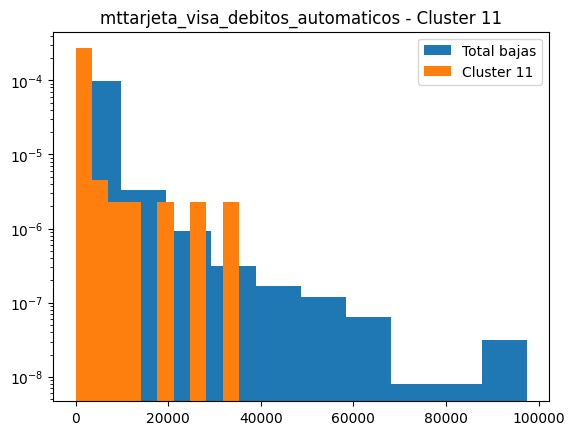

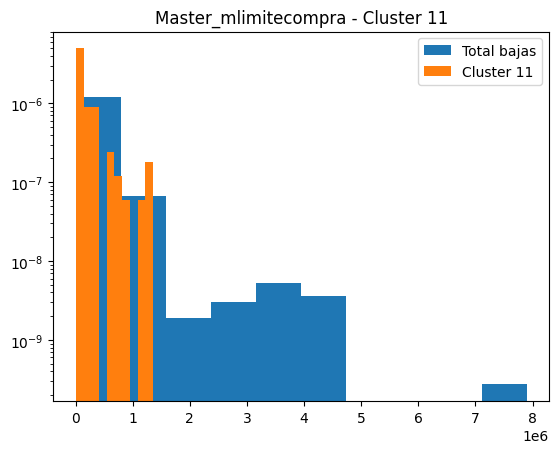

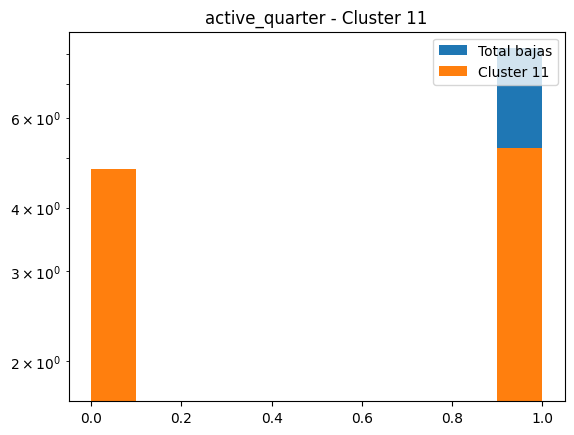

In [36]:
from matplotlib.backends.backend_pdf import PdfPages
# Recorrer el diccionario
for i, (cluster_label, variables) in enumerate(variables_por_cluster.items()):
    pdf_pages = PdfPages(f'C:/Users/vanes/Documents/UBA/2do_cuatrimestre/DMEyF/graficos_{i}.pdf')
    for j, variable in enumerate(variables):
        plt.figure()
        plt.yscale('log')
        plt.hist(ds_bajas.loc[:][variable], label='Total bajas', density=True, bins=10)
        plt.hist(ds_bajas.loc[y.labels_ == cluster_label][variable], label=f'Cluster {cluster_label}', density=True, bins=10)
        plt.legend(loc='upper right')
        plt.title(f'{variable} - Cluster {cluster_label}')
        pdf_pages.savefig()
    pdf_pages.close()

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


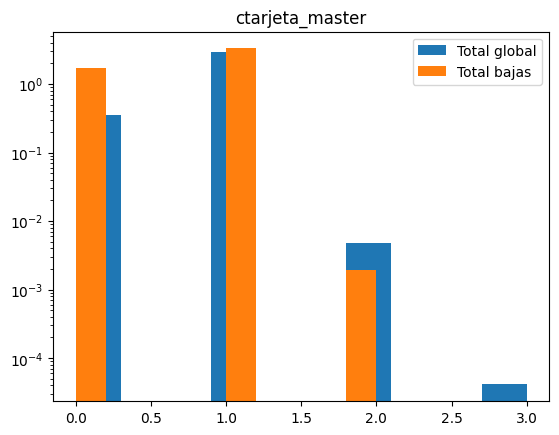

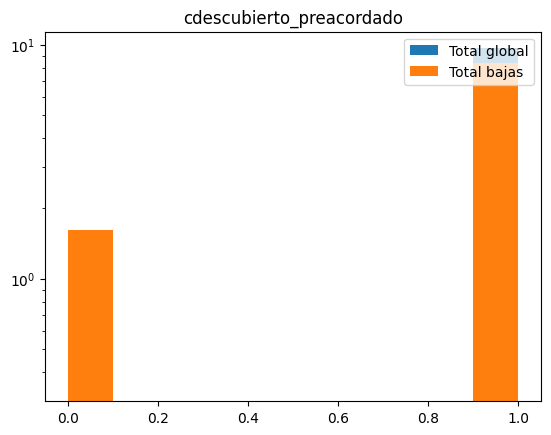

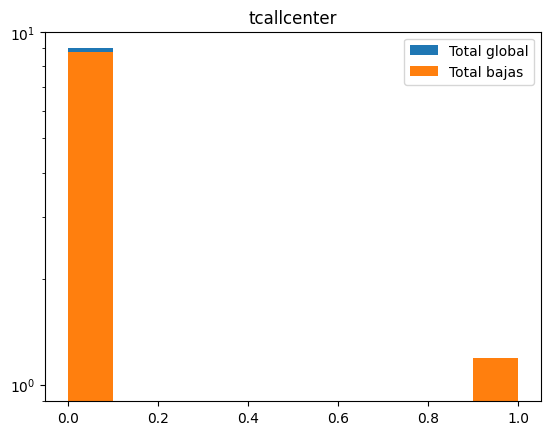

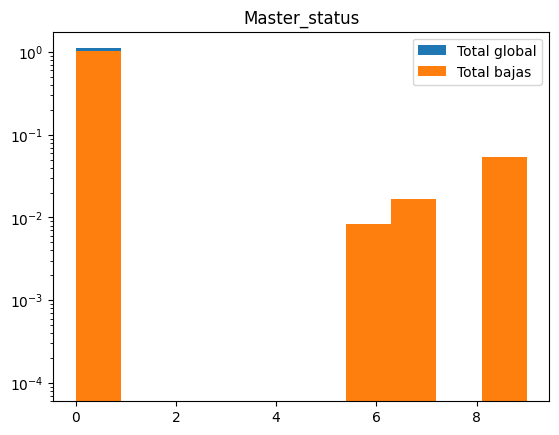

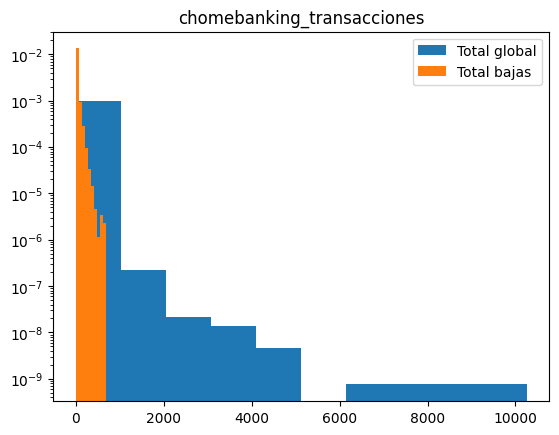

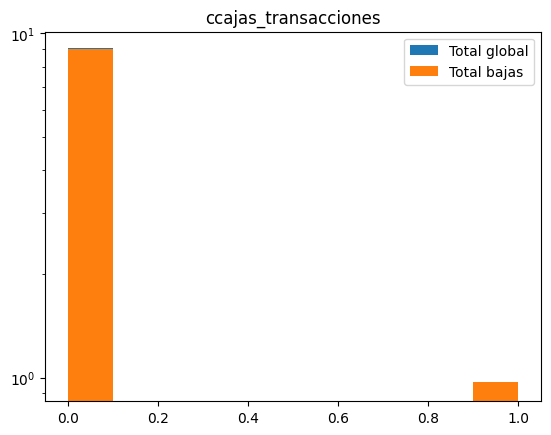

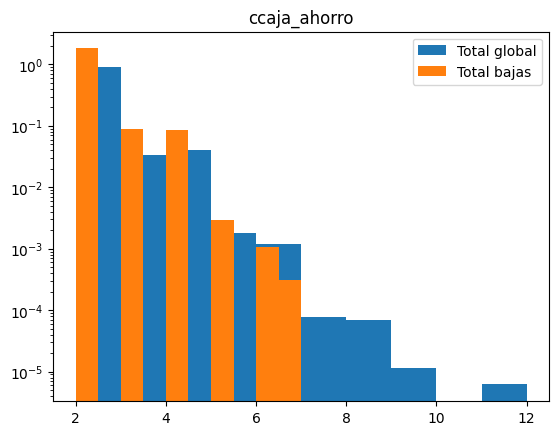

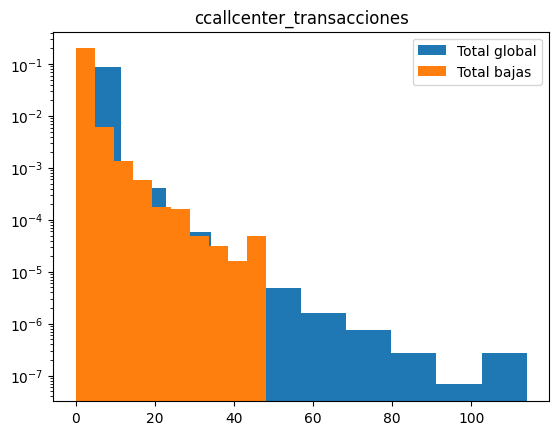

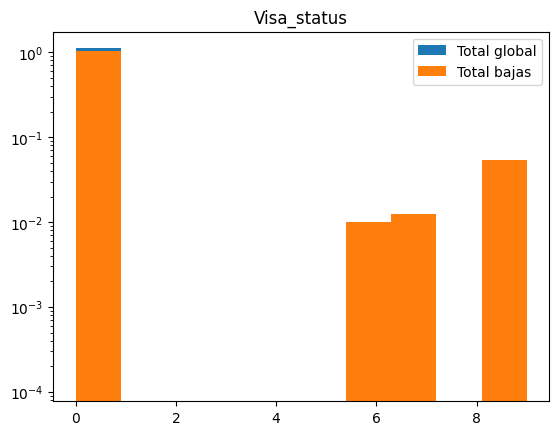

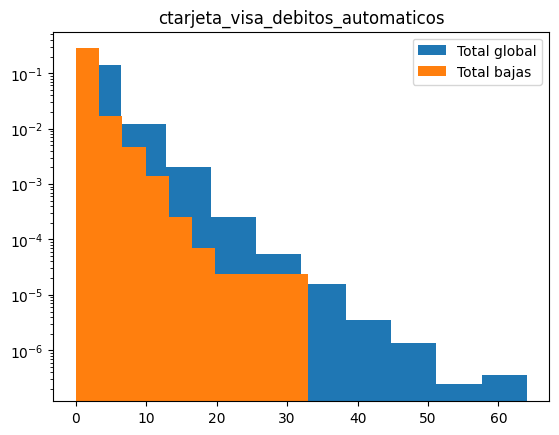

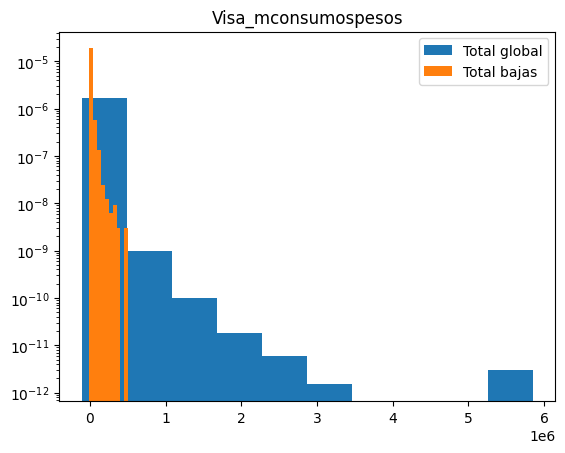

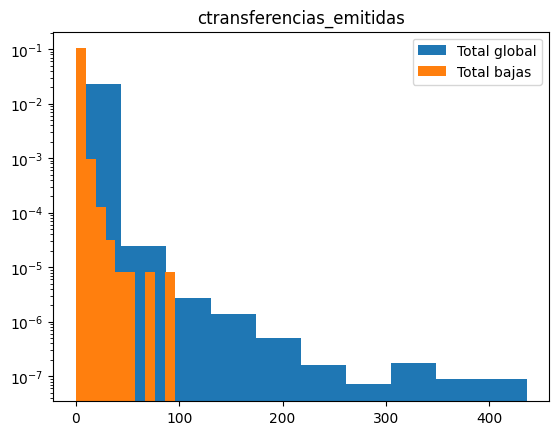

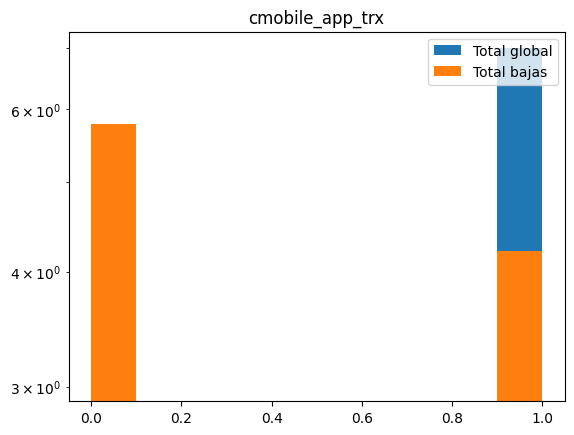

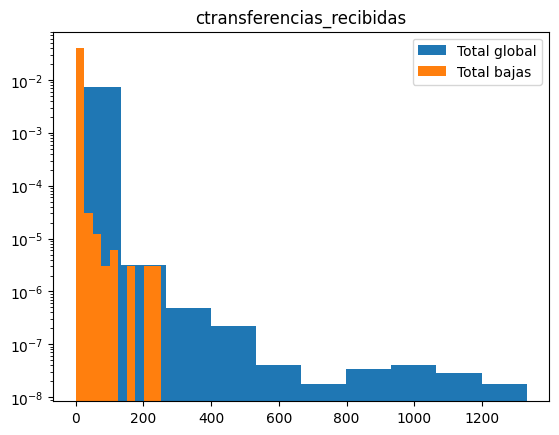

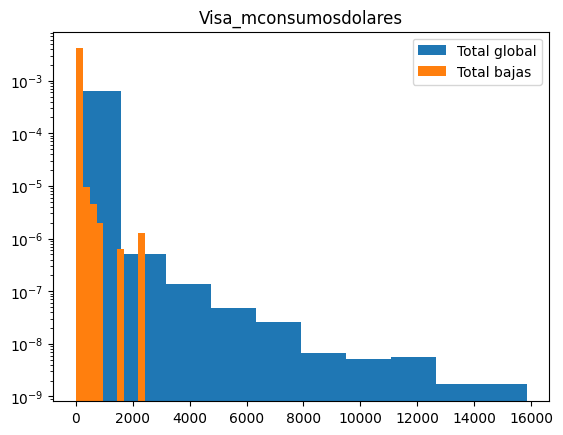

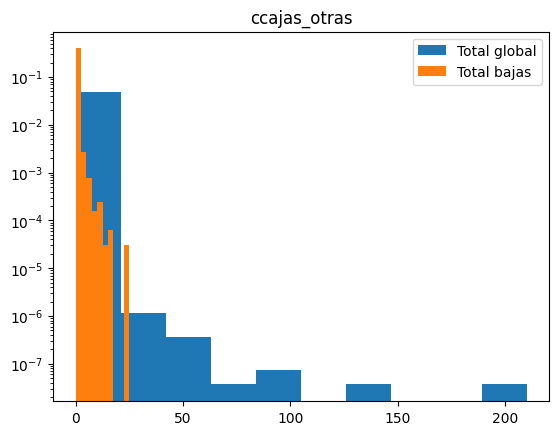

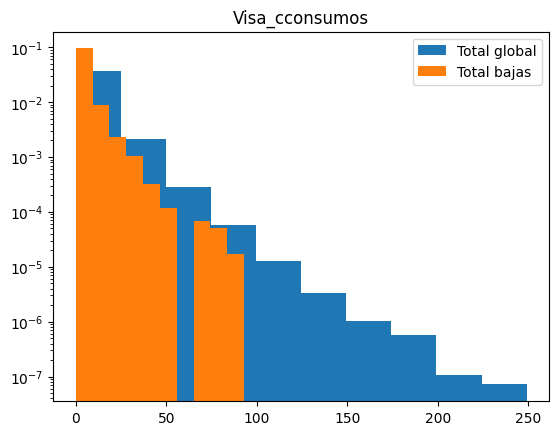

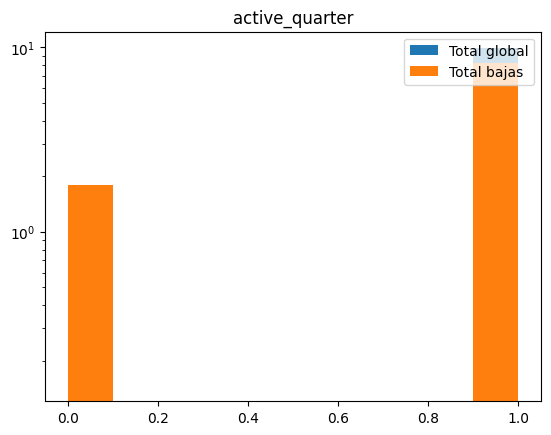

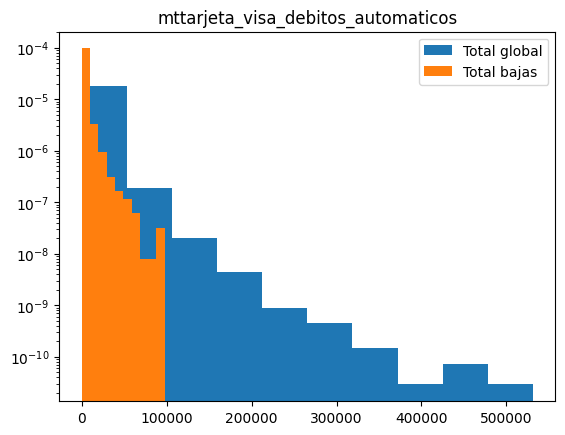

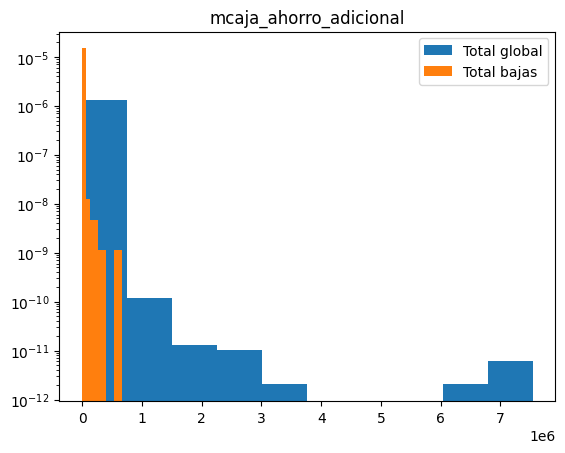

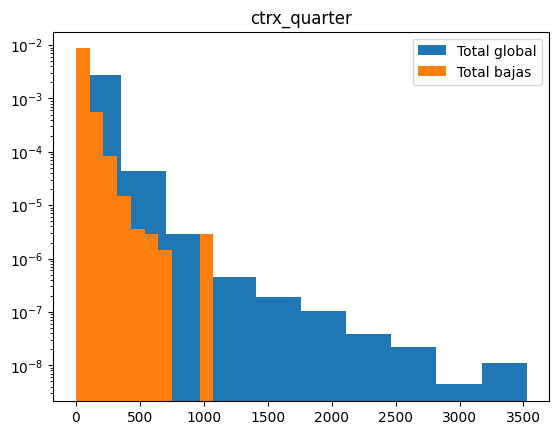

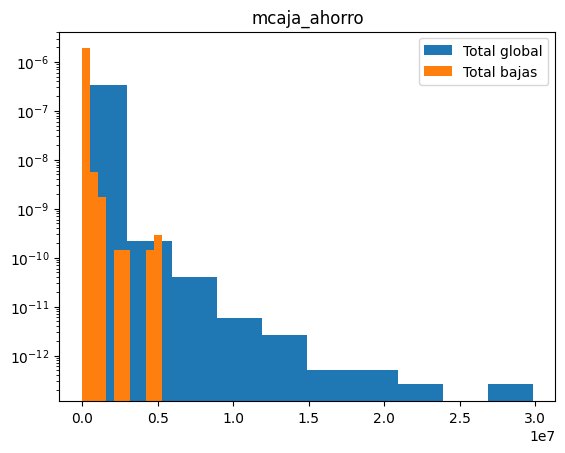

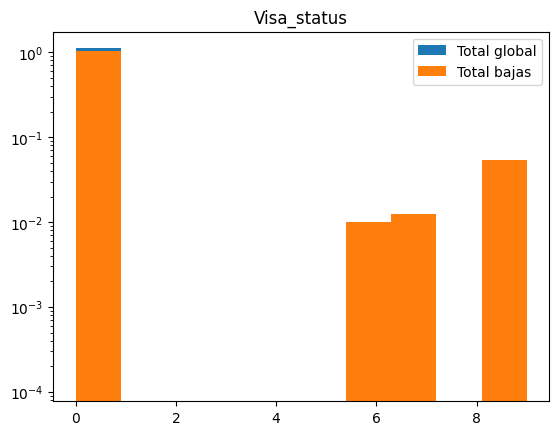

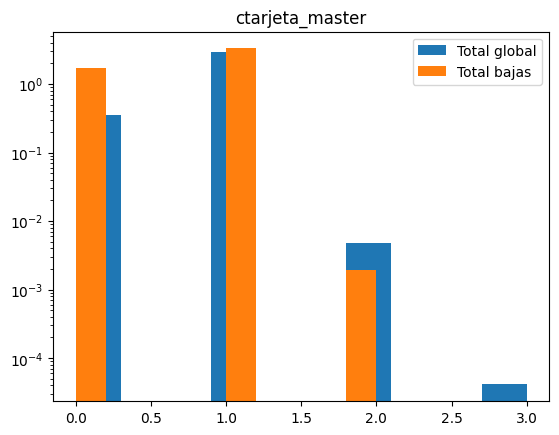

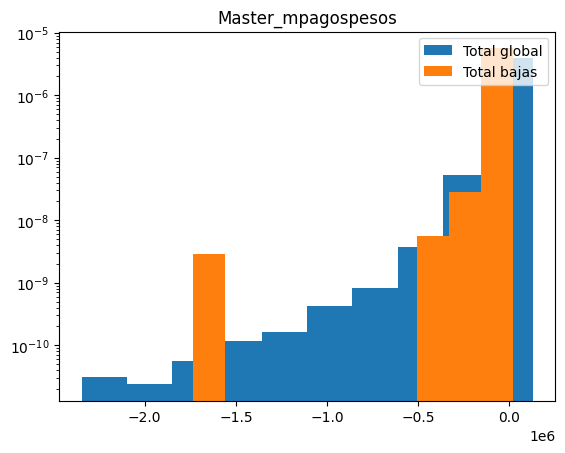

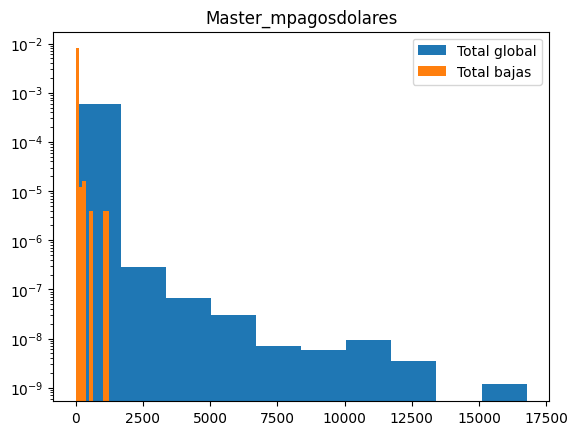

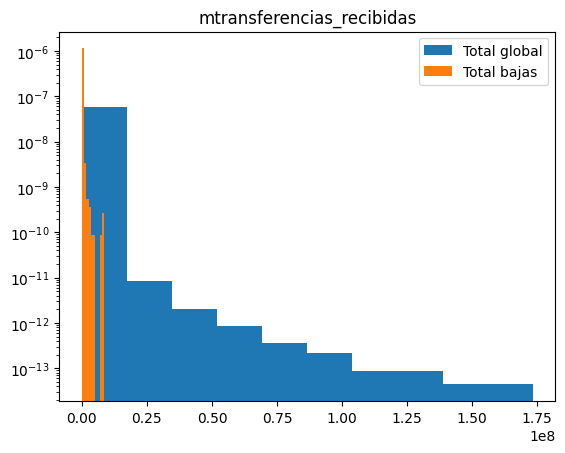

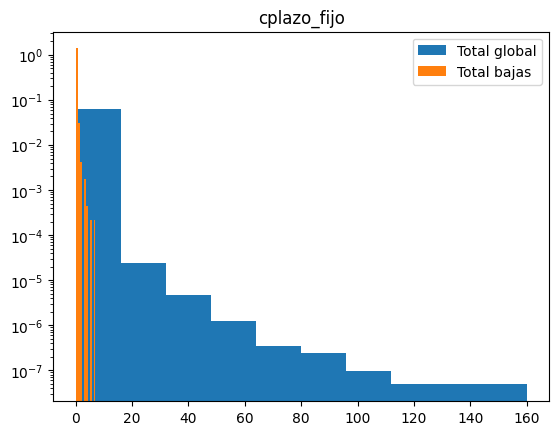

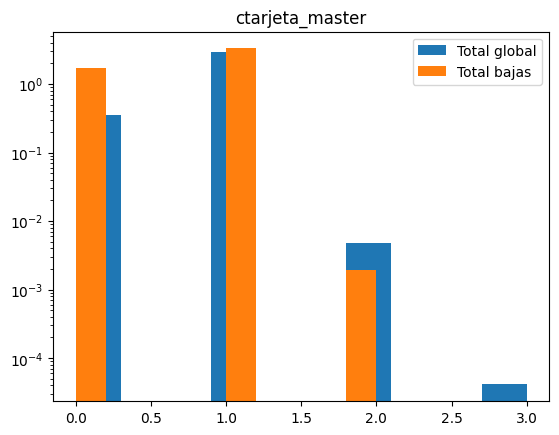

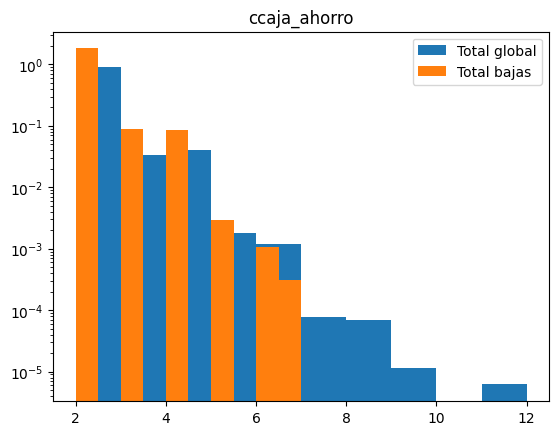

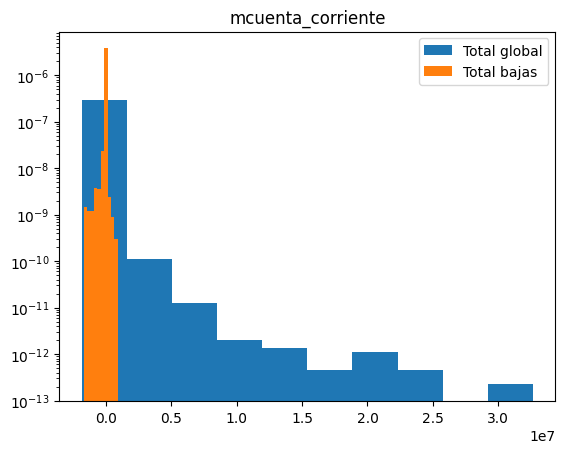

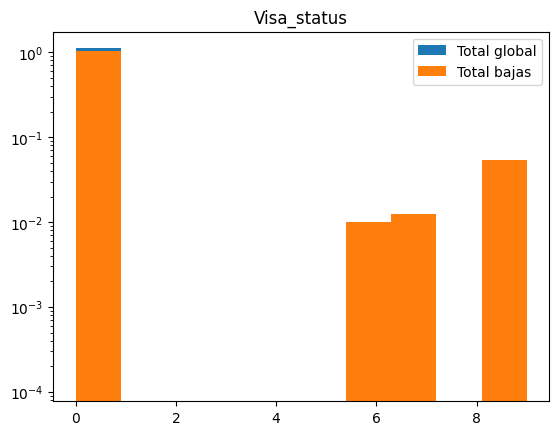

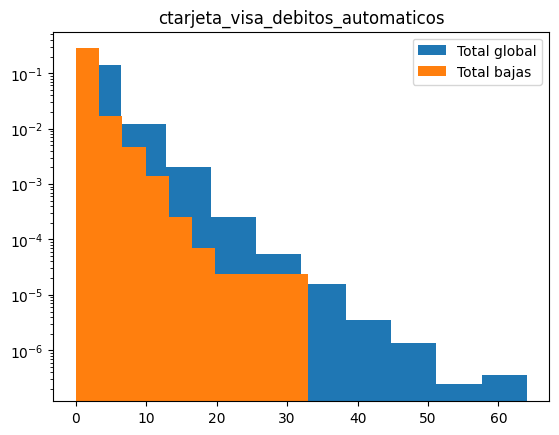

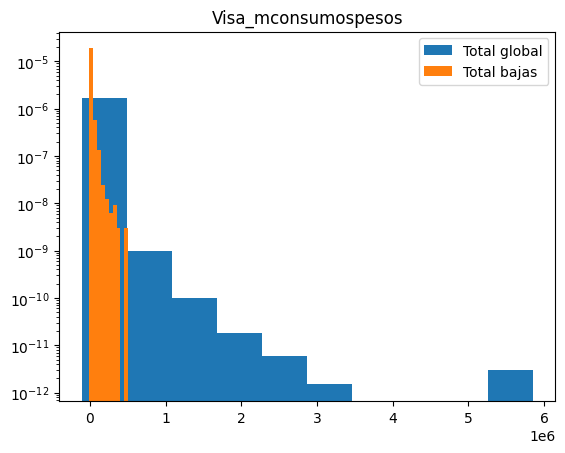

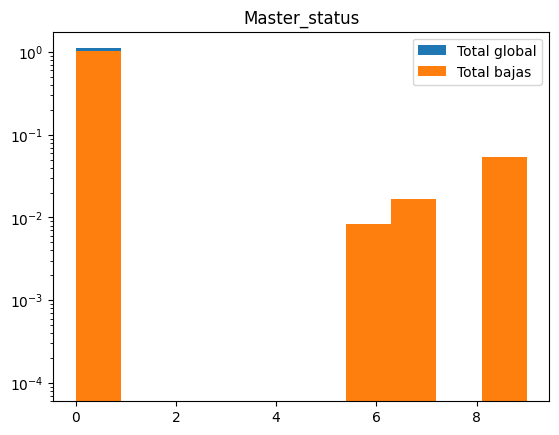

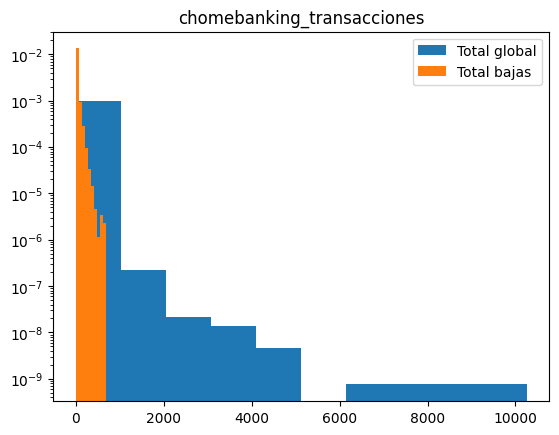

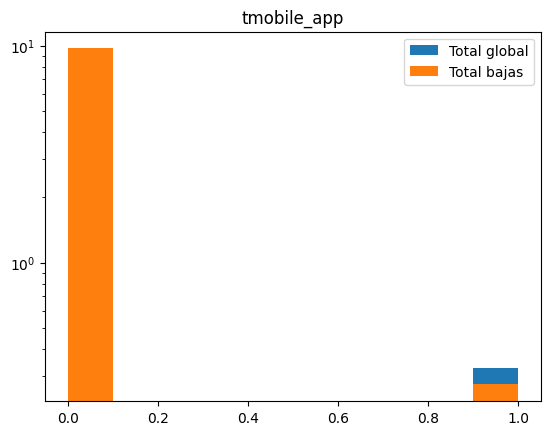

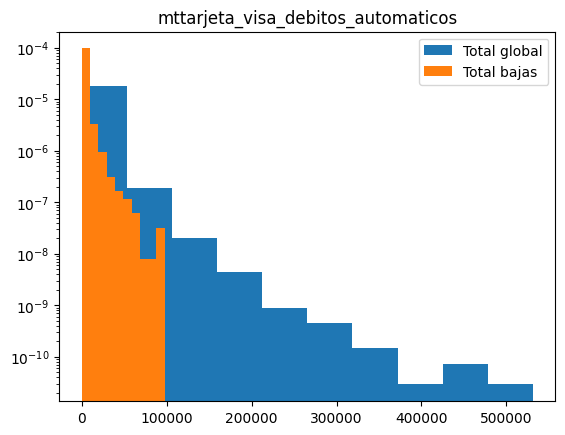

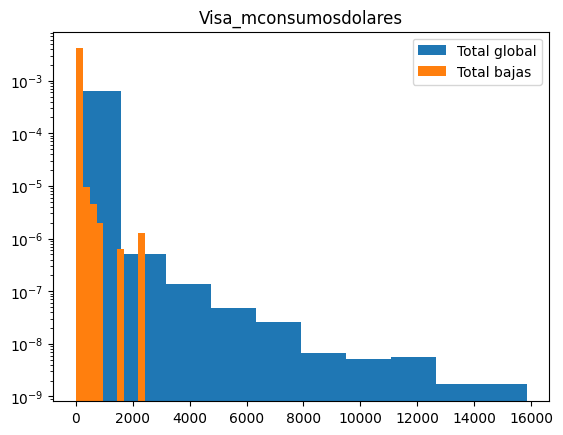

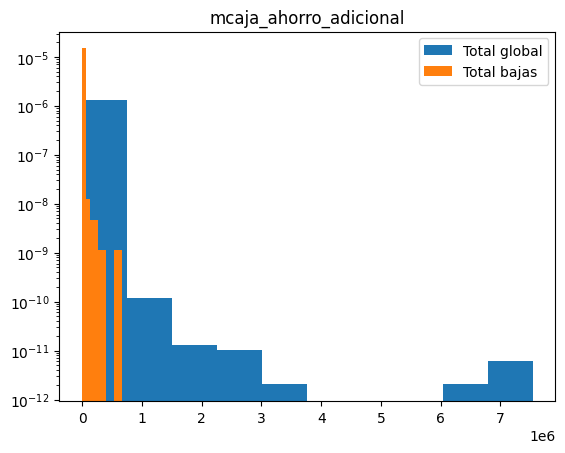

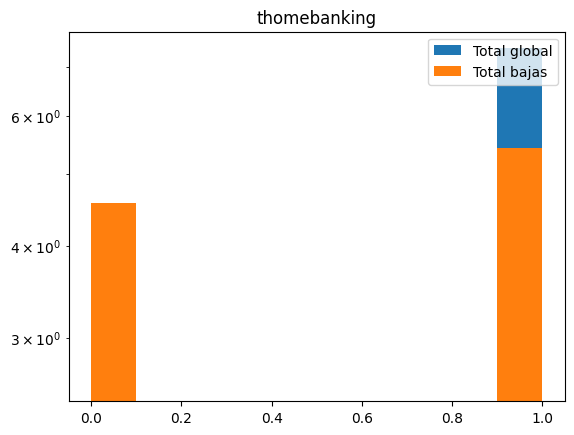

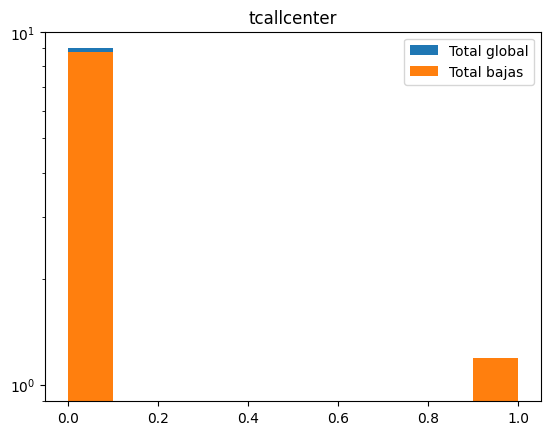

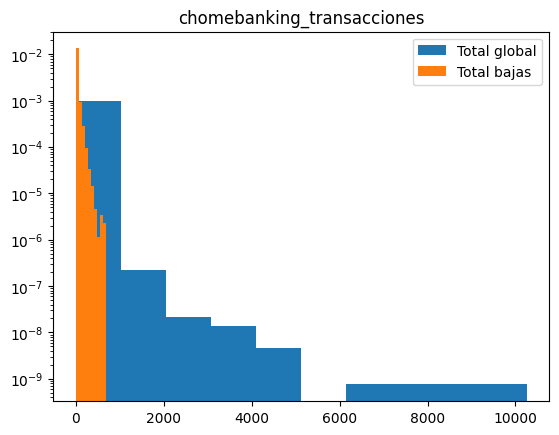

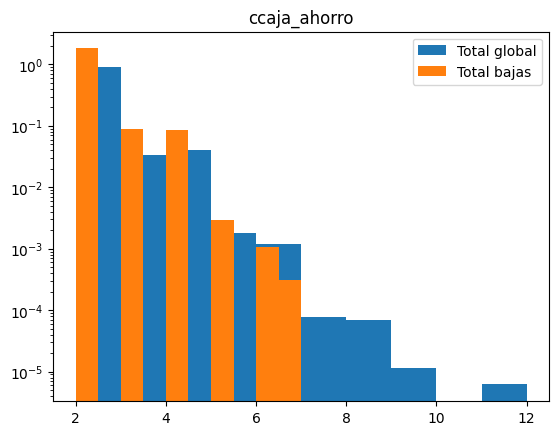

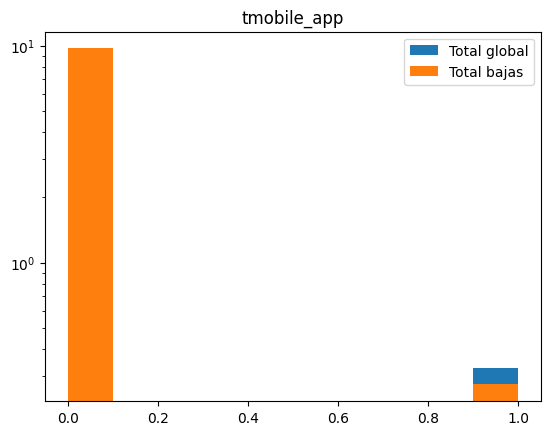

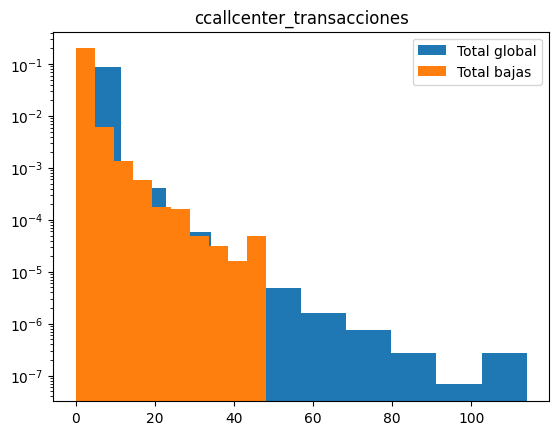

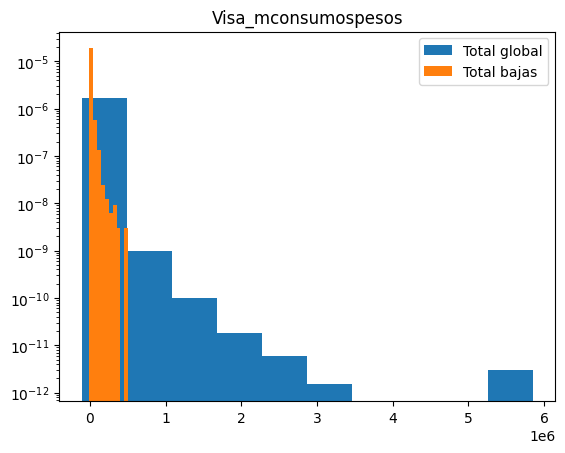

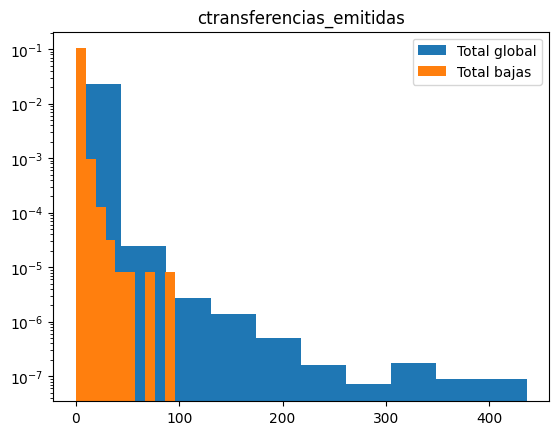

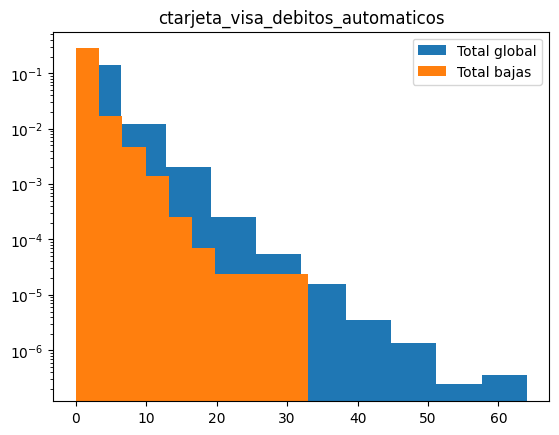

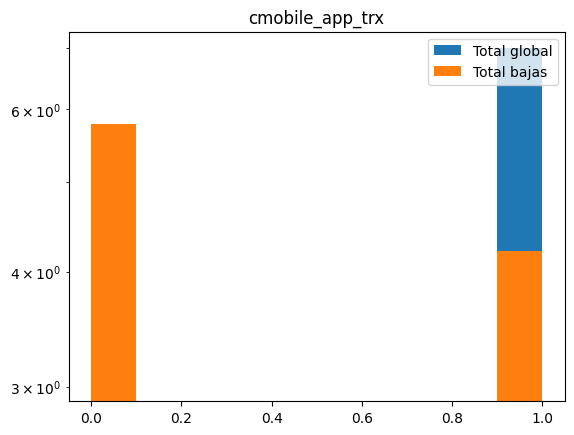

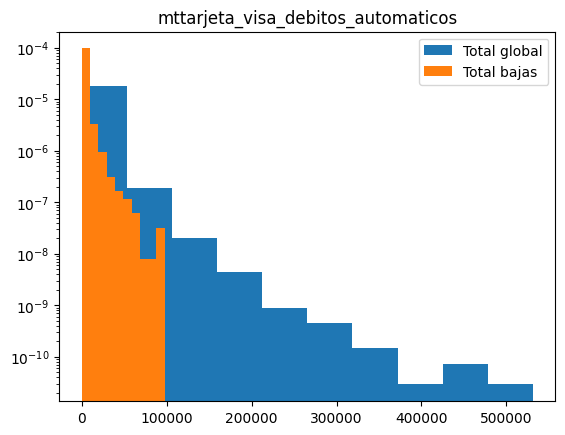

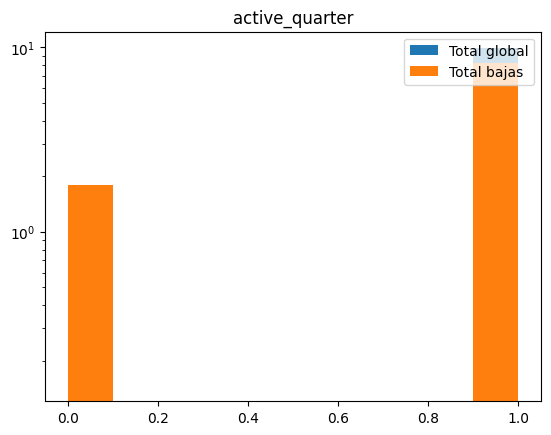

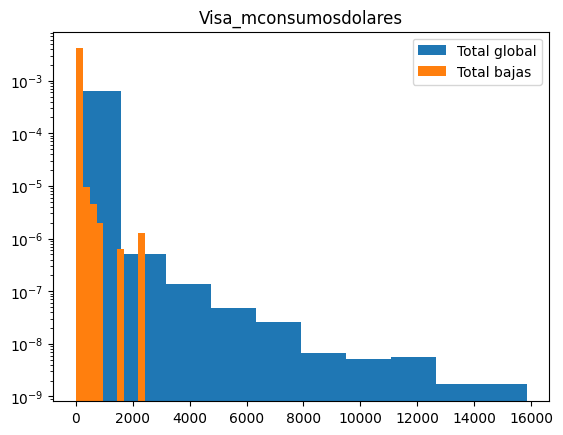

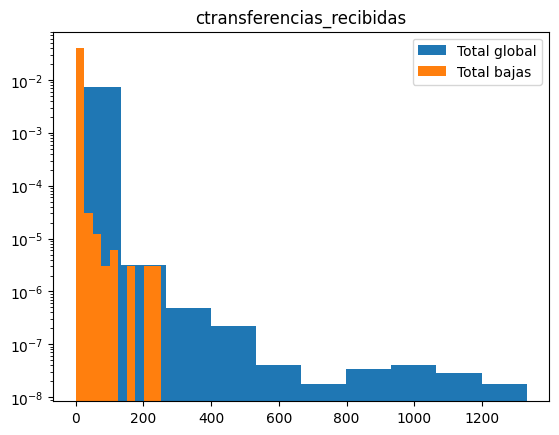

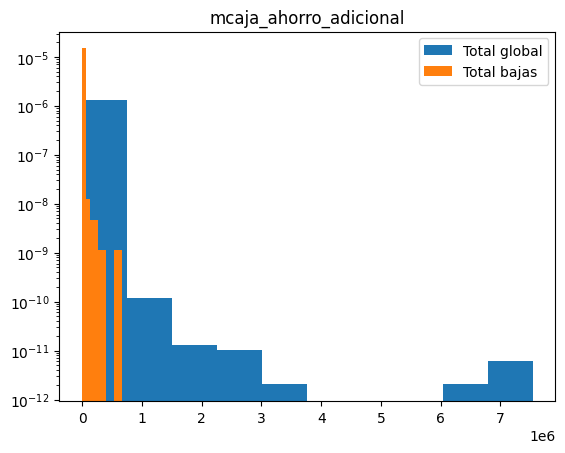

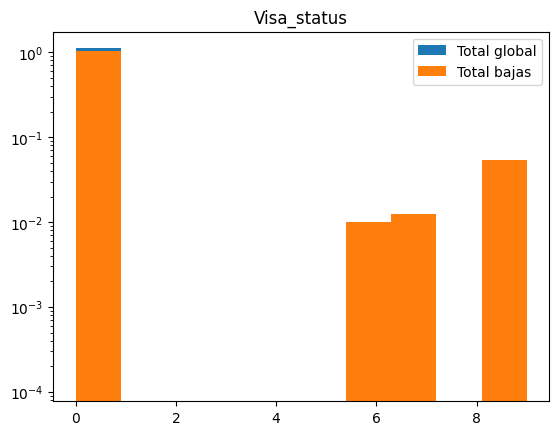

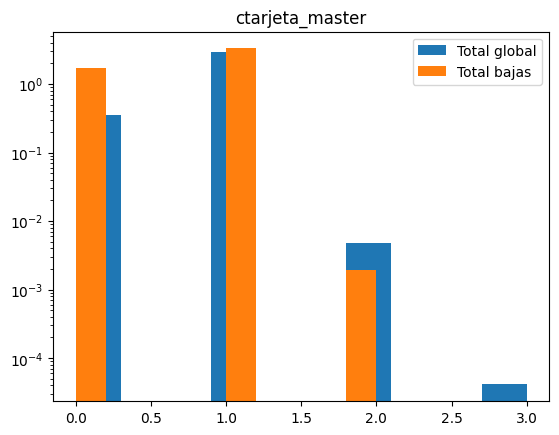

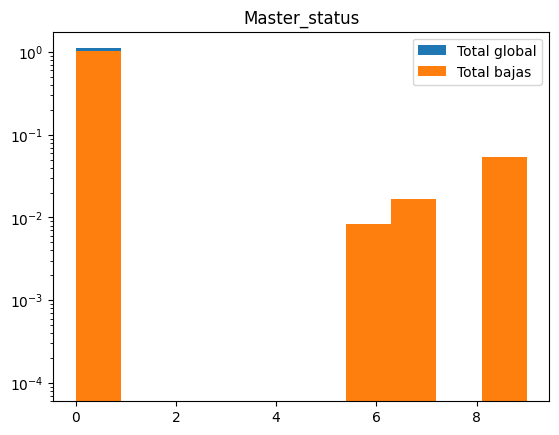

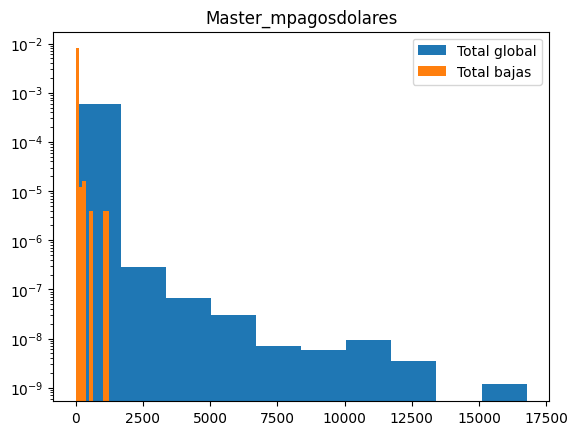

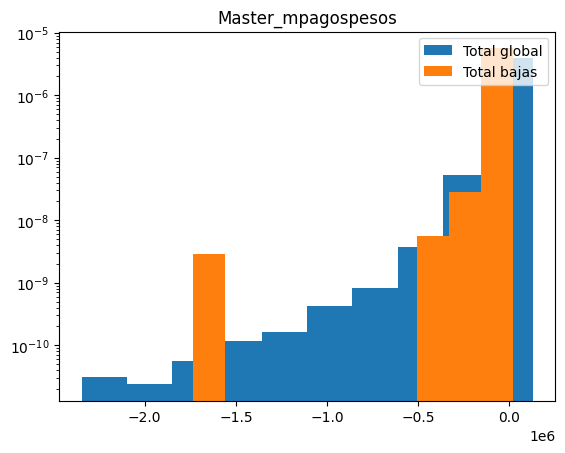

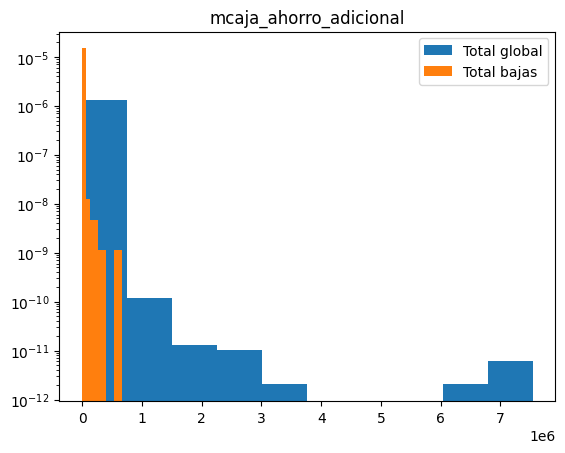

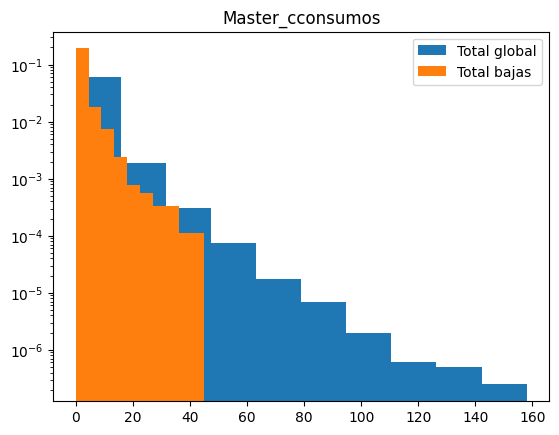

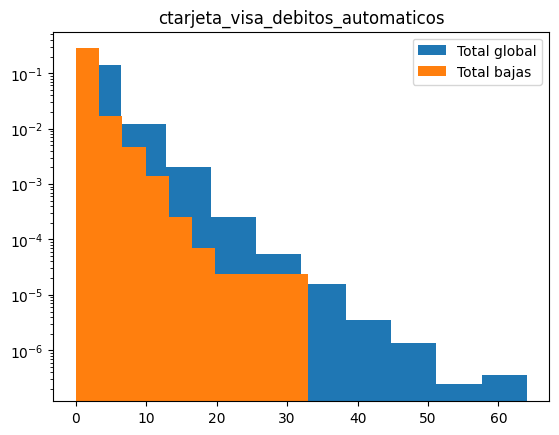

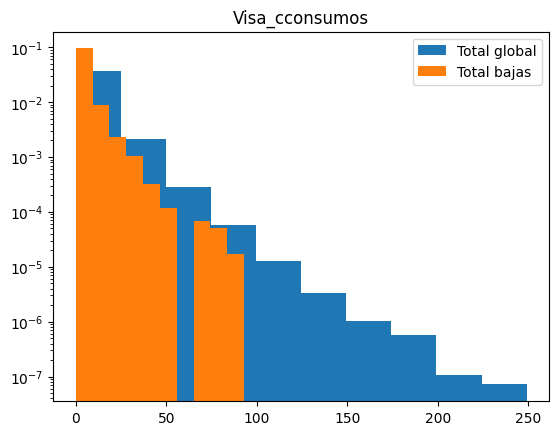

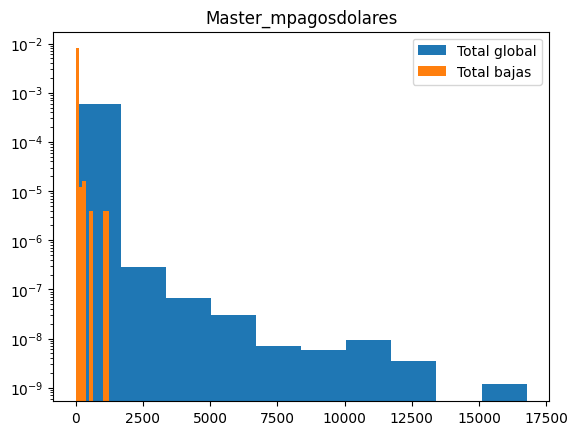

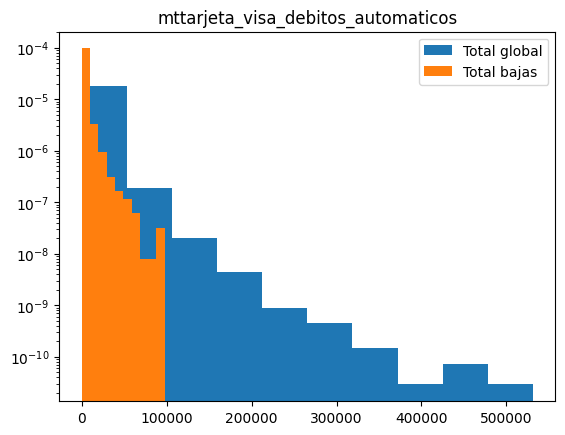

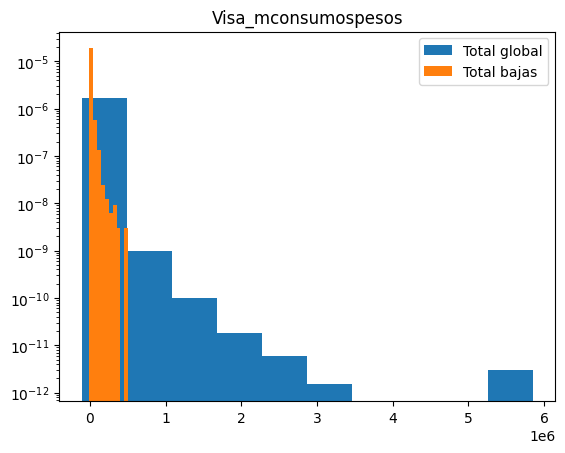

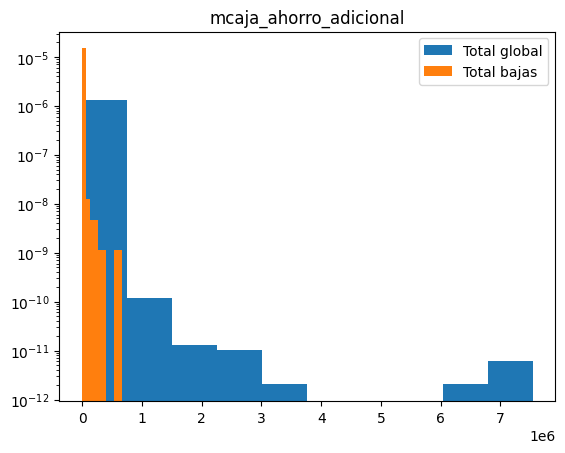

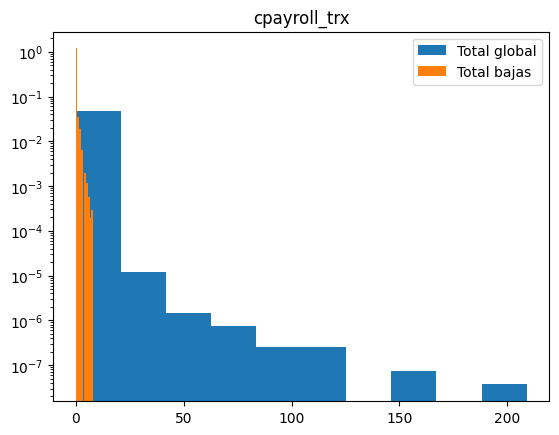

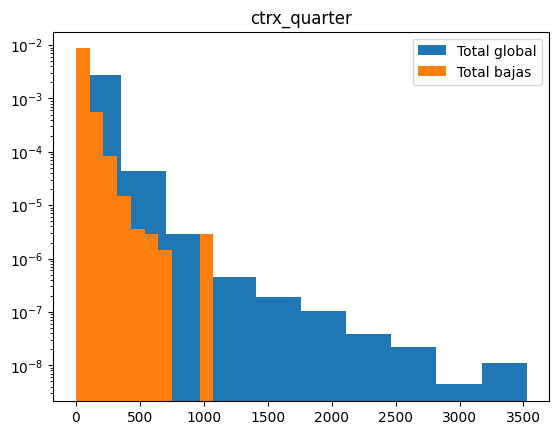

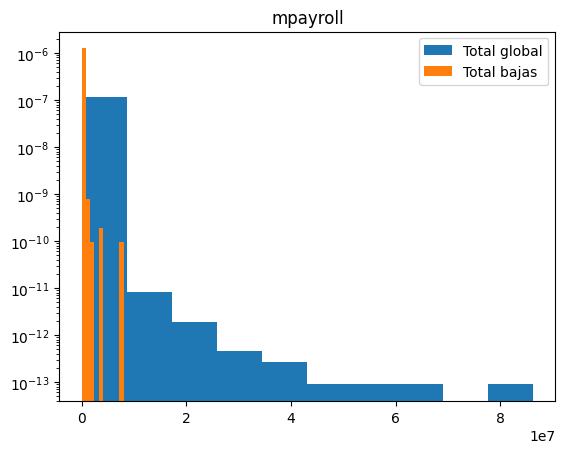

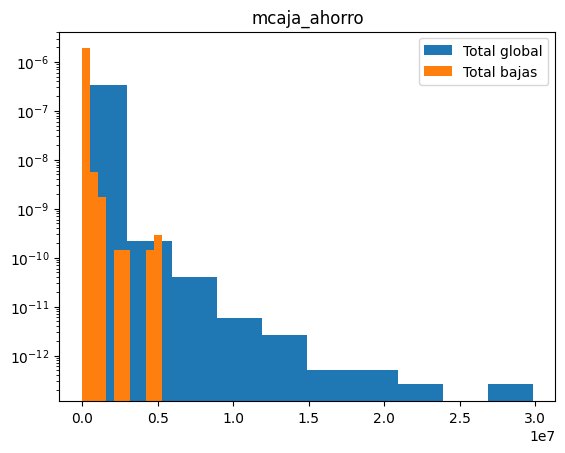

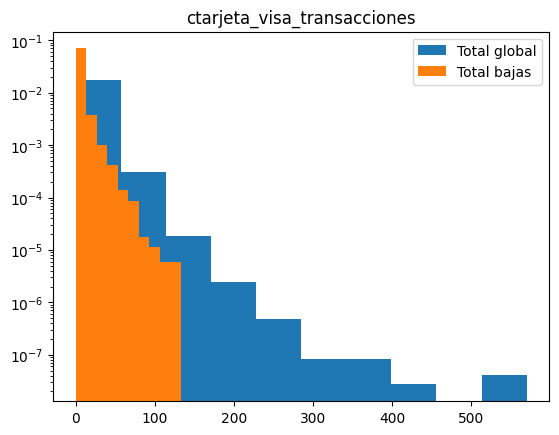

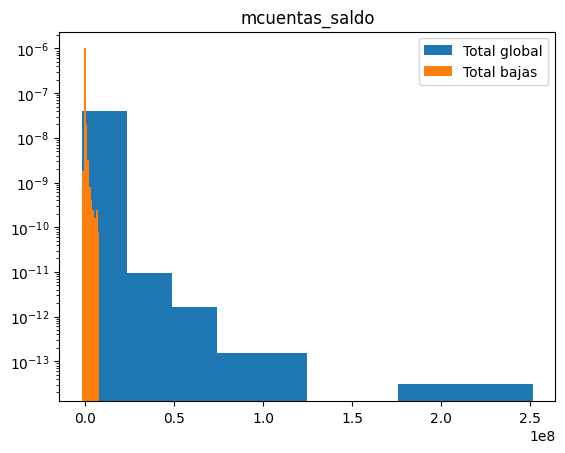

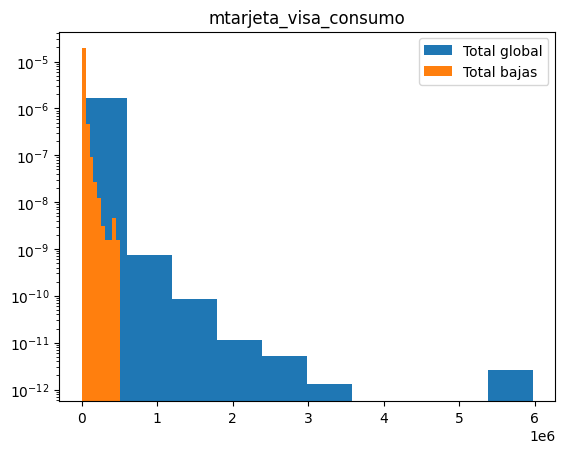

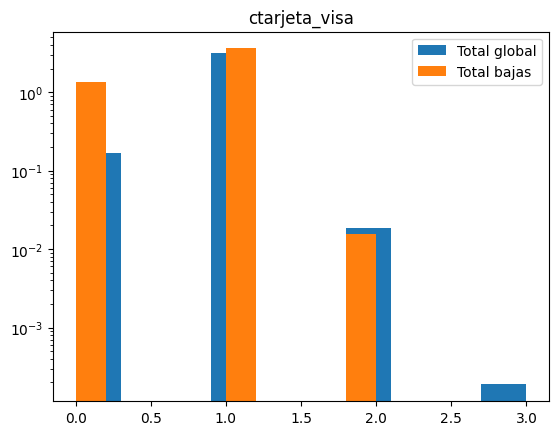

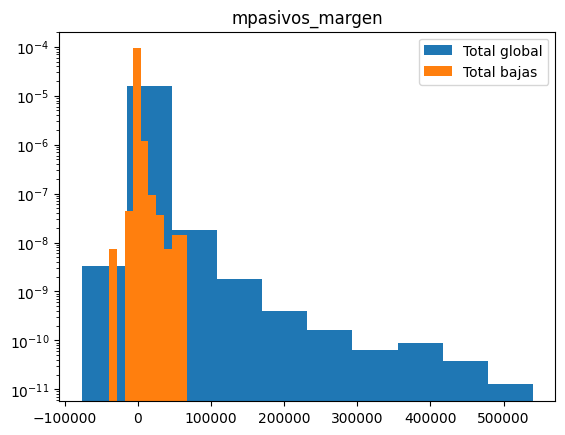

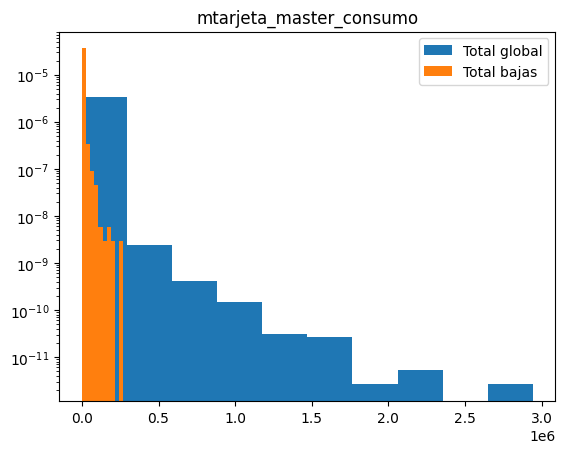

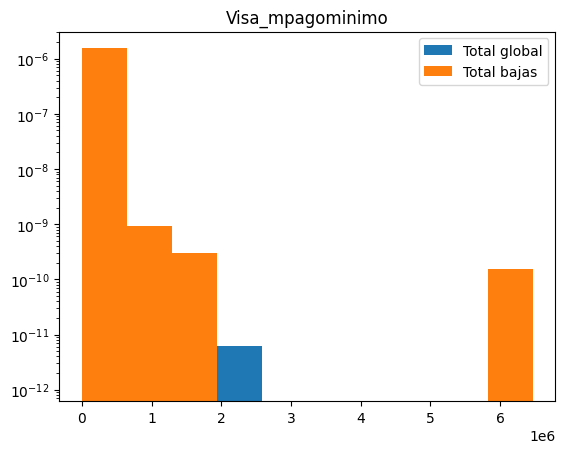

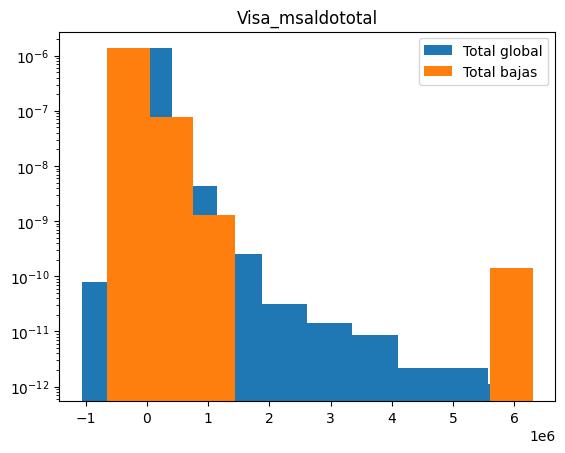

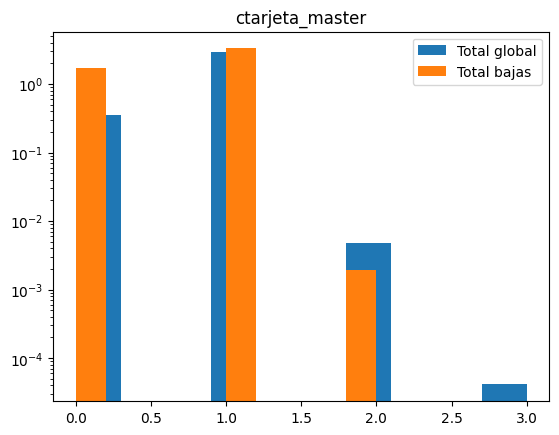

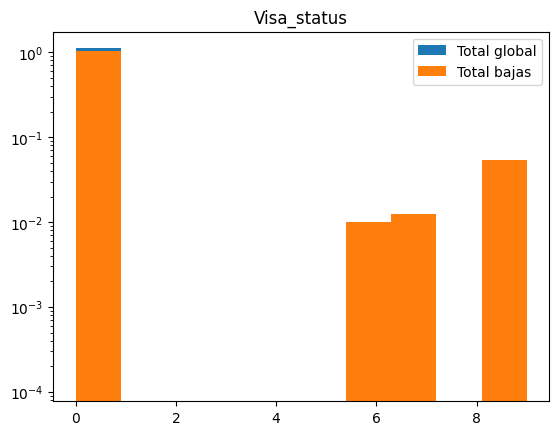

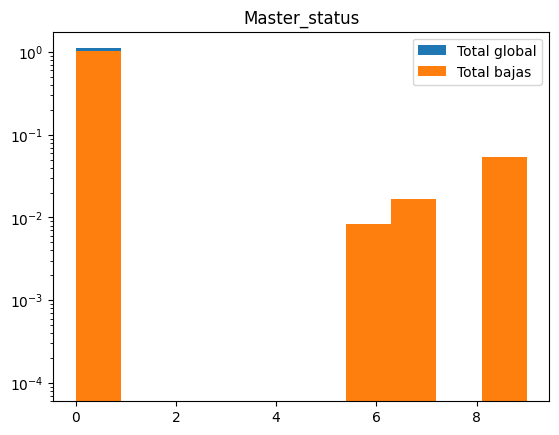

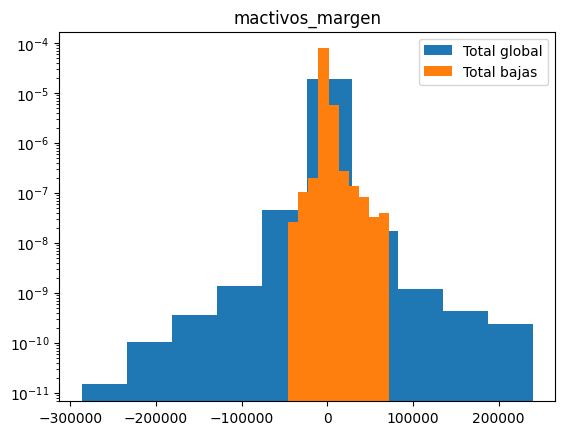

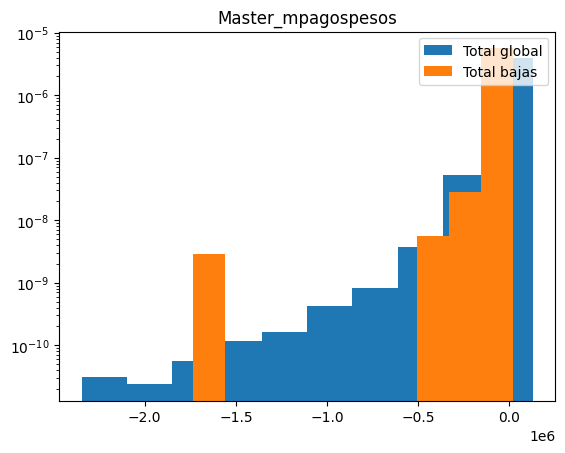

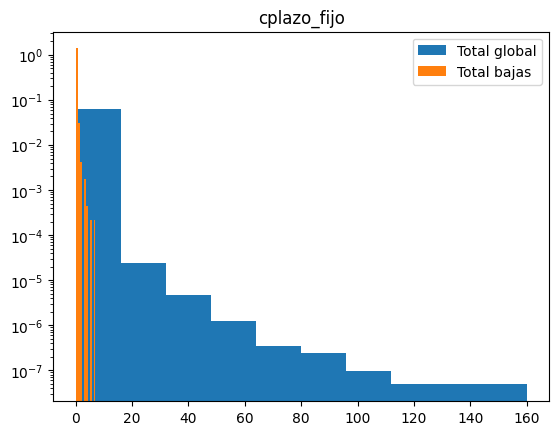

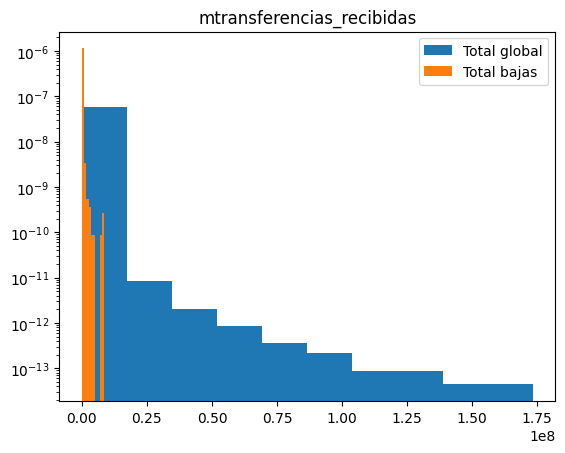

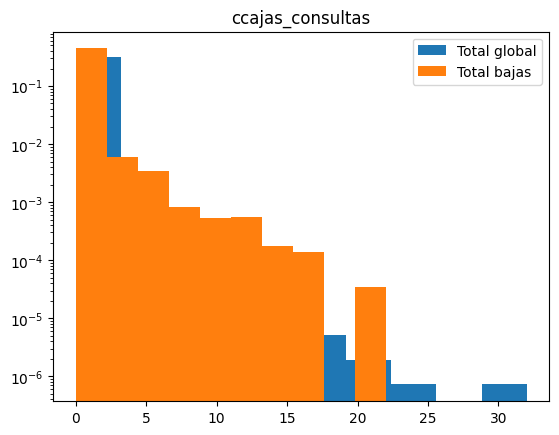

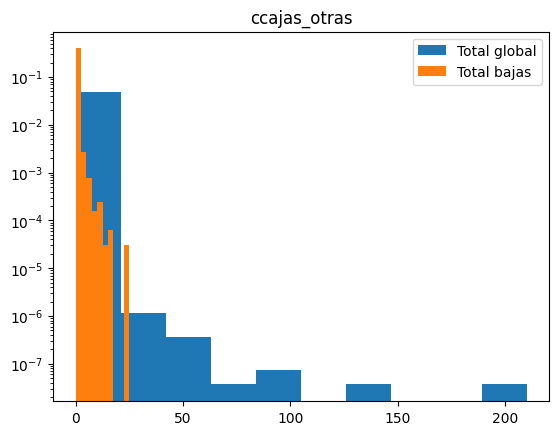

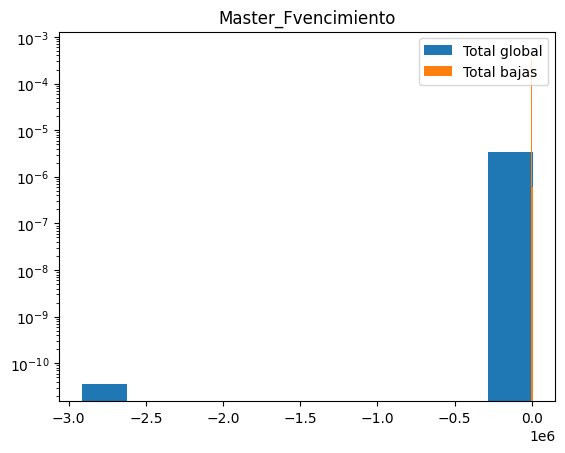

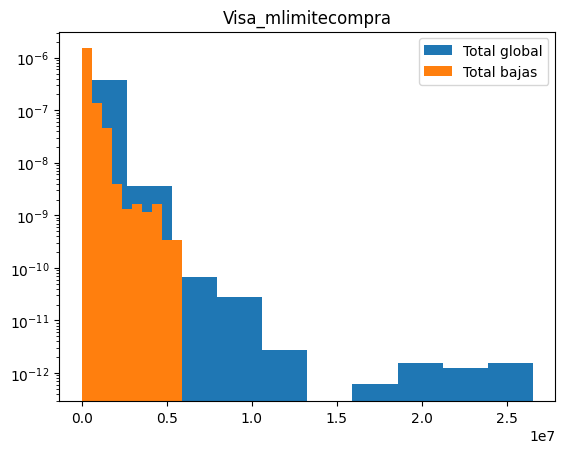

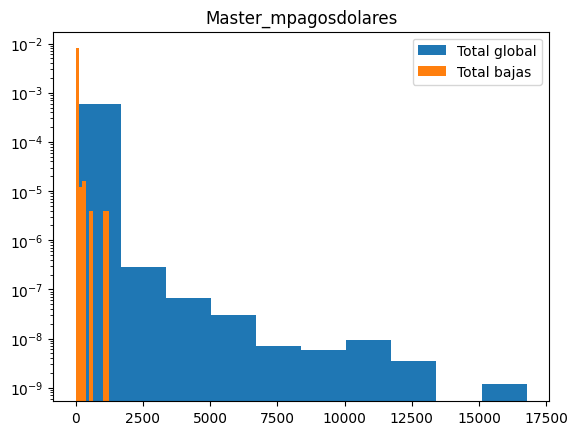

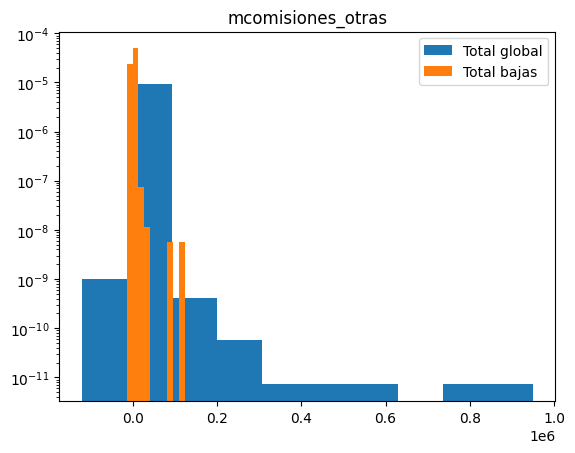

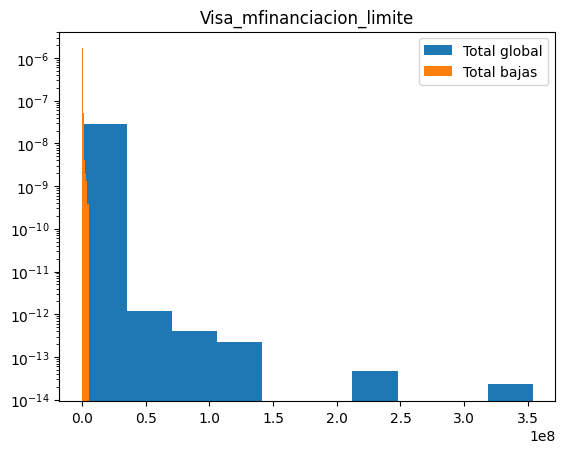

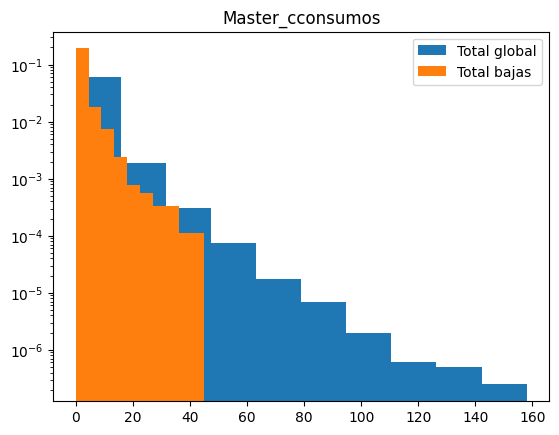

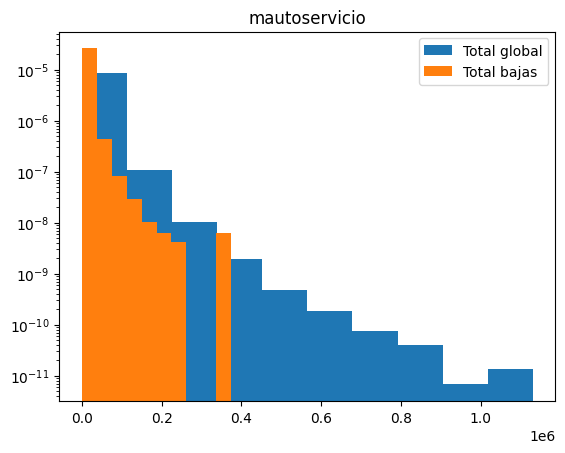

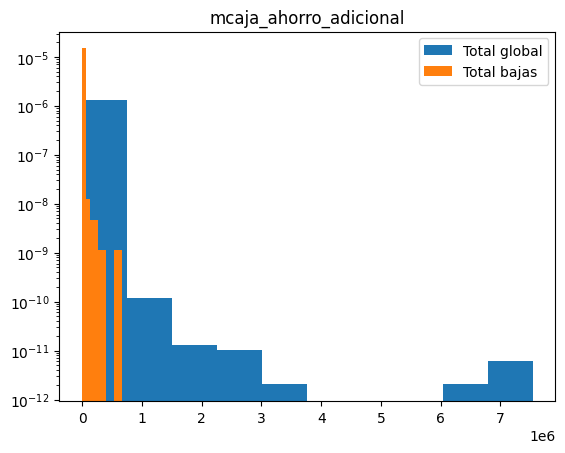

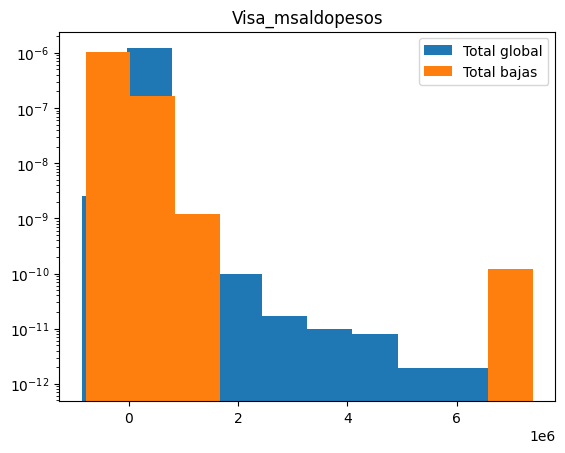

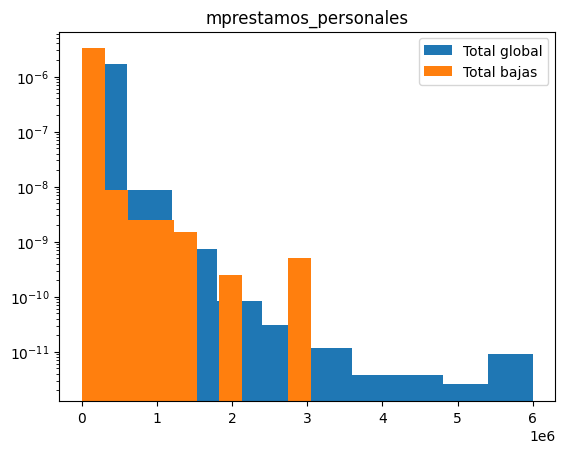

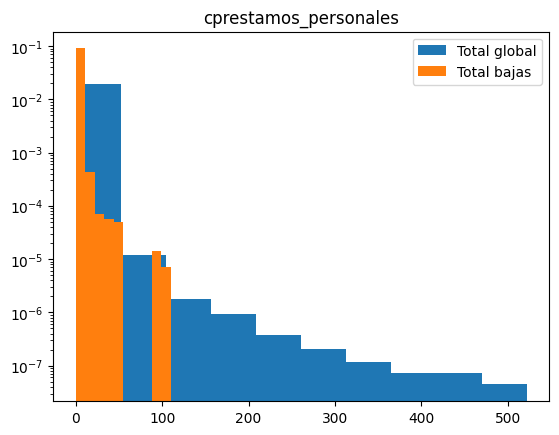

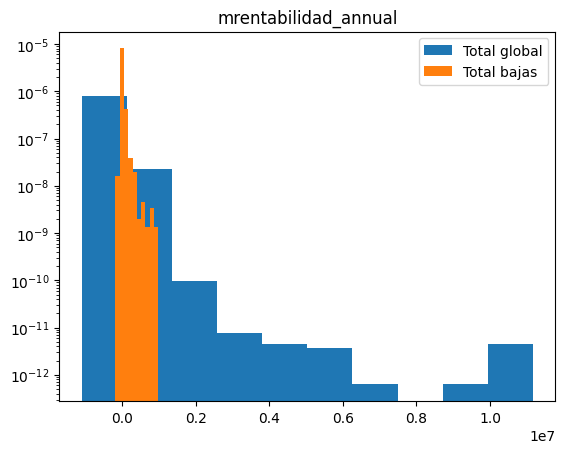

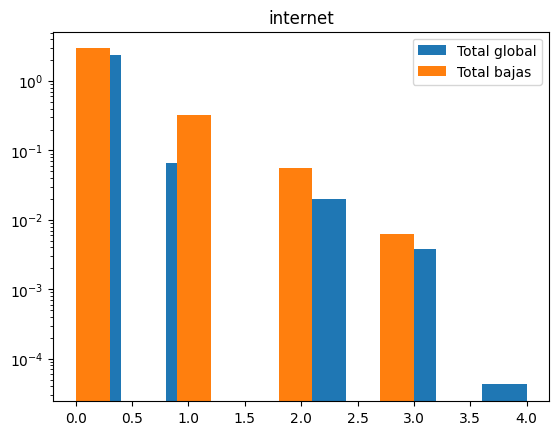

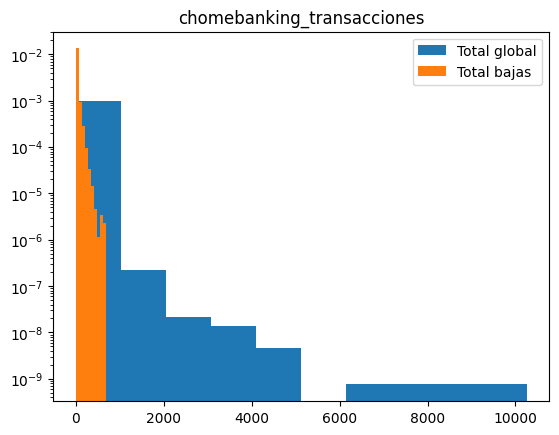

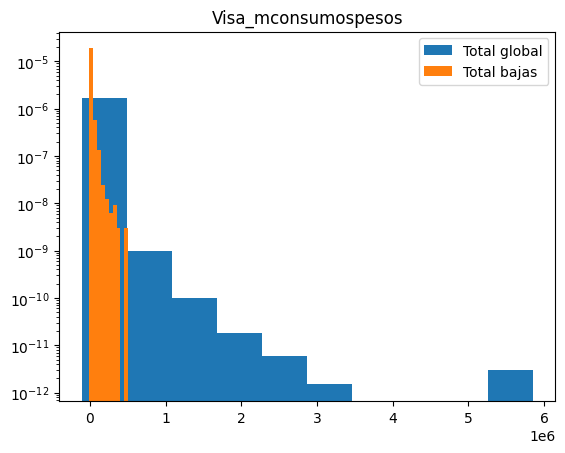

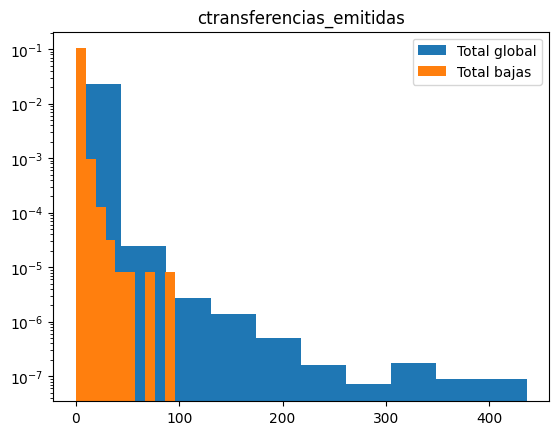

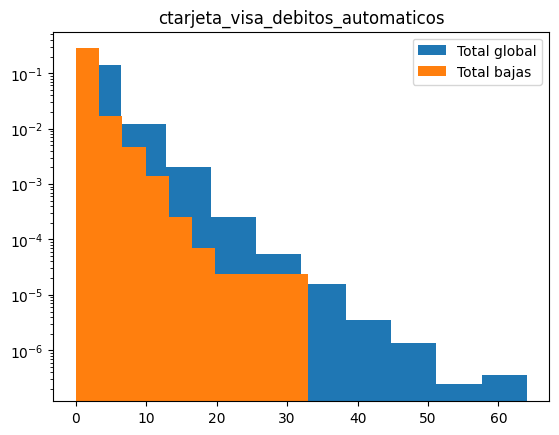

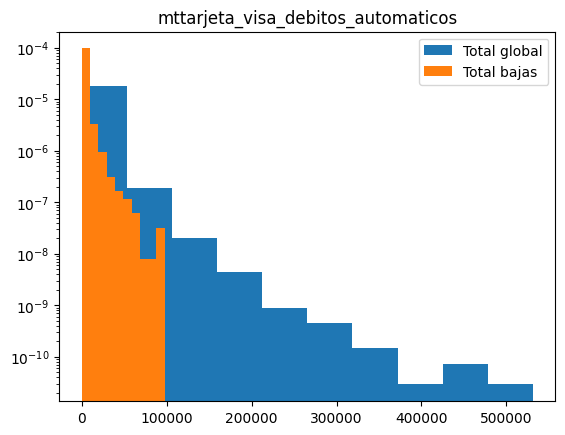

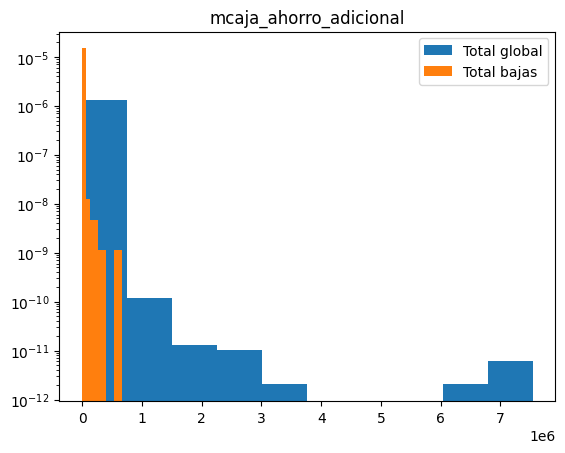

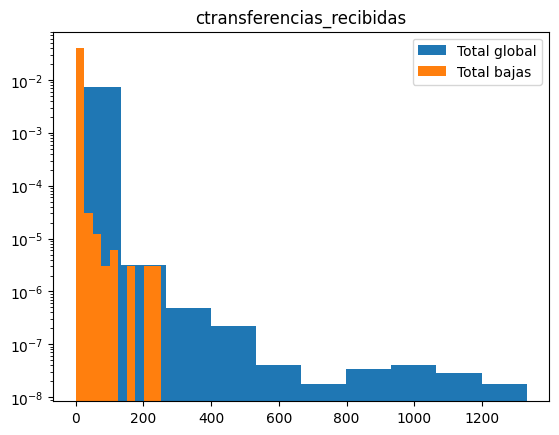

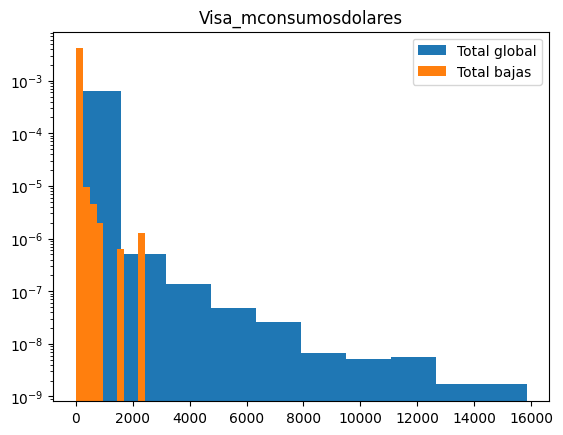

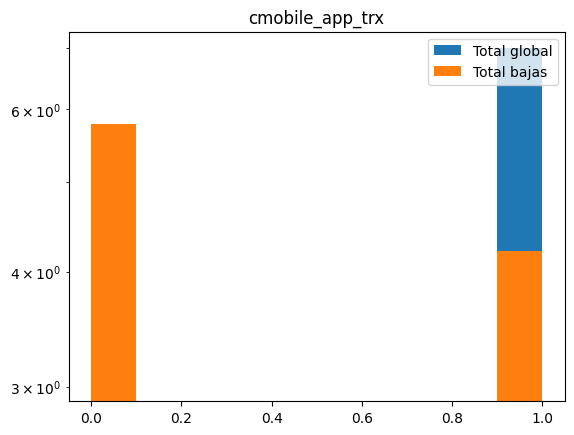

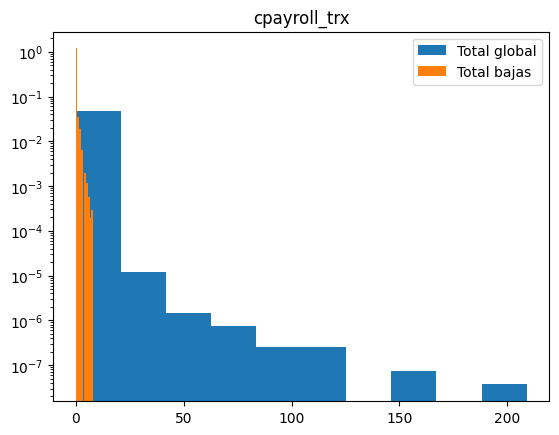

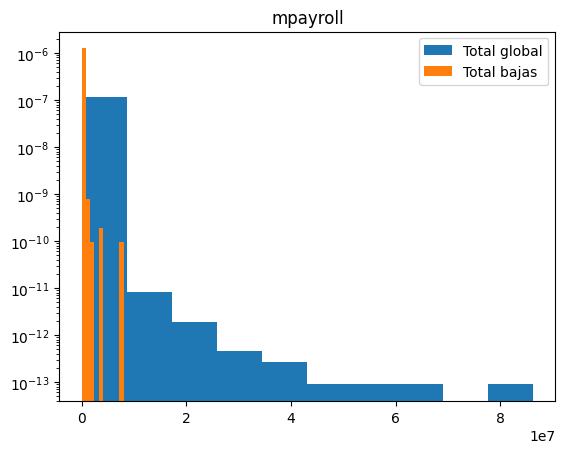

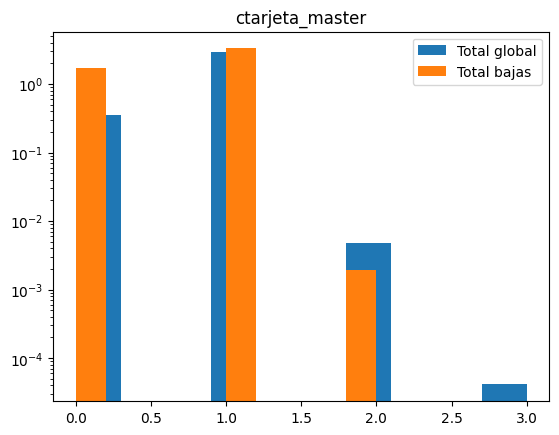

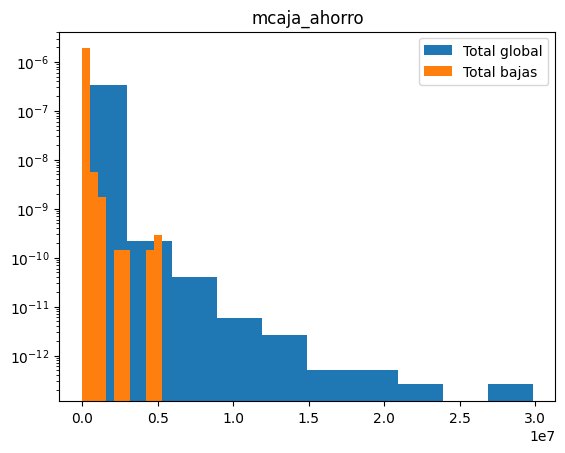

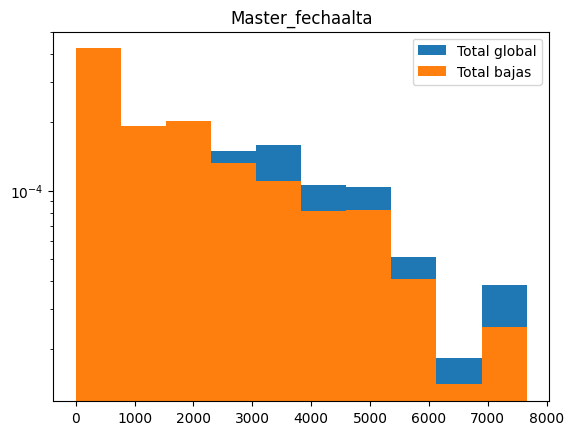

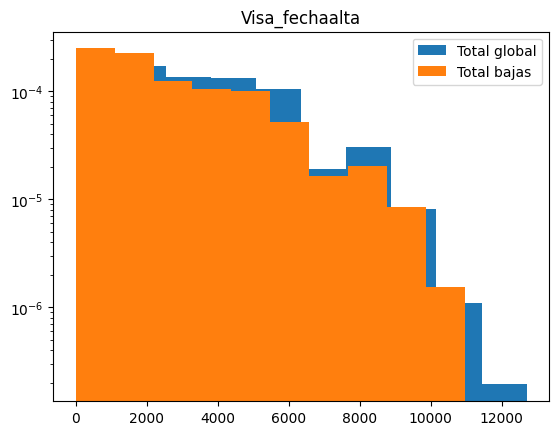

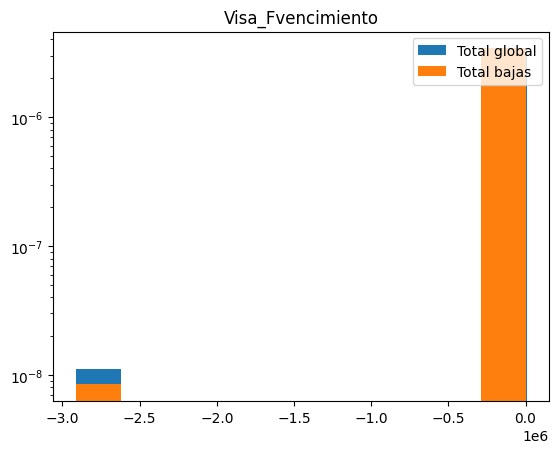

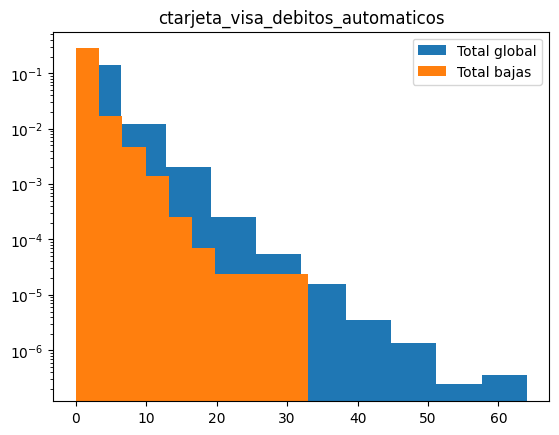

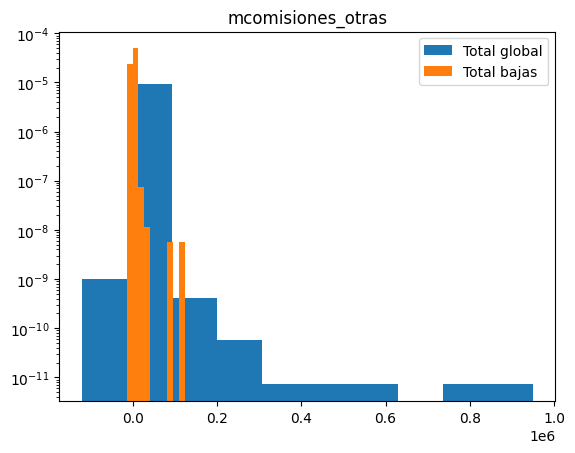

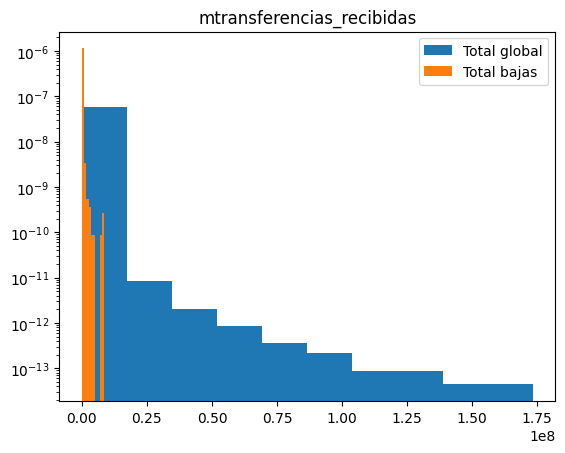

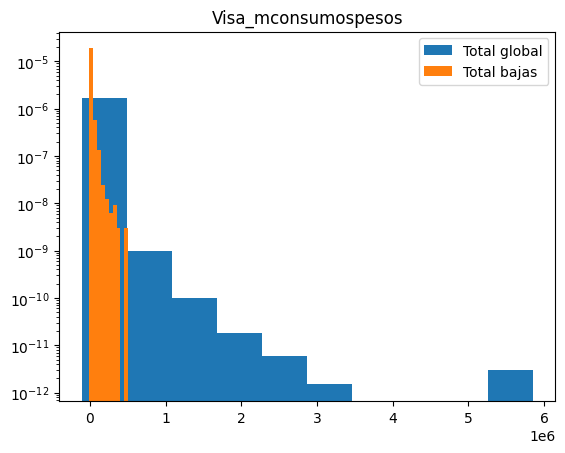

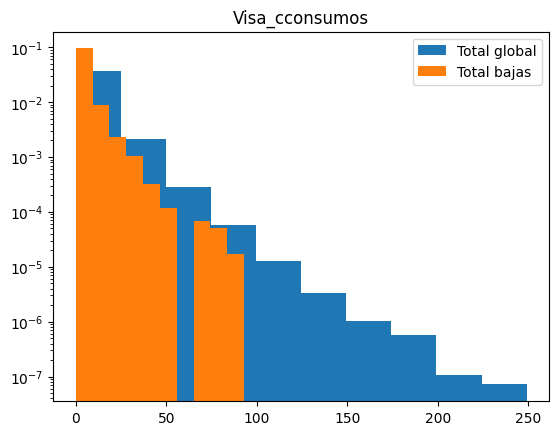

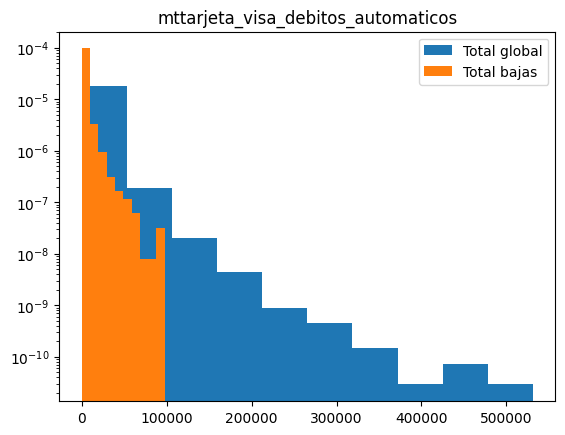

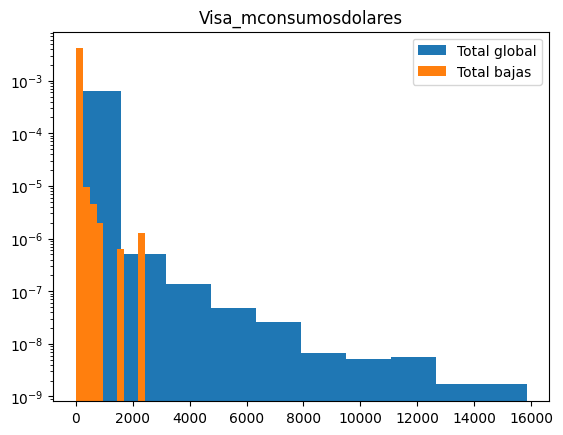

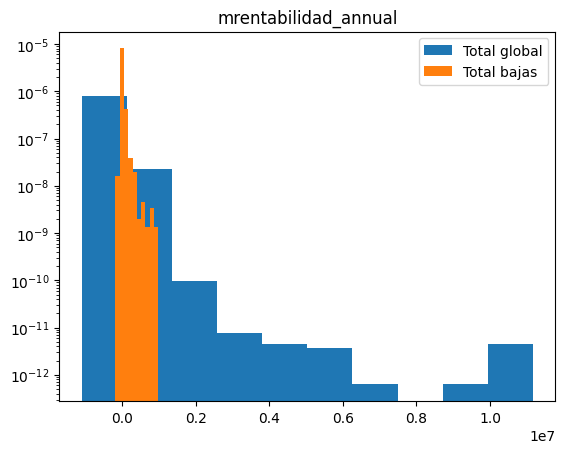

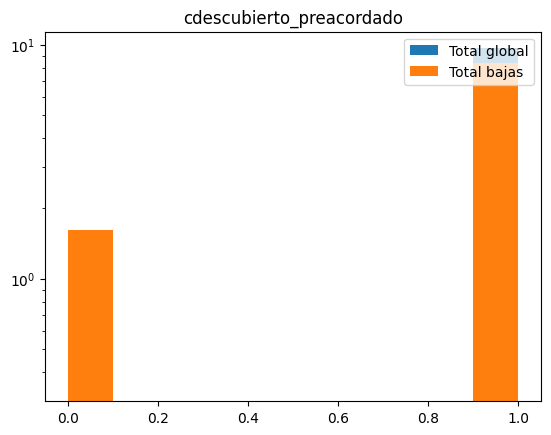

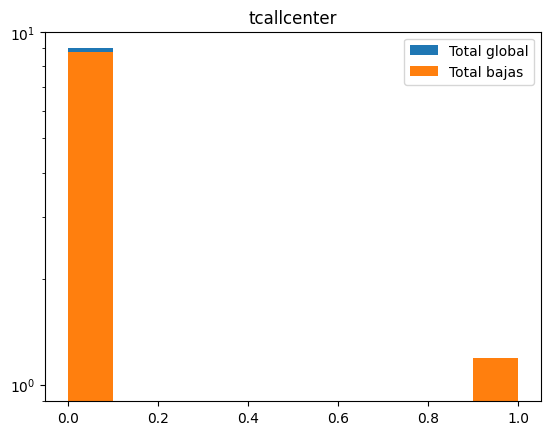

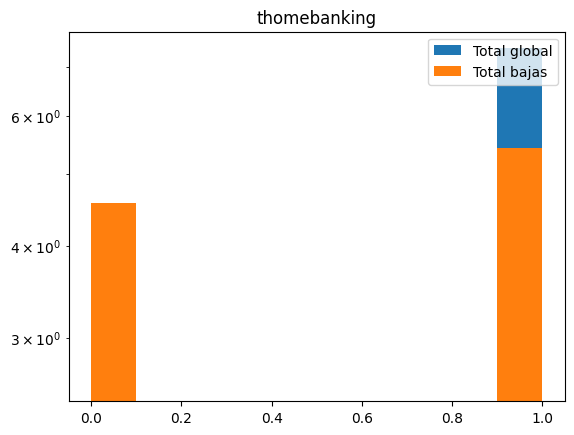

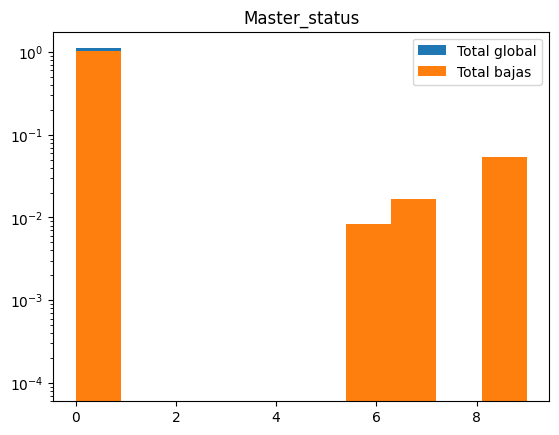

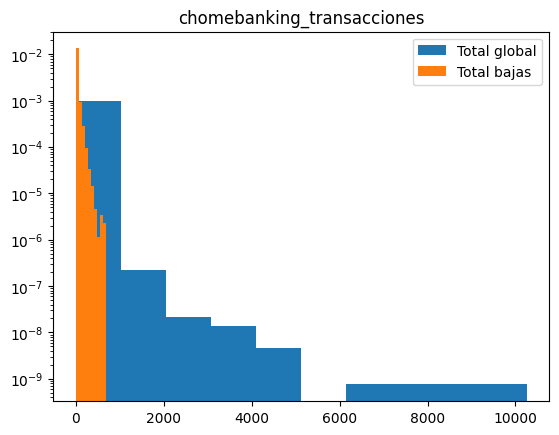

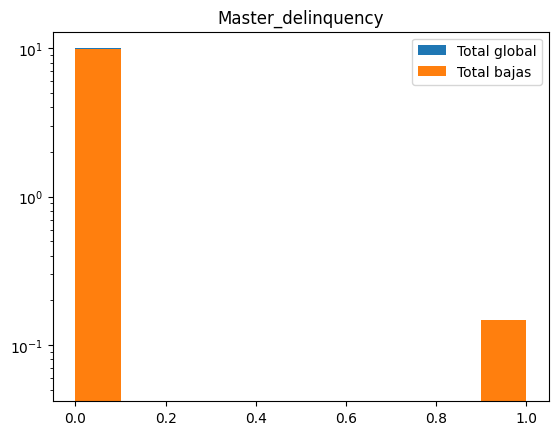

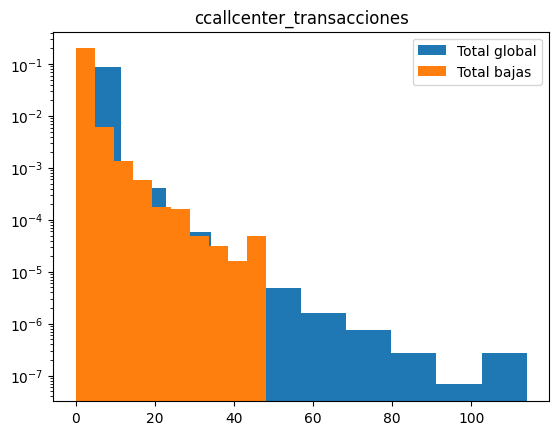

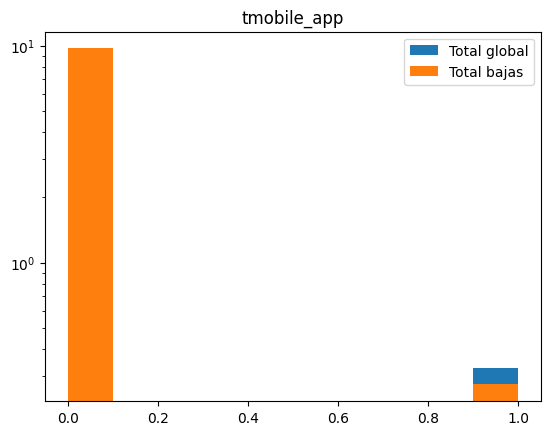

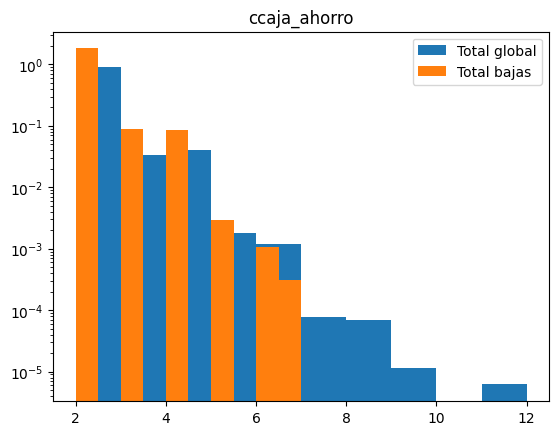

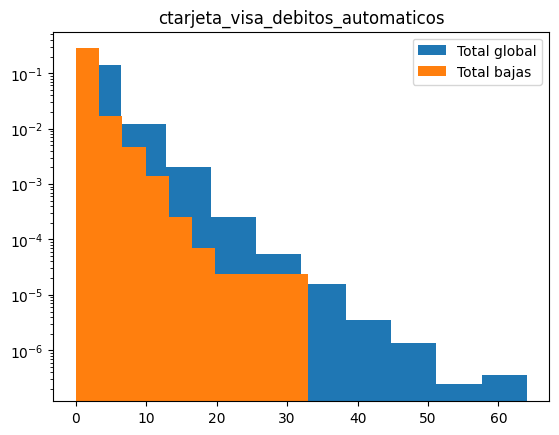

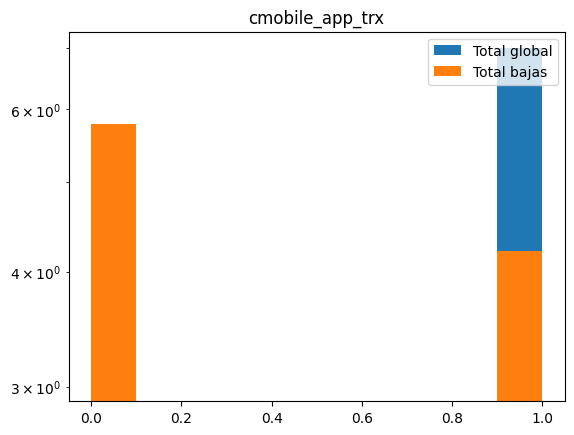

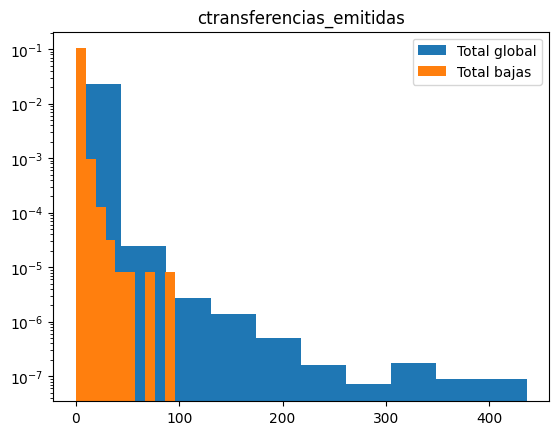

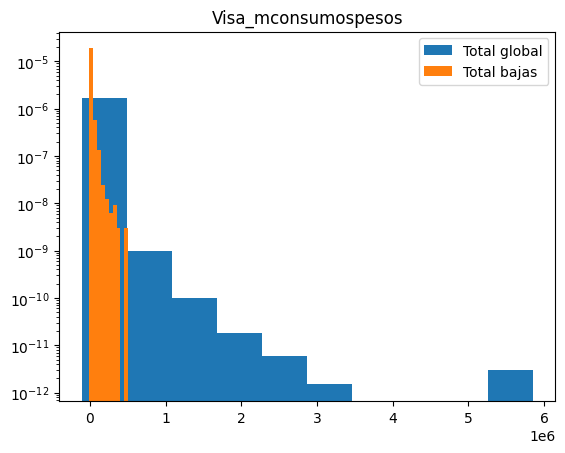

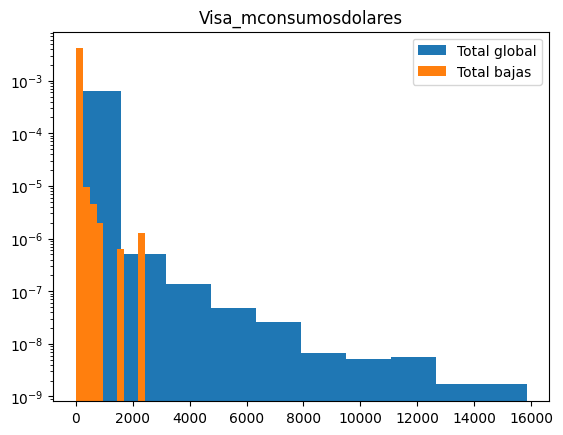

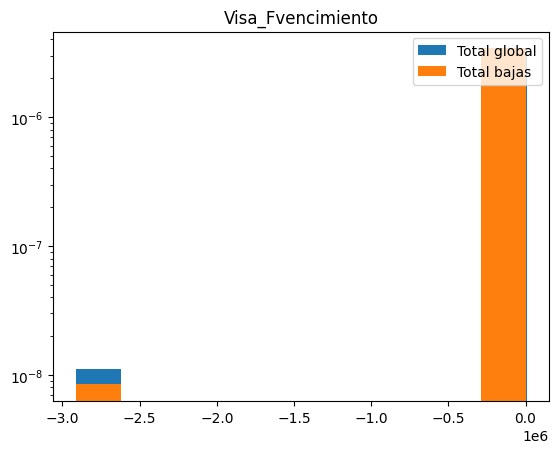

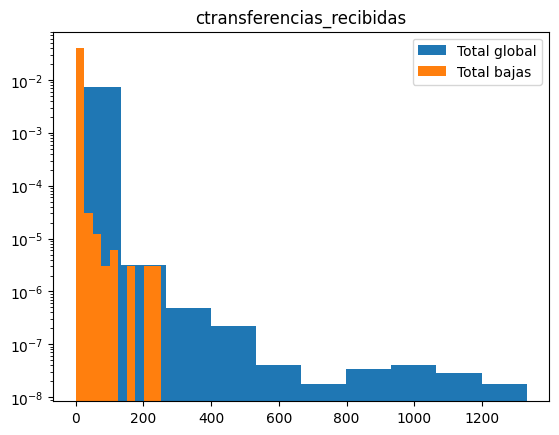

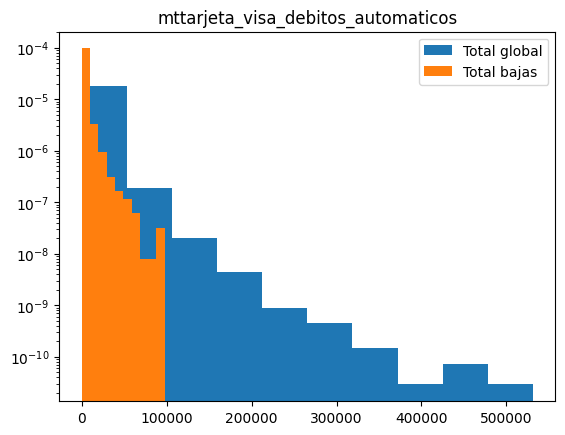

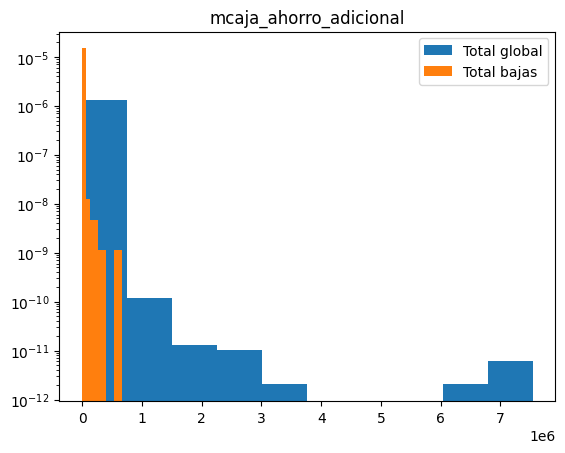

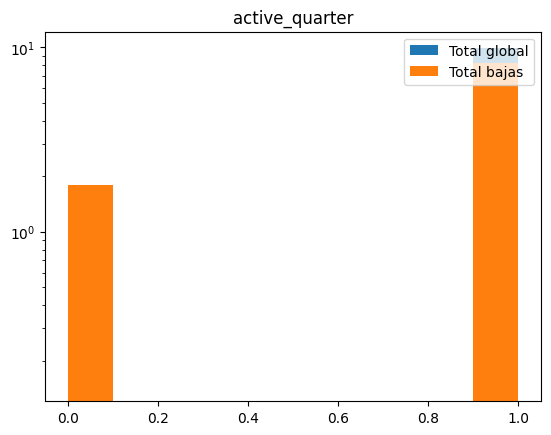

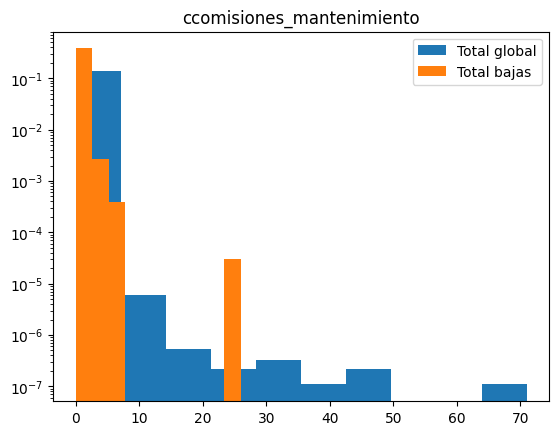

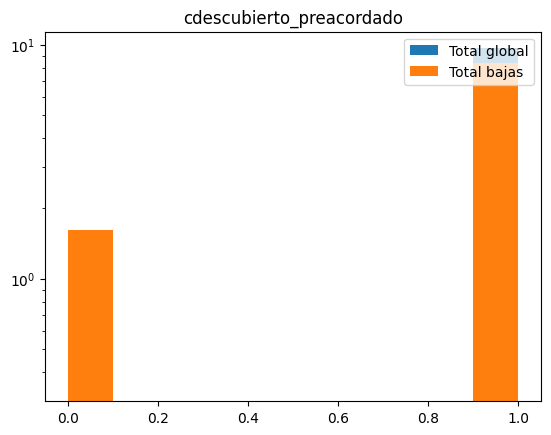

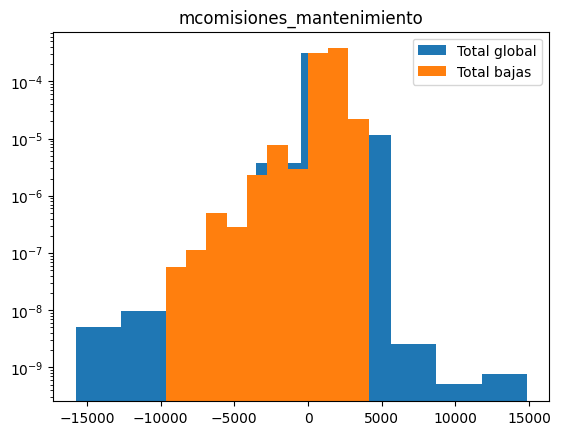

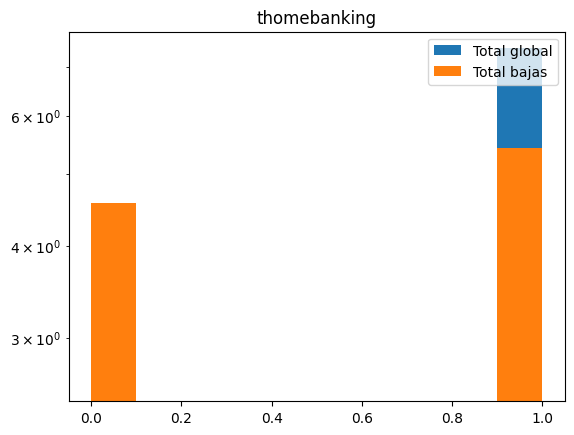

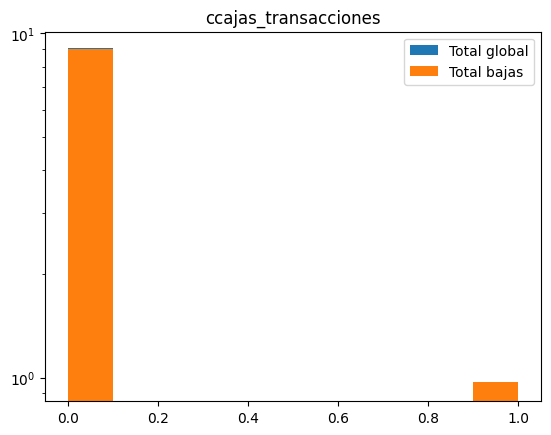

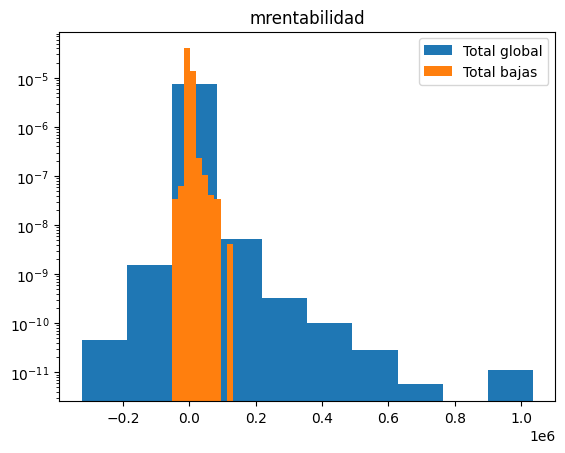

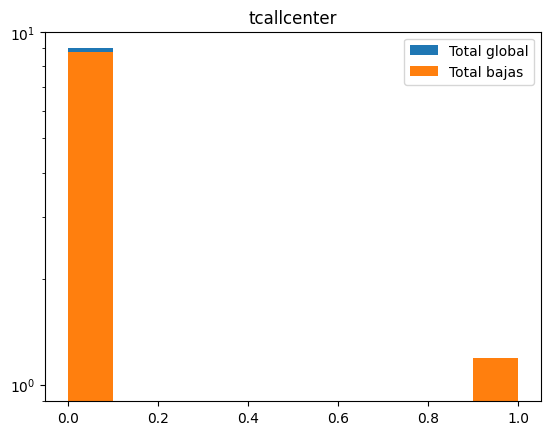

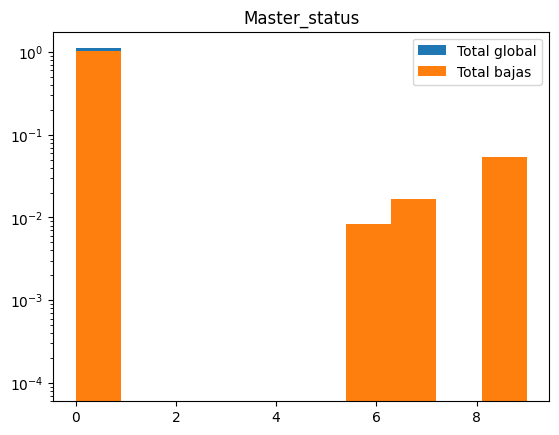

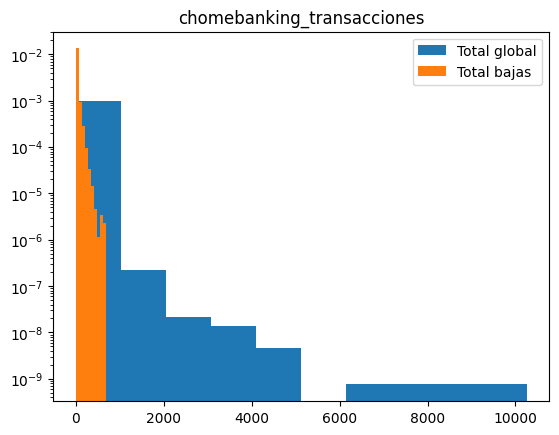

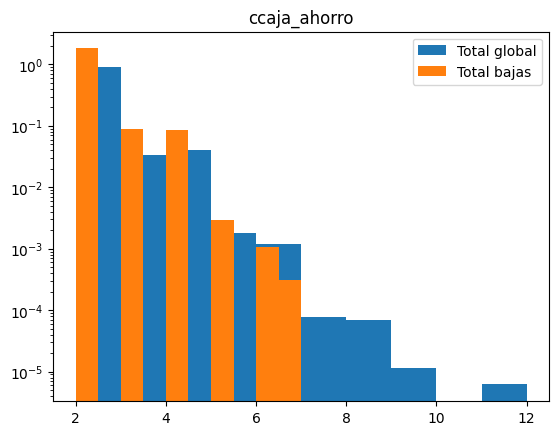

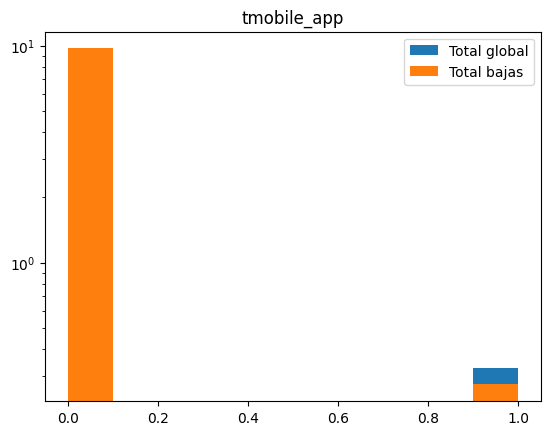

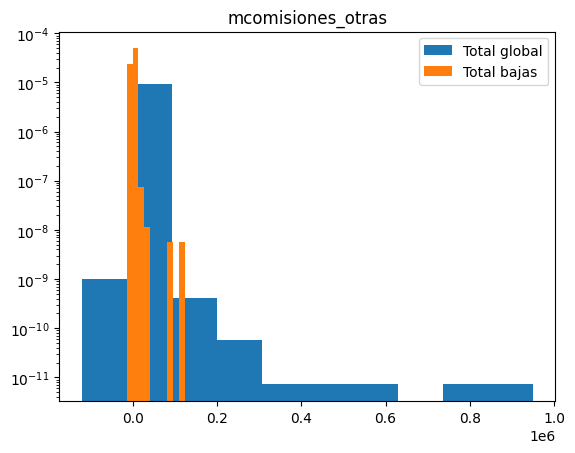

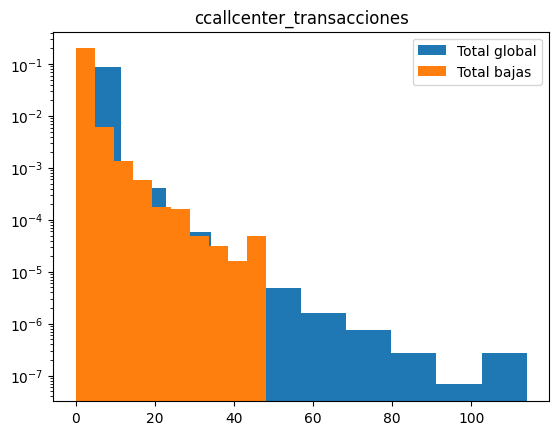

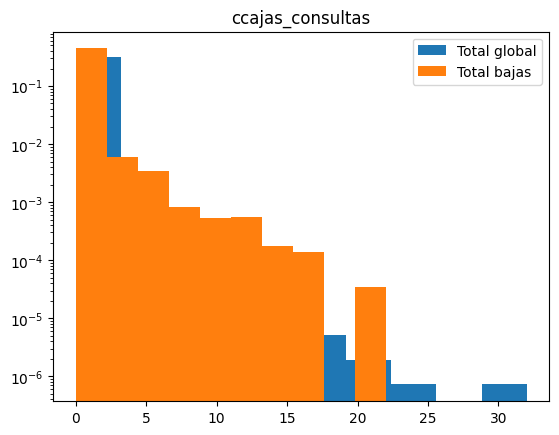

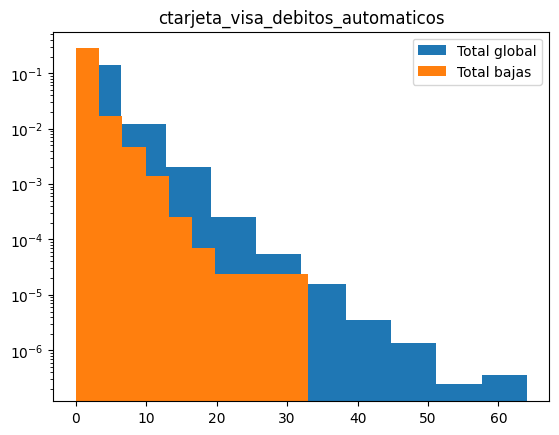

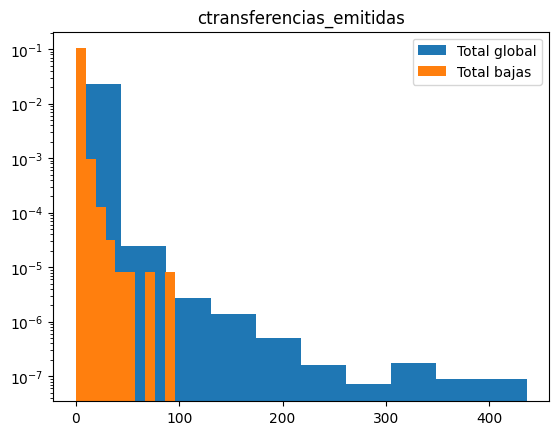

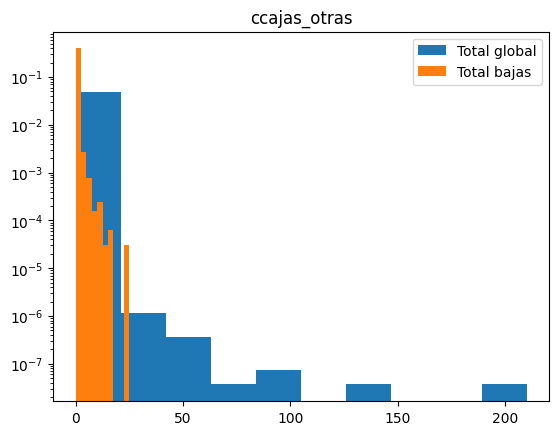

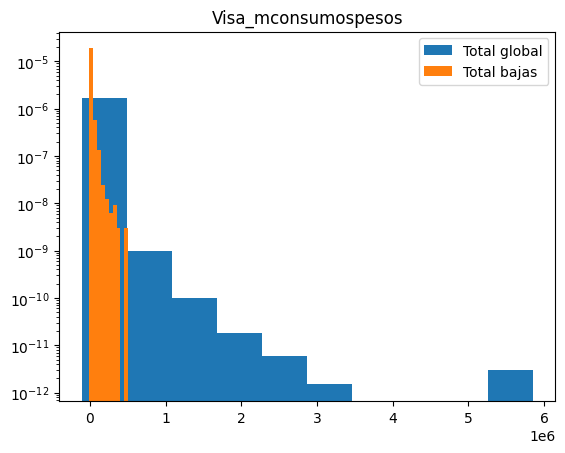

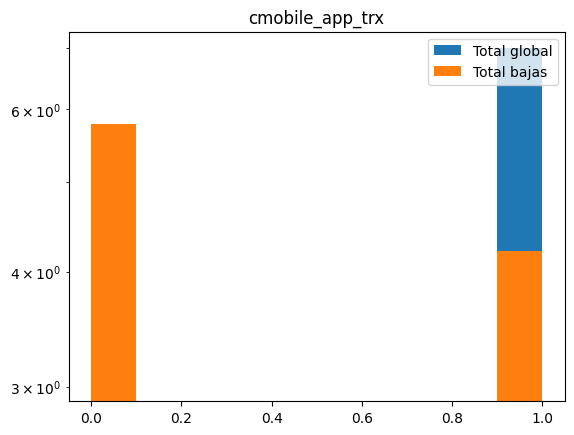

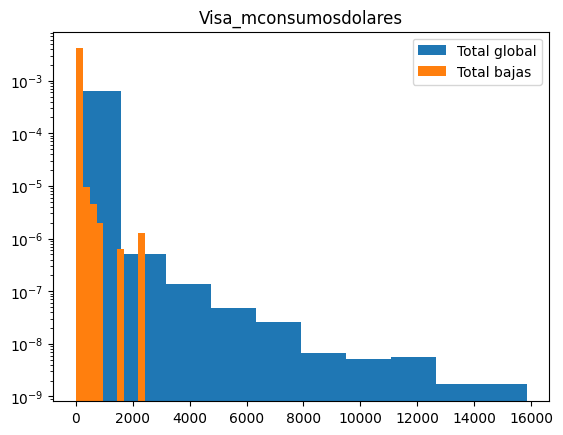

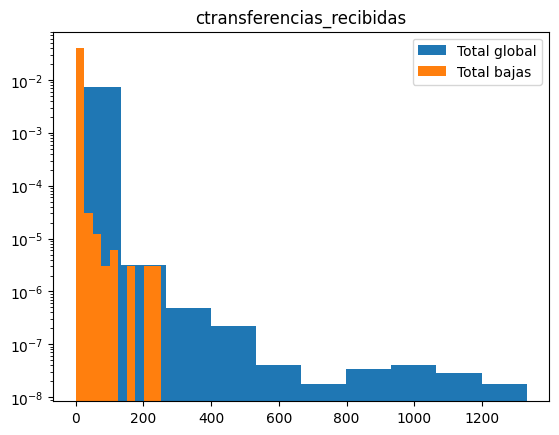

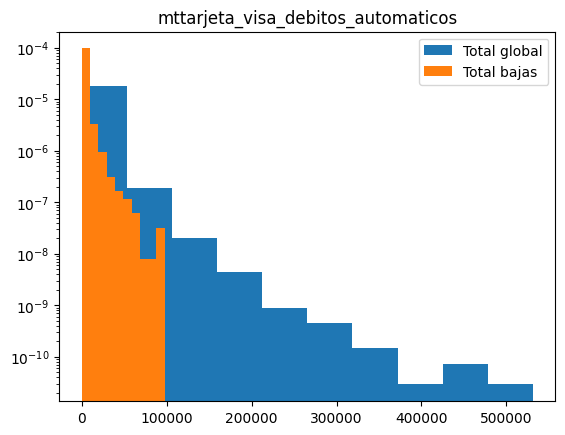

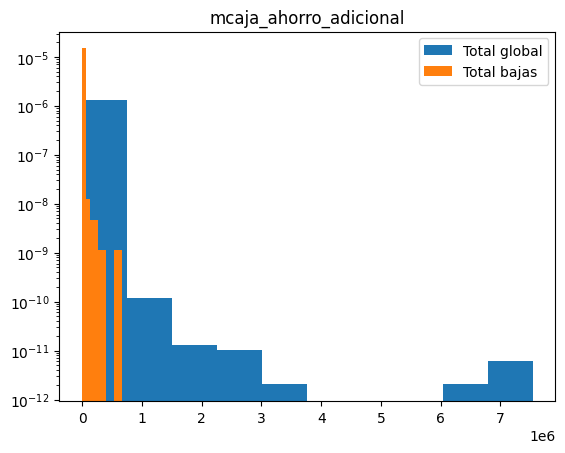

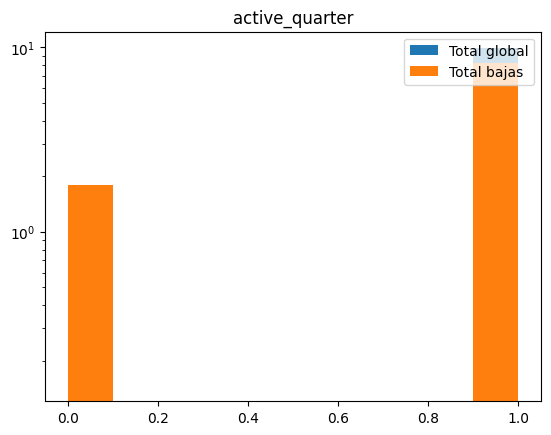

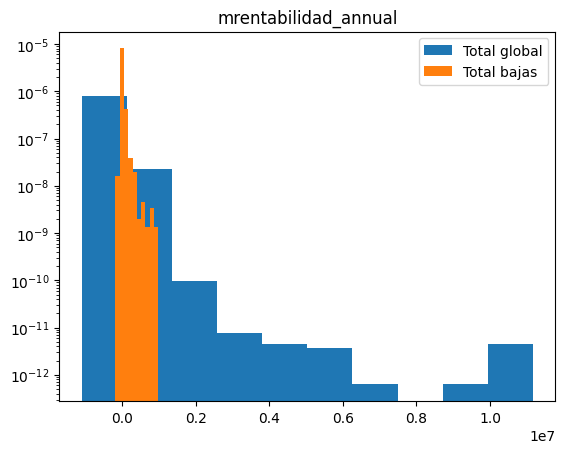

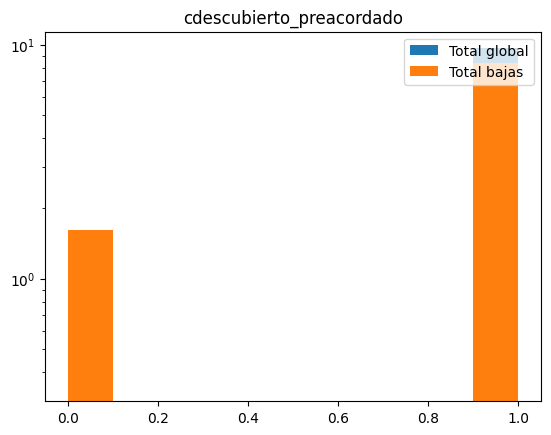

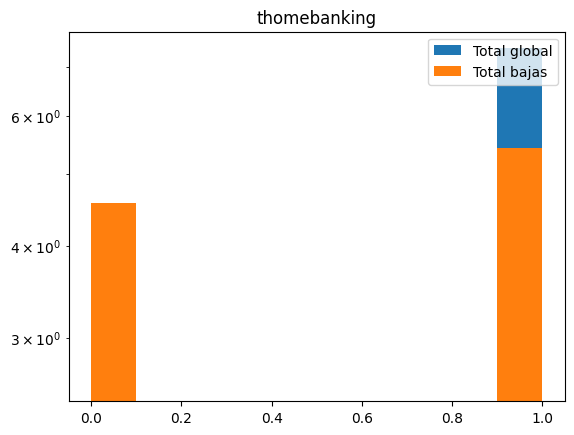

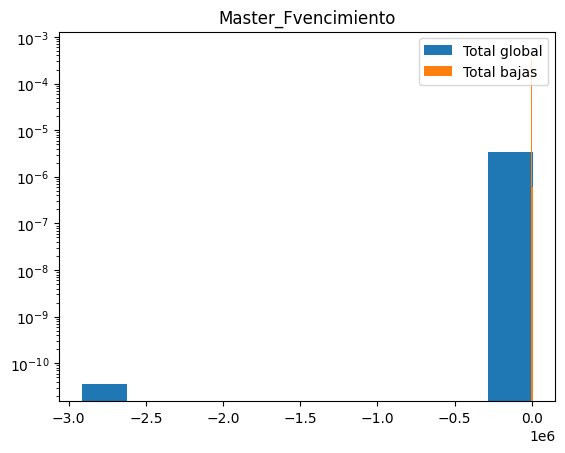

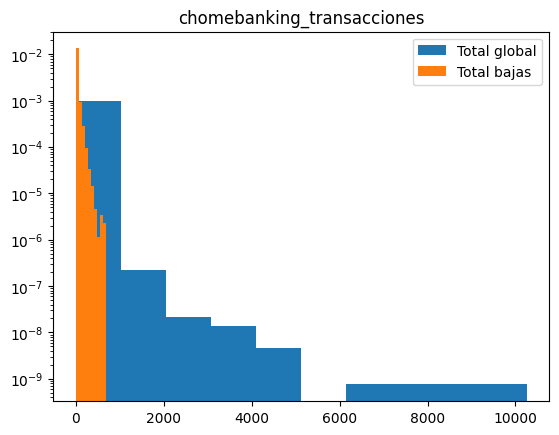

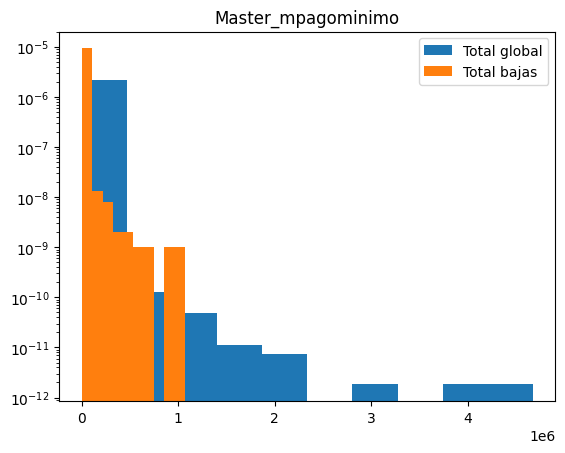

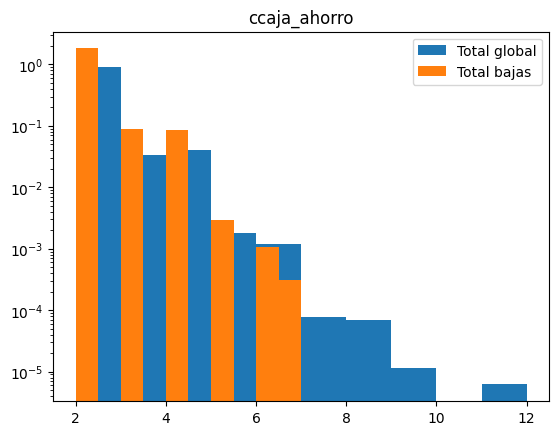

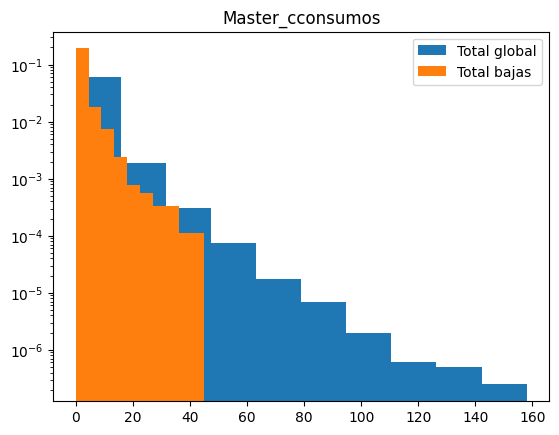

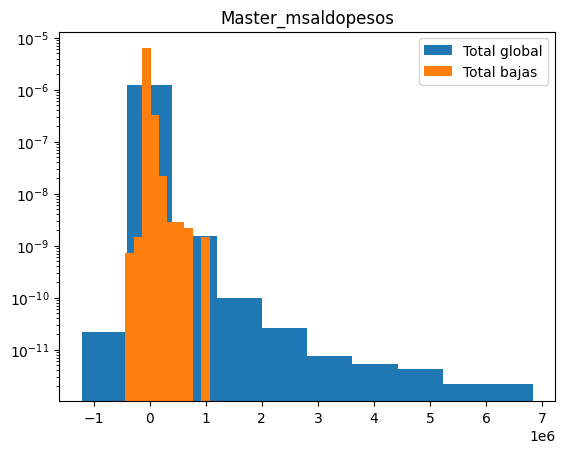

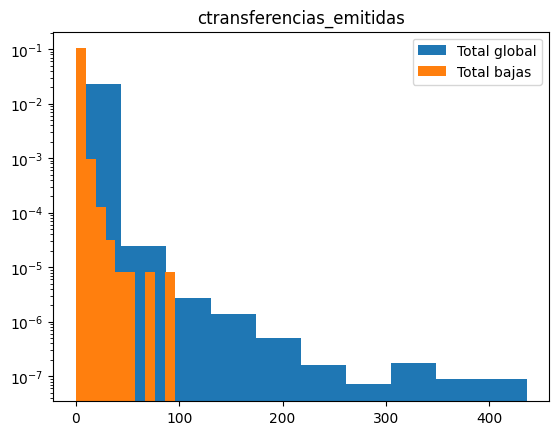

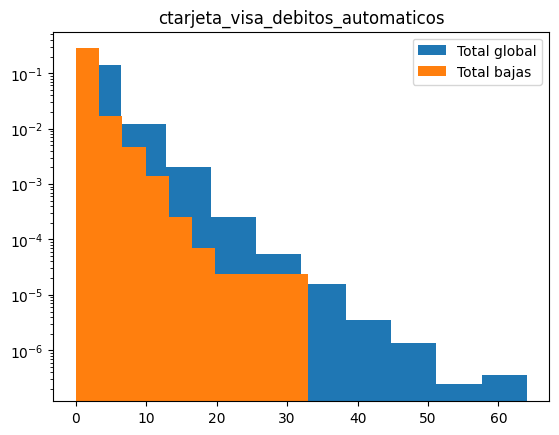

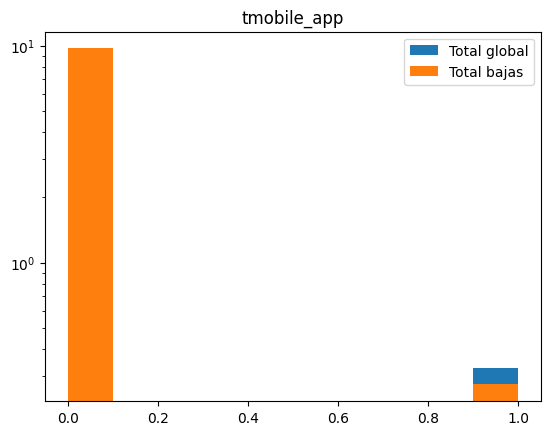

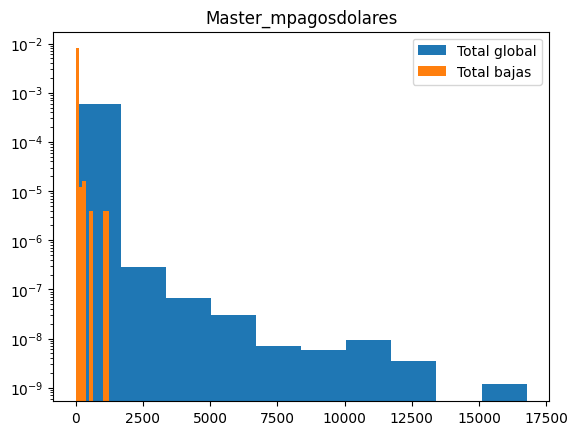

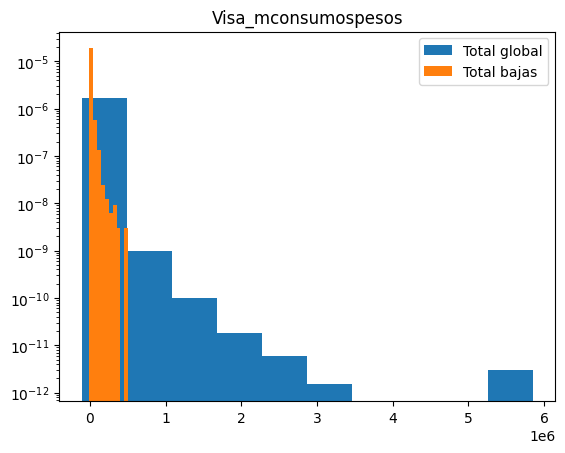

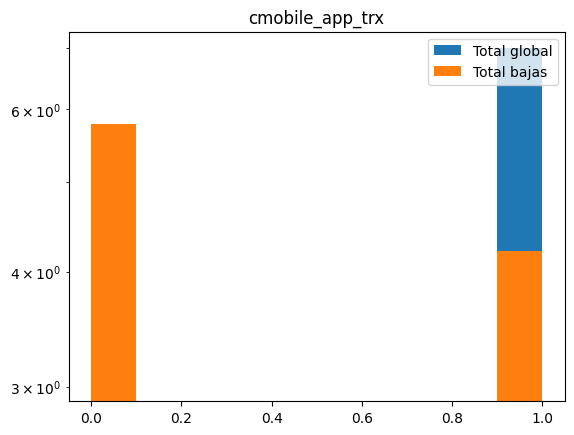

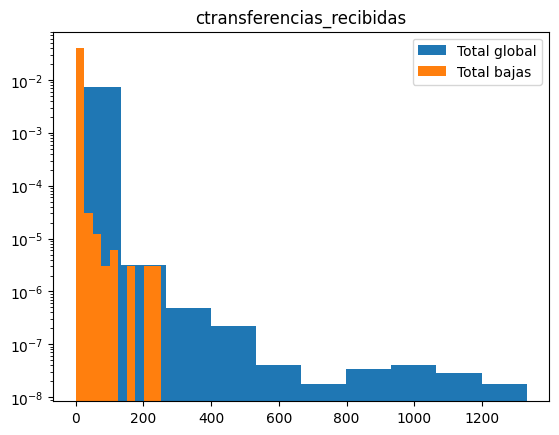

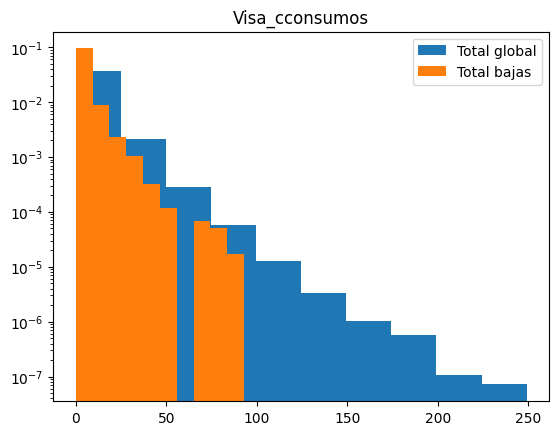

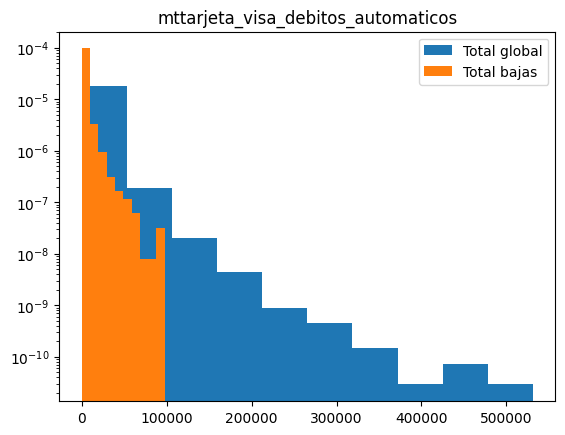

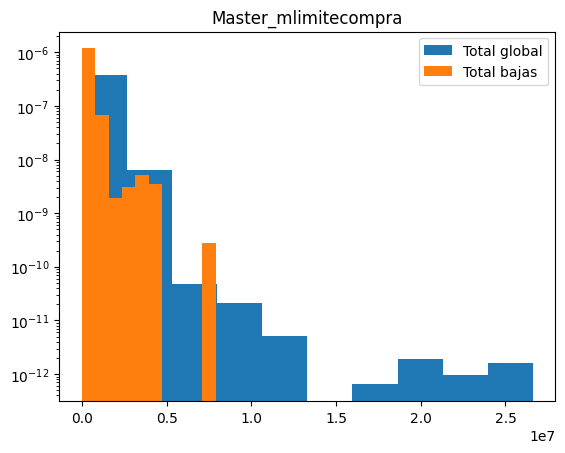

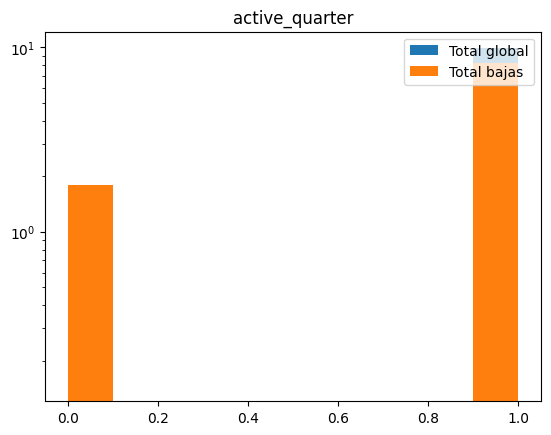

In [37]:
for i, (cluster_label, variables) in enumerate(variables_por_cluster.items()):
    pdf_pages = PdfPages(f'C:/Users/vanes/Documents/UBA/2do_cuatrimestre/DMEyF/graficos_global_{i}.pdf')
    for j, variable in enumerate(variables):
        plt.figure()
        plt.yscale('log')
        plt.hist(ds_train.loc[:][variable], label='Total global', density=True, bins=10)
        plt.hist(ds_bajas.loc[:][variable], label=f'Total bajas', density=True, bins=10)
        plt.legend(loc='upper right')
        plt.title(f'{variable}')
        pdf_pages.savefig()
    pdf_pages.close()

In [40]:
with open('resultados.txt', 'w') as file:
    for i, (cluster_label, variables) in enumerate(variables_por_cluster.items()):
        file.write(f'Cluster {cluster_label}:\n')
        
        for variable in variables:
            total_min = ds_train[variable].min()
            total_max = ds_train[variable].max()
            total_mean = ds_train[variable].mean()
            total_count = len(ds_train)
            
            bajas_min = ds_bajas[variable].min()
            bajas_max = ds_bajas[variable].max()
            bajas_mean = ds_bajas[variable].mean()
            bajas_count = len(ds_bajas)
            
            cluster_bajas_min = ds_bajas[y.labels_ == cluster_label][variable].min()
            cluster_bajas_max = ds_bajas[y.labels_ == cluster_label][variable].max()
            cluster_bajas_mean = ds_bajas[y.labels_ == cluster_label][variable].mean()
            cluster_bajas_count = len(ds_bajas[y.labels_ == cluster_label])
            
            cluster_percentage = (cluster_bajas_count / bajas_count) * 100
            
            file.write(f'Variable: {variable}\n')
            file.write(f'Total (ds_train): Min = {total_min}, Max = {total_max}, Mean = {total_mean}, Count = {total_count}\n')
            file.write(f'Total bajas (ds_bajas): Min = {bajas_min}, Max = {bajas_max}, Mean = {bajas_mean}, Count = {bajas_count}\n')
            file.write(f'Cluster {cluster_label} bajas: Min = {cluster_bajas_min}, Max = {cluster_bajas_max}, Mean = {cluster_bajas_mean}, Count = {cluster_bajas_count}\n')
            file.write(f'Porcentaje del total de bajas: {cluster_percentage:.2f}%\n')
            file.write('\n')

print('Resultados guardados en resultados.txt')

Resultados guardados en resultados.txt


In [41]:
ds_bajas.head()

foto_mes  active_quarter  cliente_vip  internet  cliente_edad  \
2937718    202010               1            0         0            76   
2937740    202010               0            0         1            68   
2937883    202010               1            0         0            54   
2937941    202010               0            0         0            47   
2937983    202010               1            0         0            57   

         cliente_antiguedad  mrentabilidad  mrentabilidad_annual  mcomisiones  \
2937718                 252        1358.82              24718.81       500.04   
2937740                  43        2109.87              19394.94      1730.53   
2937883                  61        1037.67               2812.15      1555.13   
2937941                  12        1988.10               7449.40      1730.53   
2937983                 317         411.45              35164.48       172.85   

         mactivos_margen  ...  Visa_madelantodolares  Visa_fultimo_cierre  \
2937718           -59.68  ...                    0.0                 24.0   
2937740           323.39  ...                    NaN                  3.0   
2937883          -549.92  ...                    0.0                  3.0   
2937941           219.58  ...                    NaN                  3.0   
2937983          -304.09  ...                    0.0                 10.0   

         Visa_mpagado  Visa_mpagospesos  Visa_mpagosdolares  Visa_fechaalta  \
2937718       3451.62          -3671.70                 0.0          5828.0   
2937740          0.00               NaN                 NaN          1284.0   
2937883          0.00         -30343.56                 0.0          1690.0   
2937941          0.00               NaN                 NaN           366.0   
2937983          0.00         -12601.60                 0.0          4787.0   

         Visa_mconsumototal  Visa_cconsumos  Visa_cadelantosefectivo  \
2937718             3410.69             3.0                      0.0   
2937740                 NaN             NaN                      NaN   
2937883             2485.10             5.0                      0.0   
2937941                 NaN             NaN                      NaN   
2937983            13048.73             4.0                      0.0   

         Visa_mpagominimo  
2937718            175.95  
2937740              0.00  
2937883           2862.12  
2937941              0.00  
2937983            668.61  

[5 rows x 153 columns]

In [42]:
ds_bajas.shape

(12987, 153)